In [1]:
import geopandas as gpd
import os
import xarray as xr
import rioxarray as rxr
import rasterio as rio
# import regionmask
from fiona.crs import from_epsg 
from shapely.geometry import Point, Polygon
import h5py as h5
from glob import glob
import json
import dask as da
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rasterio.warp import reproject, Resampling

import warnings
warnings.filterwarnings("ignore")

In [2]:
def gen_extent_from_neon_h5(fi, nid='CPER'):
    
    ds = h5.File(fi, 'r')
    map_info = str(ds['CPER']['Reflectance']['Metadata']['Coordinate_System']['Map_Info'][()])
    epsg = int(ds['CPER']['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'][()])
    data_shape = ds['CPER']['Reflectance']['Reflectance_Data'].shape
    
    # produce the affine transform components
    parts = [p.strip() for p in map_info.split(',')]
    aff = [float(p) for p in parts[1:7]]
    
    px, py, ul_x, ul_y = aff[:4]
    py = -py
    
    num_rows, num_cols, num_bands = data_shape
    
    # produce the points for the extent polygon
    ul = Point(ul_x, ul_y)
    ur = Point((ul_x +  num_cols*px), ul_y)
    ll = Point(ul_x, (ul_y + num_rows*py))
    lr = Point((ul_x + num_cols*px), (ul_y + num_rows*py))

    extent_poly = Polygon((ul, ur, lr, ll, ul))
    
    return extent_poly, epsg

# make function for reading h5 tiles
def read_h5_file(fi, nid='CPER'):
    # Read H5 file
    f = h5.File(fi, "r")
    
    # spectral
    wavelength = f[nid]['Reflectance']['Metadata']['Spectral_Data']['Wavelength'][:]
    fwhm = f[nid]['Reflectance']['Metadata']['Spectral_Data']['FWHM'][:]

    # CRS
    crs_str = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Coordinate_System_String'][()]
    crs_epsg = f[nid]['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'][()]
    crs_mapinfo = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Map_Info'][()]
    crs_proj4 = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Proj4'][()]

    #arr = f[nid]['Radiance']['Radiance_Data'][:]
    arr = da.array.from_array(f[nid]['Reflectance']['Reflectance_Data'], chunks=(256,256,256))
    arr /= float(f[nid]['Reflectance']['Reflectance_Data'].attrs['Scale_Factor'])
    
    mapinfo_list = [a.strip() for a in str(crs_mapinfo).split(',')]
    mapinfo = [float(a) for a in mapinfo_list[1:7]]
    mapinfo
    pix_size = mapinfo[0]
    x = np.arange(mapinfo[2], mapinfo[2] + pix_size*arr.shape[1], pix_size)
    y = np.arange(mapinfo[3], mapinfo[3] - pix_size* arr.shape[0], -pix_size)

    xr_cube = xr.DataArray(arr, {'y': y, 'x': x, 'bands': wavelength}, dims=['y', 'x', 'bands'])
    xr_cube_ma = xr_cube.where(xr_cube != -9999)
    
    # add in CRS assignemnt!!!!!!!!!!!!
    xr_cube_ma = xr_cube_ma.rio.write_crs(int(crs_epsg))
    
    return xr_cube_ma

def resample_h5_spectral(neon_file, weights_file):
    
    nis_ds = read_h5_file(neon_file)
    
    
    with open(weights_file, 'r') as fb:
        weights = json.load(fb)
    
    sample_bands = []
    for k in weights.keys():
        b_weights, b_ids = weights[k]
        sample_band = (nis_ds.isel(bands=b_ids)*np.array(b_weights)).sum(axis=-1)/ np.array(b_weights).sum()
        sample_bands.append(sample_band)
            
    
    sat_ds = xr.concat(sample_bands, dim=list(weights.keys())).rename({'concat_dim':'sat_band'}) # 'sat_band' will be new at dim=0
    
    return sat_ds

def check_valid_pixel_overlap(neon_file, geometry, weights_file):
    
    nis_ds = resample_h5_spectral(neon_file, weights_file)
    #print(nis_ds.spatial_ref)
    
    try:
        sample_clip = nis_ds.rio.clip([geometry])
        sample_im_clip = sample_clip.sel(sat_band='L8_Coastal')
        
        # count pixels vs total
        total_pixels = sample_im_clip.size
        gt0 = (sample_im_clip > 0.0).sum()
        valid_frac = gt0.values/total_pixels
        
        print(f'valid fraction: {valid_frac}')
        if valid_frac > 0.99:
            return valid_frac
        else:
            print('valid pixels are not above 99% of AOI, returning False')
            return valid_frac
    except Exception as e:
        
        print(e)
        print('not in bounds...')
        return 0.0

In [3]:
#geodataframe for file extents
h5_files = glob('../../NEON_spectrometer-orthorectified-surface-directional-reflectance---flightline-09132020/*.h5')
polys = [gen_extent_from_neon_h5(fi)[0] for fi in h5_files]
desc = [os.path.basename(fi).split('.')[0] for fi in h5_files]
epsg = gen_extent_from_neon_h5(h5_files[0])[1]

fl_gdf = gpd.GeoDataFrame({'geometry': polys, 'filename':desc}, crs=from_epsg(epsg))

<AxesSubplot:>

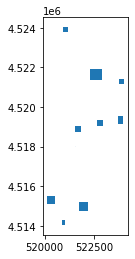

In [4]:
# load AOIS
aois = './aois/cper_aois.shp'
aoi_gdf = gpd.read_file(aois) # replace with shapefile or other
aoi_gdf['area_aoi'] = [g.area for g in aoi_gdf.geometry] # column for area
aoi_gdf.rename(columns={'desc_': 'desc'}, inplace=True)
aoi_gdf.plot()


In [5]:
# calculate the areas of overlap of AOI geometries within each flightline
aoi_overlap = gpd.overlay(fl_gdf, aoi_gdf, how='intersection')
aoi_overlap['area_ovr'] = aoi_overlap.geometry.area

# only save the ones that have full overlap
aoi_overlap = aoi_overlap.loc[aoi_overlap.area_ovr == aoi_overlap.area_aoi]
# aoi_overlap.area_ovr == aoi_overlap.area_aoi

In [6]:
# find the overlapping flightline with each aoi
l8_weights_file = './spectral_response/NIS_weights_L8.json'
overlap_series = []
for geom, desc in zip(aoi_gdf.geometry, aoi_gdf.desc):
    
    print(desc)
    #nfi = os.path.join('../NEON_spectrometer-orthorectified-surface-directional-reflectance---flightline', row[1]['filename'] + '.h5')
    overlaps = []
    for nfi in h5_files:
        
        vfac = check_valid_pixel_overlap(nfi, geom, l8_weights_file)
        overlaps.append(vfac)
        
    overlap_series.append(overlaps)

    
# aoi_fl_df = gpd.GeoDataFrame(series, crs=from_epsg(epsg))
# aoi_fl_df.reset_index()

tarp_outline_1
No data found in bounds. Data variable: truediv-d10baa730c358549bd60c625de54f356
not in bounds...
No data found in bounds. Data variable: truediv-1fda1e06beea895276b3f61ceeac0afc
not in bounds...
No data found in bounds. Data variable: truediv-695c9147e5f27fd2be041aae0e59abd8
not in bounds...
No data found in bounds. Data variable: truediv-27cef3ffc0e81bafcbbd10dfc7bf64f0
not in bounds...
No data found in bounds. Data variable: truediv-1fab594b9510e463c66513cba991e8fb
not in bounds...
valid fraction: 0.0
valid pixels are not above 99% of AOI, returning False
valid fraction: 1.0
valid fraction: 1.0
No data found in bounds. Data variable: truediv-2d62996614acb412cbeece410b2a205c
not in bounds...
No data found in bounds. Data variable: truediv-e9fe7a51a997309c18c3b4b8ed3183a9
not in bounds...
No data found in bounds. Data variable: truediv-8a2825622f7ccd9e118f9263322f861e
not in bounds...
No data found in bounds. Data variable: truediv-fb82b10a57270c489935118ae277ba80
not i

No data found in bounds. Data variable: truediv-10d722dc9f88dd053504ea4286816c62
not in bounds...
No data found in bounds. Data variable: truediv-b9683f572677273659420c960acd76a9
not in bounds...
No data found in bounds. Data variable: truediv-8a8437bc7ebeea0236dd75e1b7e70c61
not in bounds...
No data found in bounds. Data variable: truediv-db0580bb255be19b63b2f178d6122556
not in bounds...
No data found in bounds. Data variable: truediv-3e562b8b6fac6add6c6896ff1856fea1
not in bounds...
No data found in bounds. Data variable: truediv-8372dcc1c0e8c25c9f3259444b616f98
not in bounds...
No data found in bounds. Data variable: truediv-e60043442a7e0f9e1561b85368b29724
not in bounds...
valid fraction: 0.0
valid pixels are not above 99% of AOI, returning False
valid fraction: 0.38304448378254913
valid pixels are not above 99% of AOI, returning False
valid fraction: 0.9242597792885998
valid pixels are not above 99% of AOI, returning False
valid fraction: 0.5042951761867441
valid pixels are not ab

In [7]:
ov_thresh=0.99

overlap_arr = np.array(overlap_series)
overlap_arr.max(axis=1)
list(zip(np.where(overlap_arr > ov_thresh)))

[(array([ 0,  0,  0,  1,  1,  1,  3,  4,  7,  8,  9, 10], dtype=int64),),
 (array([ 6,  7, 14,  6,  7, 14,  6,  3,  8,  0,  0,  8], dtype=int64),)]

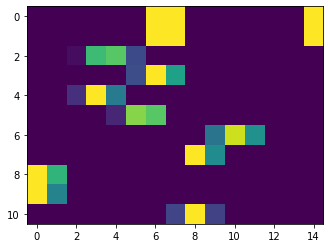

In [8]:
plt.imshow(overlap_arr)

In [9]:
rows, cols = np.where(overlap_arr > ov_thresh)
for i in range(rows.shape[0]):
    print(overlap_arr[rows[i], cols[i]])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


construct filename and geometry index pairs

In [10]:
# do this smartly
ov_idx = np.where(overlap_arr > ov_thresh)
_test = []
_temp_row, _temp_row_idx = [], []
for ix, a in enumerate(ov_idx[0]):
    if a in _temp_row:
        continue
    _temp_row.append(a)
    _temp_row_idx.append(ix)
    
for i,ix in enumerate(_temp_row_idx):
    _test.append((_temp_row[i], ov_idx[1][ix]))

# assign filename smartly
aoi_gdf['filename'] = None
for geomidx, fileidx in _test:
    aoi_gdf.at[geomidx,'filename'] = h5_files[fileidx]
    
       

In [11]:
aoi_gdf

Shape_Leng     Shape_Area                 desc  \
0     56.563405     175.029482       tarp_outline_1   
1     54.479200     155.715737       tarp_outline_2   
2   2270.871600  322228.810508           riverbed_1   
3   1348.775800  113548.628545               pond_1   
4   1271.502000  100967.725783  rectangular_patch_1   
5   1781.880200  197722.398591               pond_2   
6   1611.686000  162327.746536           riverbed_2   
7    749.269200   32507.902982              trees_1   
8   1320.613200  101452.632694                veg_1   
9   1059.018000   70005.110891            builtup_1   
10  1031.215600   66437.297830              trees_2   

                                             geometry       area_aoi  \
0   POLYGON ((521558.002 4518008.657, 521558.170 4...     175.029482   
1   POLYGON ((521576.763 4518020.205, 521576.763 4...     155.715737   
2   POLYGON ((522306.667 4521898.897, 522883.033 4...  322228.810508   
3   POLYGON ((521512.615 4519050.678, 521862.102 4...  113548.628545   
4   POLYGON ((522644.241 4519348.882, 522953.335 4...  100967.725783   
5   POLYGON ((521750.166 4515215.188, 522168.782 4...  197722.398591   
6   POLYGON ((520522.022 4515506.978, 520522.022 4...  162327.746536   
7   POLYGON ((520903.832 4514283.340, 521040.357 4...   32507.902982   
8   POLYGON ((523719.494 4519531.704, 523962.764 4...  101452.632694   
9   POLYGON ((523777.942 4521429.533, 524033.218 4...   70005.110891   
10  POLYGON ((520925.670 4524024.001, 521178.419 4...   66437.297831   

                                             filename  
0   ../../NEON_spectrometer-orthorectified-surface...  
1   ../../NEON_spectrometer-orthorectified-surface...  
2                                                None  
3   ../../NEON_spectrometer-orthorectified-surface...  
4   ../../NEON_spectrometer-orthorectified-surface...  
5                                                None  
6                                                None  
7   ../../NEON_spectrometer-orthorectified-surface...  
8   ../../NEON_spectrometer-orthorectified-surface...  
9   ../../NEON_spectrometer-orthorectified-surface...  
10  ../../NEON_spectrometer-orthorectified-surface...

In [65]:
# try the resample_match technique for landsat
landsat_file = '../../OutputsL8/LS8_20200913_lat40lon10423_r32p33_vmsk_mclds_topshad_rad_srefdem_stdsref.tif'
landsat_ds = rxr.open_rasterio(landsat_file)
l8_weights_file = './spectral_response/NIS_weights_L8.json'

In [66]:
# try the resample_match technique for landsat
s2 = '../../OutputsSen2_10m_09132020/SEN2_20200913_lat41lon10435_T13TEF_ORB141_utm13n_vmsk_rad_srefdem.tif'
s2 = '../../OutputsSen2_10m_09132020_AOTL8/SEN2_20200913_lat41lon10435_T13TEF_ORB141_utm13n_vmsk_rad_srefdem.tif' # same AOT as L8
s2 = '../../OutputsSen2_10m_09132020_AOTL8_STDSREF/SEN2_20200913_lat41lon10435_T13TEF_ORB141_utm13n_vmsk_topshad_rad_srefdem_stdsref.tif' # same AOT as L8 and standardized surface reflectance
s2 = '../../OutputsSen2_10m_09132020_STDSREF/SEN2_20200913_lat41lon10435_T13TEF_ORB141_utm13n_vmsk_topshad_rad_srefdem_stdsref.tif' # standardized SR, DOS method for AOT

s2_ds = rxr.open_rasterio(s2)
s2_weights_file = './spectral_response/NIS_weights_S2A.json'

## loop over the geometries and do the groupby method to produce STD and MEAN per satellite pixel

In [67]:
# lists to store results
res_L8_means, res_S2_means, res_L8_stds, res_S2_stds =  [],[],[],[]
L8_arrs, S2_arrs = [],[]

# open the satellite image files
landsat_ds = rxr.open_rasterio(landsat_file)
s2_ds = rxr.open_rasterio(s2)
for desc, geom, fi in aoi_gdf.dropna()[['desc', 'geometry', 'filename']].values:
    
    print(desc)
    
    # spectral resample to each satellite
    neon_ds_L8 = resample_h5_spectral(fi, l8_weights_file)
    neon_ds_S2 = resample_h5_spectral(fi, s2_weights_file)
    
    # clip to current AOI
    neon_ds_L8 = neon_ds_L8.rio.clip([geom], all_touched=True, from_disk=True)
    neon_ds_S2 = neon_ds_S2.rio.clip([geom], all_touched=True, from_disk=True)
    
    # clip landsat and sentinel datasets, add to list
    L8_arrs.append(landsat_ds.rio.clip([geom], all_touched=True, from_disk=True))
    S2_arrs.append(s2_ds.rio.clip([geom], all_touched=True, from_disk=True))
    
    # group by for mean
    target_res = 30
    reduced_L8_mean = (
        neon_ds_L8
        .groupby(((neon_ds_L8.x//target_res) + 0.5) * target_res)
        .mean(dim='x')
        .groupby(((neon_ds_L8.y//target_res) + 0.5) * target_res)
        .mean(dim='y'))

    target_res = 10
    reduced_S2_mean = (
        neon_ds_S2
        .groupby(((neon_ds_S2.x//target_res) + 0.5) * target_res)
        .mean(dim='x')
        .groupby(((neon_ds_S2.y//target_res) + 0.5) * target_res)
        .mean(dim='y'))
    
    # group by for STD
    target_res = 30
    reduced_L8_std = (
        neon_ds_L8
        .groupby(((neon_ds_L8.x//target_res) + 0.5) * target_res)
        .std(dim='x')
        .groupby(((neon_ds_L8.y//target_res) + 0.5) * target_res)
        .std(dim='y'))

    target_res = 10
    reduced_S2_std = (
        neon_ds_S2
        .groupby(((neon_ds_S2.x//target_res) + 0.5) * target_res)
        .std(dim='x')
        .groupby(((neon_ds_S2.y//target_res) + 0.5) * target_res)
        .std(dim='y'))
    
    # append to lists
    res_L8_means.append(reduced_L8_mean)
    res_S2_means.append(reduced_S2_mean)
    res_L8_stds.append(reduced_L8_std)
    res_S2_stds.append(reduced_S2_std)


tarp_outline_1
tarp_outline_2
pond_1
rectangular_patch_1
trees_1
veg_1
builtup_1
trees_2


tarp_outline_1
array is too small for anything, continuing...
tarp_outline_2
array is too small for anything, continuing...
pond_1


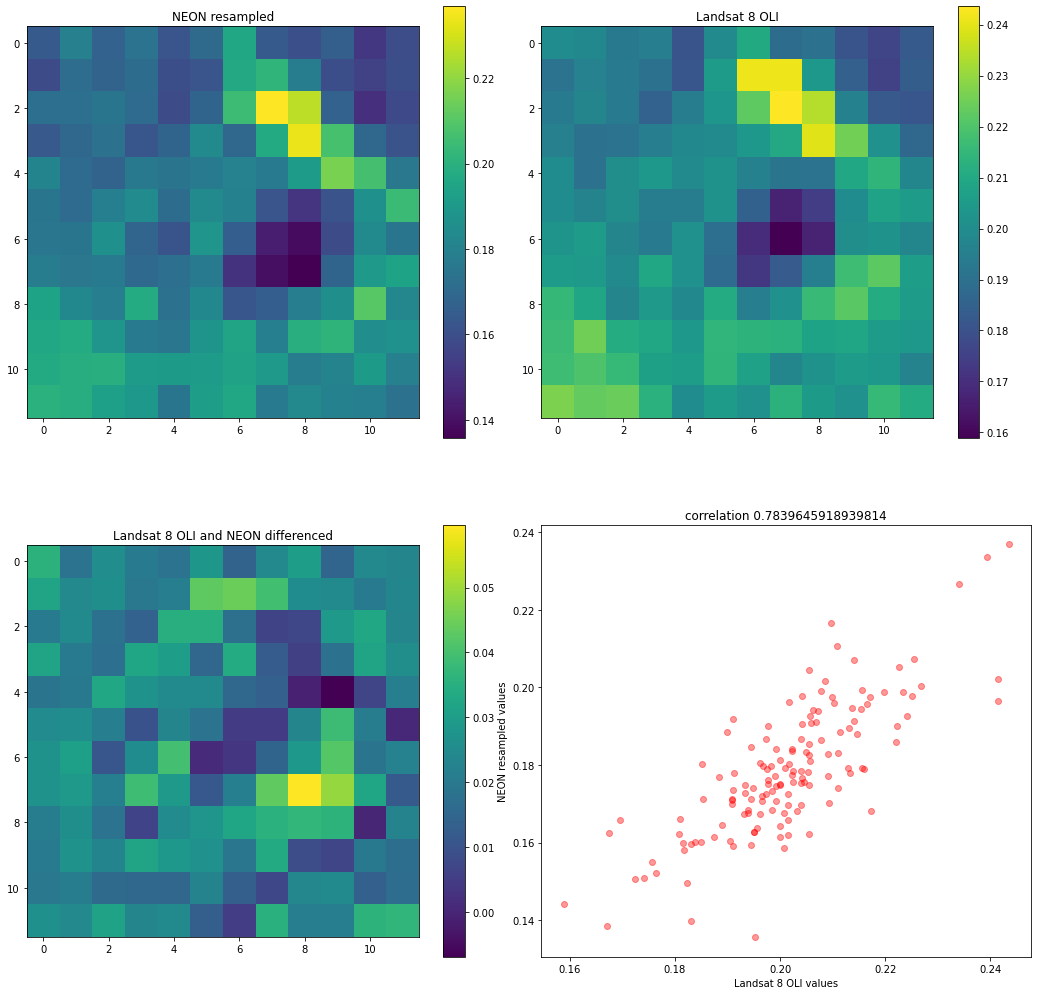

rectangular_patch_1


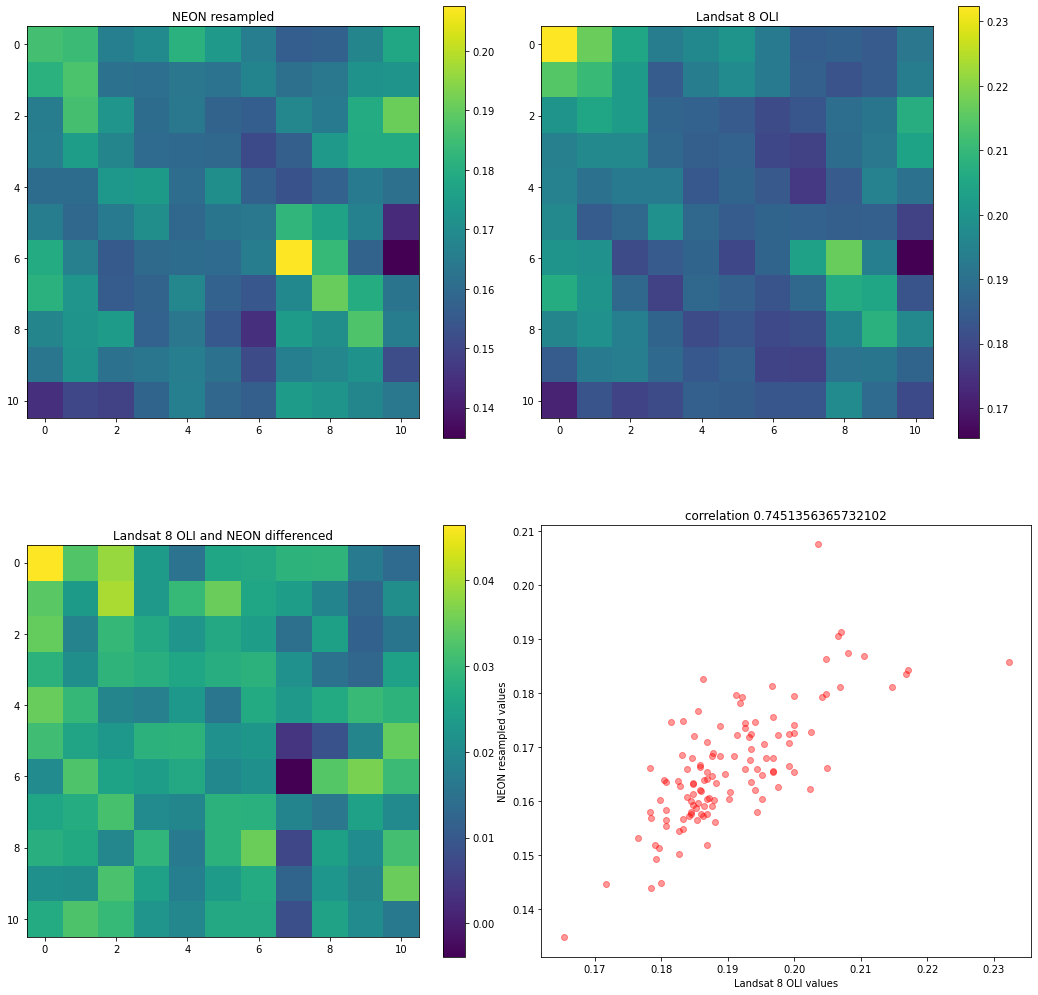

trees_1


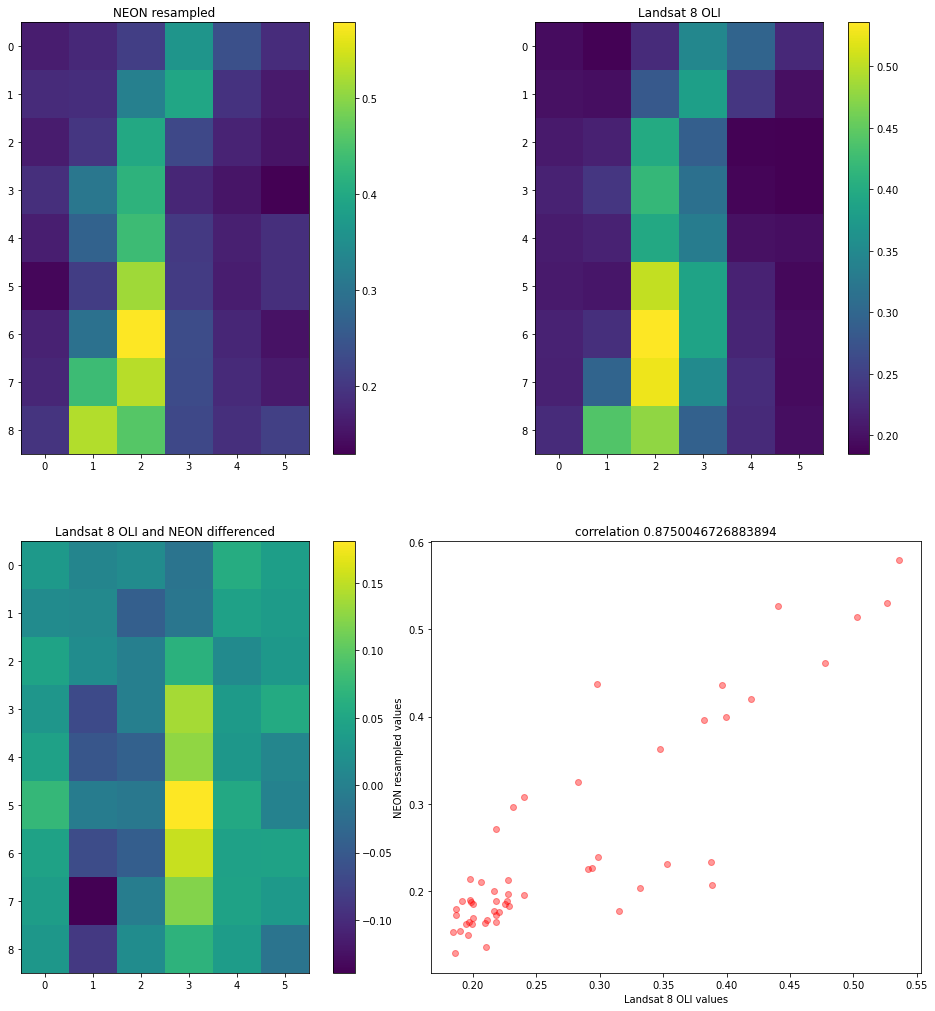

veg_1


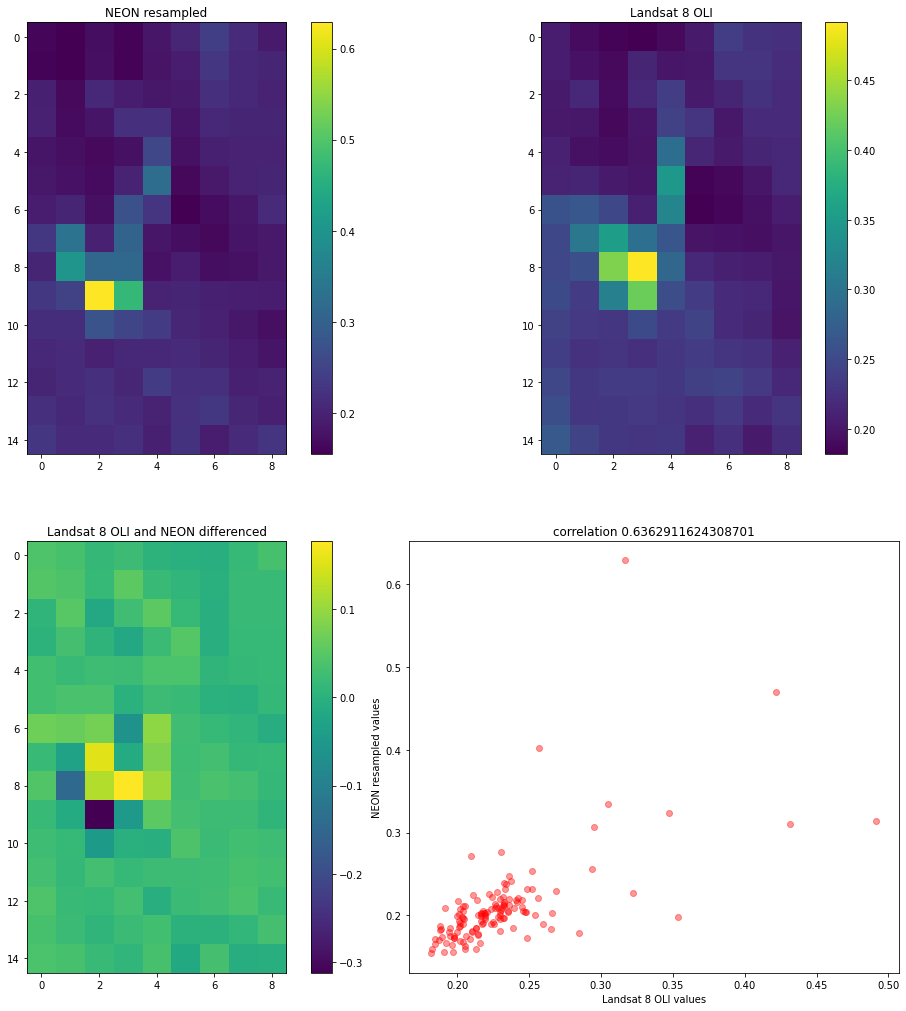

builtup_1


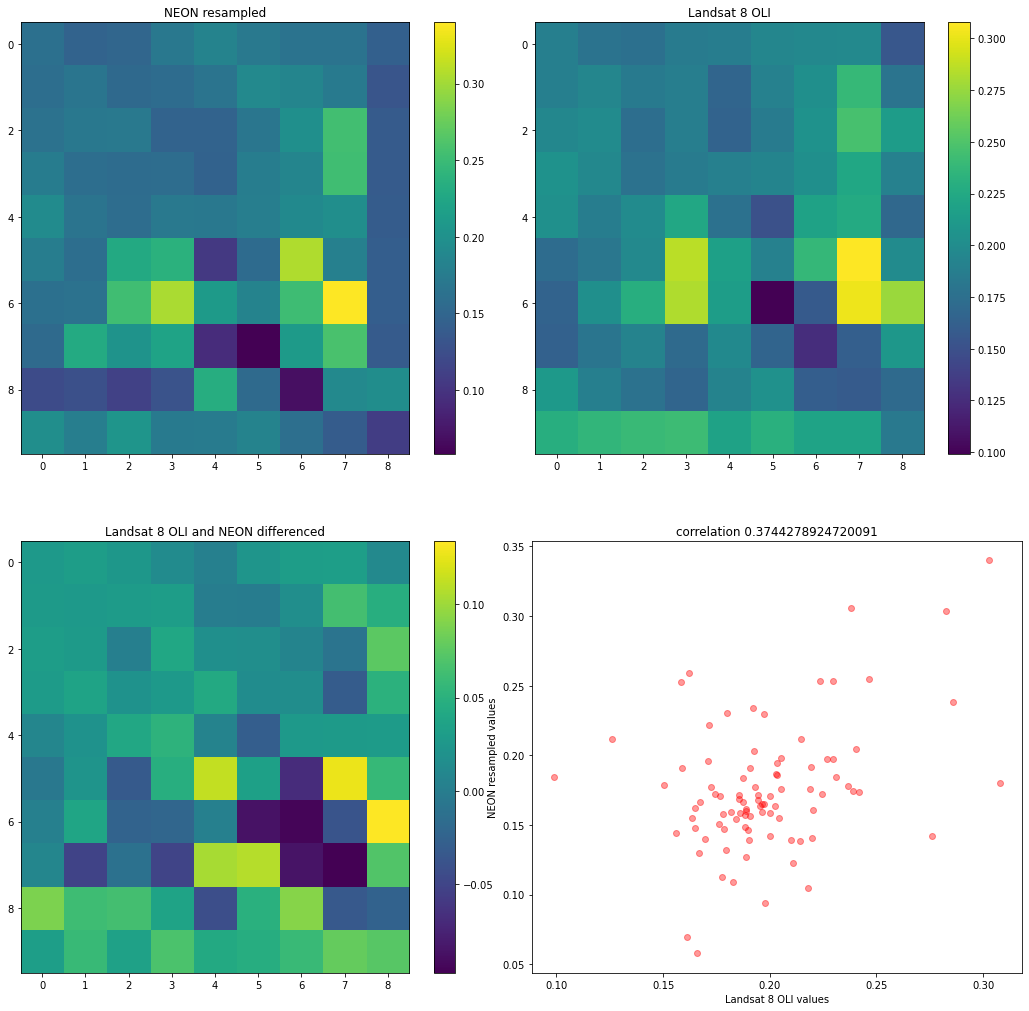

trees_2


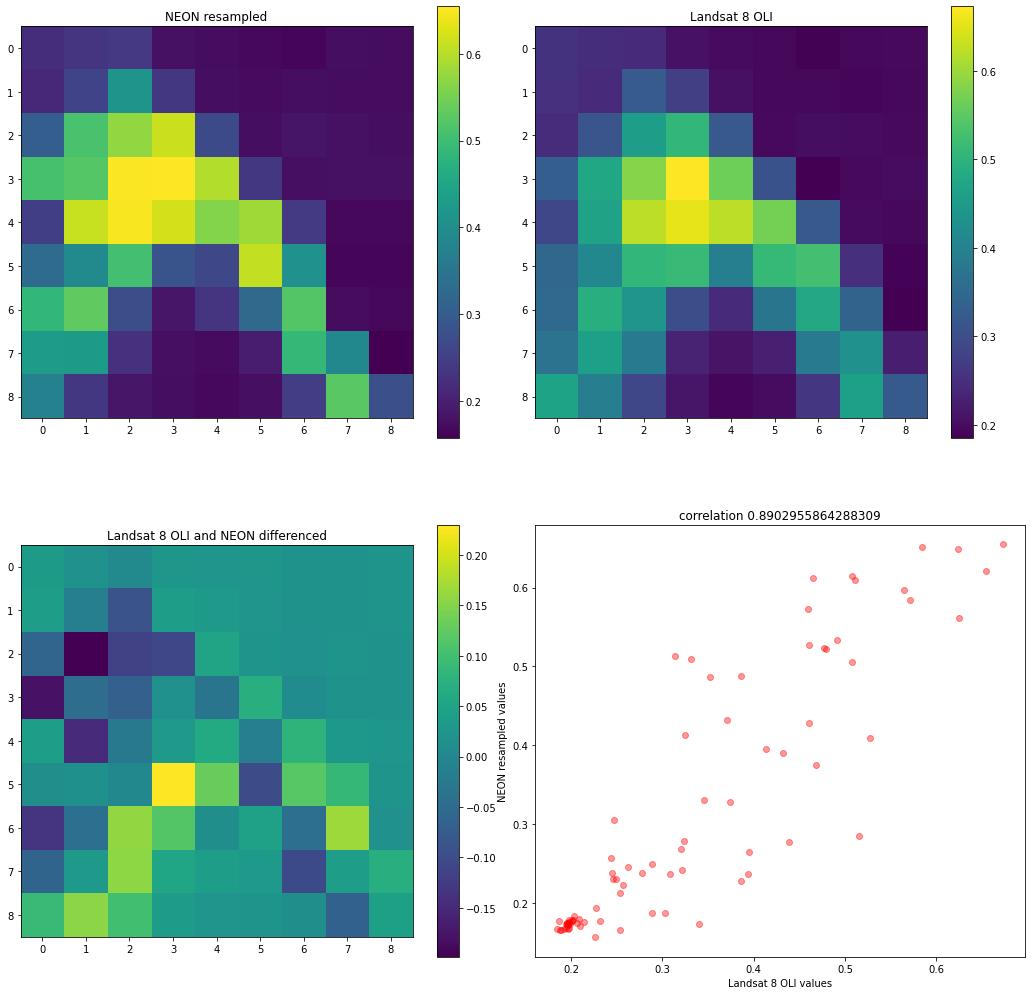

In [68]:
# plot Landsat 8 ndvi for AOIs
for desc, neon_L8, og_L8 in zip(aoi_gdf.dropna().desc.values, res_L8_means, L8_arrs):
    
    print(desc)
    # NEON NDVI
    neon_num = neon_L8.sel(sat_band='L8_NIR') - neon_L8.sel(sat_band='L8_Red')
    neon_den = neon_L8.sel(sat_band='L8_NIR') + neon_L8.sel(sat_band='L8_Red')
    neon_ndvi = neon_num / neon_den
    
    # Satellite NDVI
    sat_num = og_L8.sel(band=5) - og_L8.sel(band=4)
    sat_den = og_L8.sel(band=5) + og_L8.sel(band=4)
    sat_ndvi = (sat_num.astype('float')/10000) / (sat_den.astype('float')/10000)
    
    ## check shapes. if less than 2x2, fuhgeddaboutit
    neon_vals = np.flipud(neon_ndvi.values)
    sat_vals = sat_ndvi.values
    
    # hard threshold bad values
    neon_vals[neon_vals>1] = 1
    neon_vals[neon_vals<-1] = 1
    
    neon_shape = neon_vals.shape
    sat_shape = sat_vals.shape
    
    if 1 in np.array([neon_shape] + [sat_shape]):
        print('array is too small for anything, continuing...')
        continue
    
    # slice if necessary
    if neon_shape[0] < sat_shape[0]:
        sat_vals = sat_vals[:neon_shape[0],:]
            
    if neon_shape[1] < sat_shape[1]:
        sat_vals = sat_vals[:, :neon_shape[1]]
        
    if neon_shape[0] > sat_shape[0]:
        neon_vals = neon_vals[:sat_shape[0],:]
            
    if neon_shape[1] > sat_shape[1]:
        neon_vals = neon_vals[:, :sat_shape[1]]
    
    # get the correlation coefficient
    corr = np.ma.corrcoef(np.ma.masked_invalid(neon_vals.flatten()), np.ma.masked_invalid(sat_vals.flatten()))[0,1]
    
    # plot the NDVI
    fig, ax = plt.subplots(2,2, figsize=(15,15))
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
    
    im = ax[0,0].imshow(neon_vals)
    fig.colorbar(im, ax=ax[0,0])
    ax[0,0].set_title('NEON resampled')
    
    im = ax[0,1].imshow(sat_vals)
    fig.colorbar(im, ax=ax[0,1])
    ax[0,1].set_title('Landsat 8 OLI')
    
    im = ax[1,0].imshow(sat_vals - neon_vals)
    fig.colorbar(im, ax=ax[1,0])
    ax[1,0].set_title('Landsat 8 OLI and NEON differenced')
    
    
    ax[1,1].scatter(sat_vals.flatten(), neon_vals.flatten(), alpha=0.4, color='r')
    ax[1,1].set_xlabel('Landsat 8 OLI values')
    ax[1,1].set_ylabel('NEON resampled values')
    ax[1,1].set_title(f'correlation {corr}')
    plt.show()

tarp_outline_1


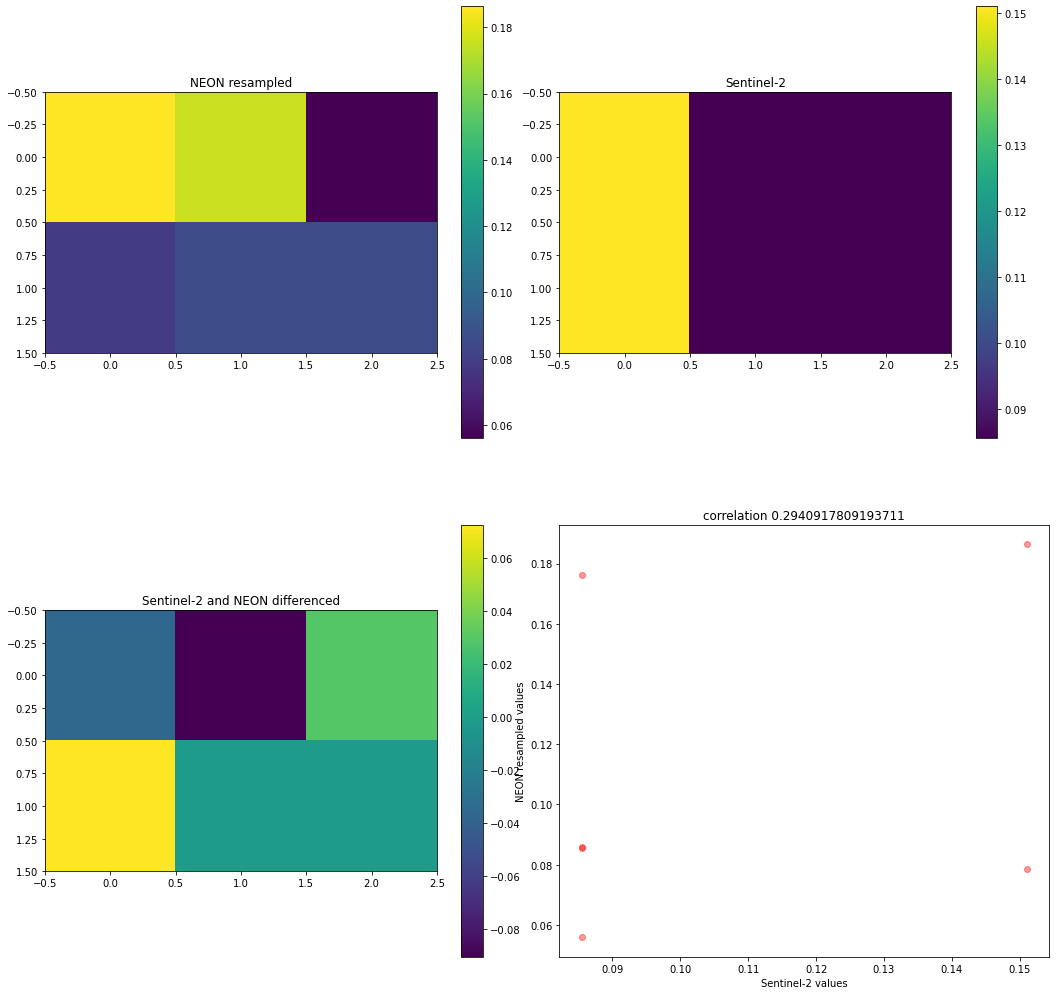

tarp_outline_2


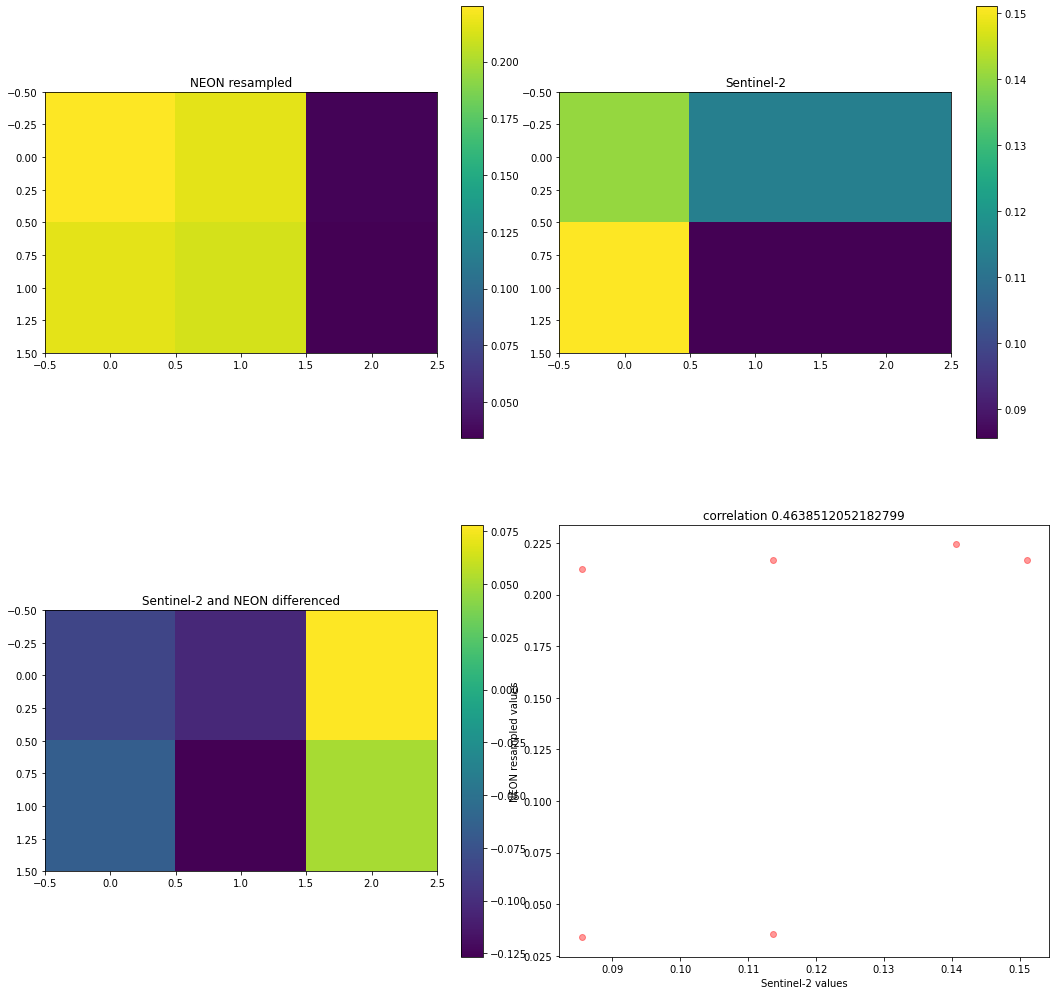

pond_1


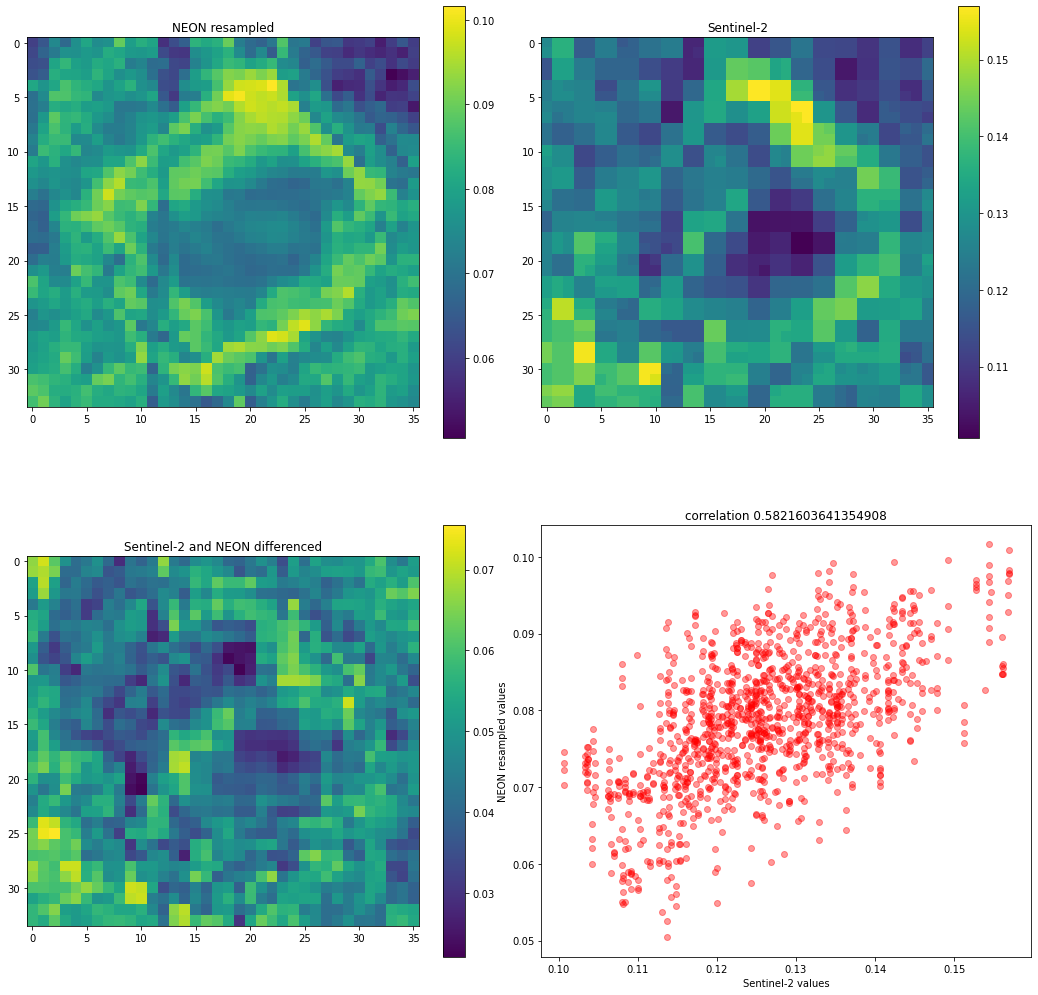

rectangular_patch_1


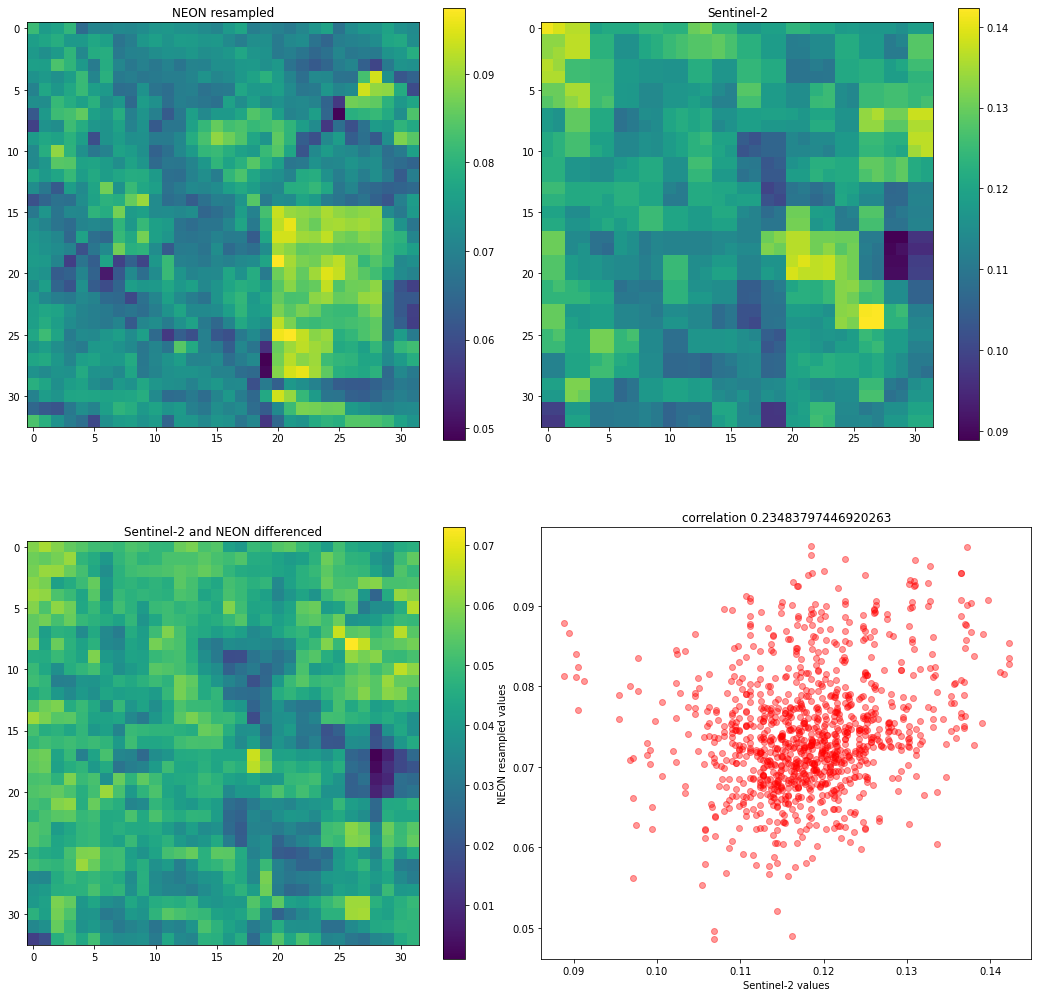

trees_1


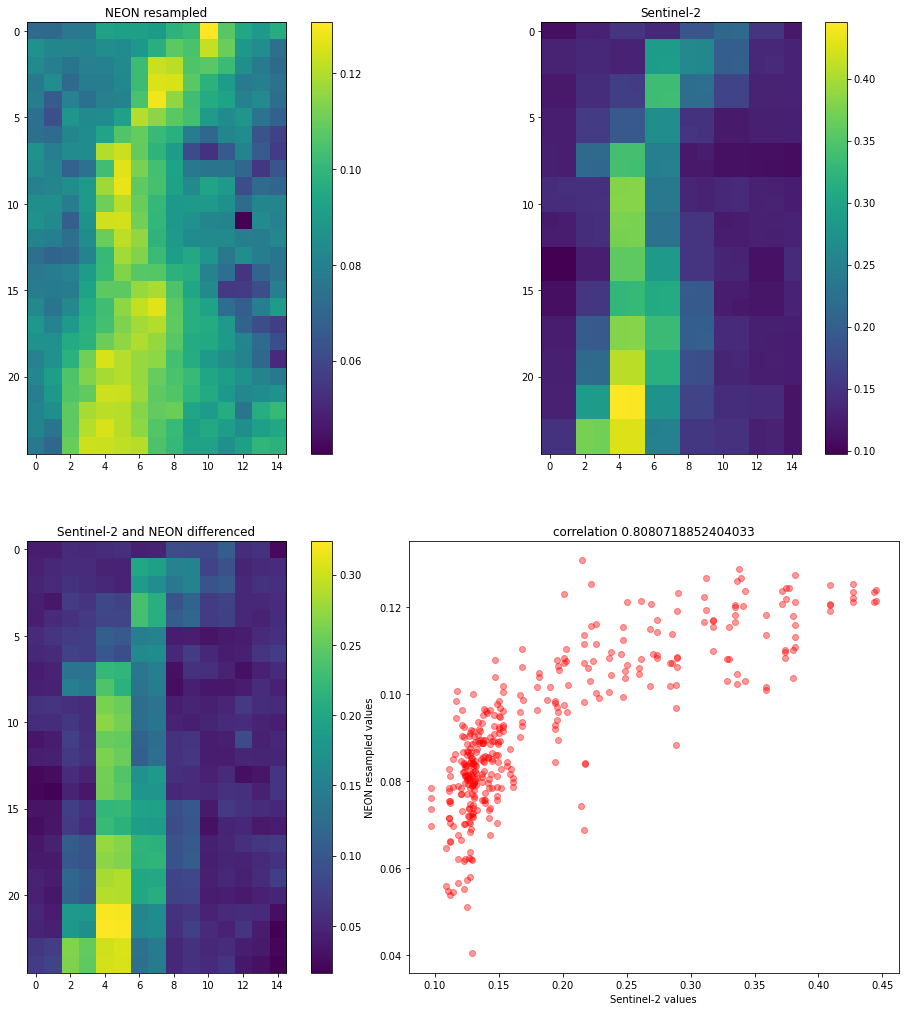

veg_1


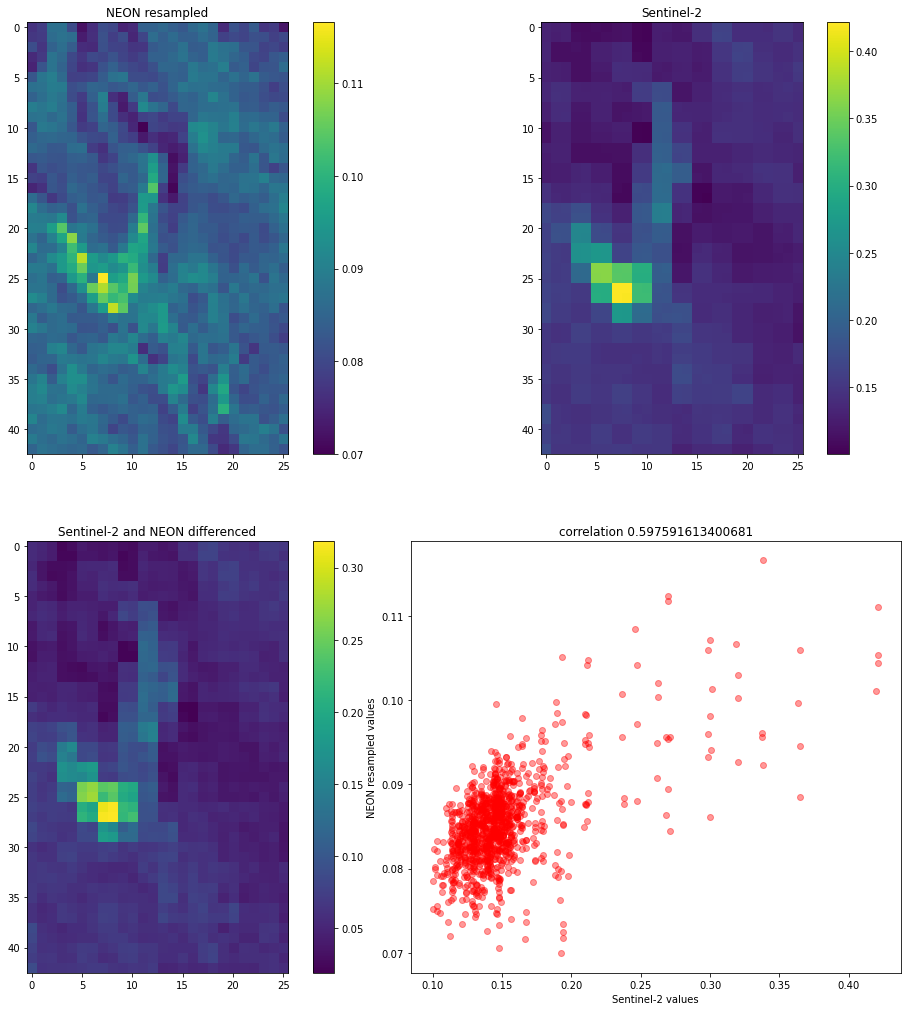

builtup_1


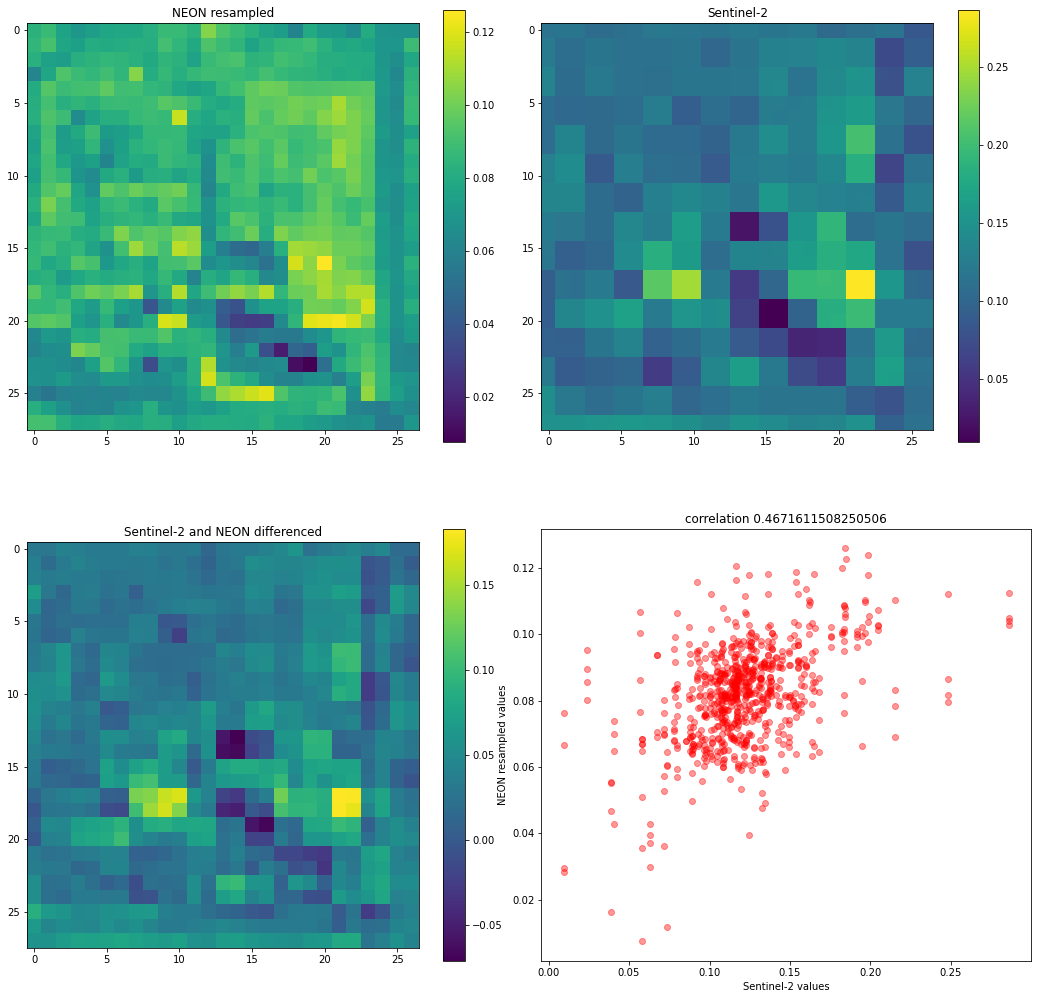

trees_2


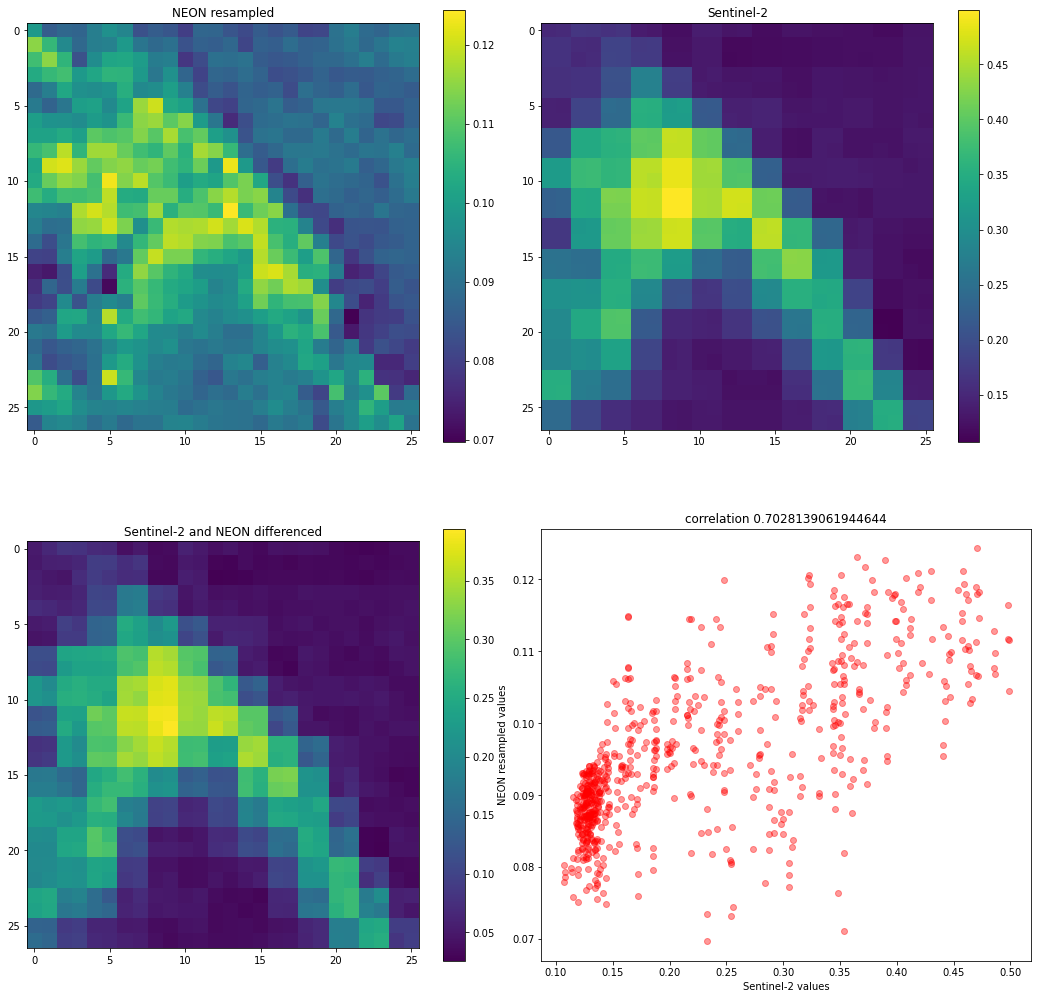

In [69]:
# plot Sentinel-2 8 ndvi for AOIs
for desc, neon_S2, og_S2 in zip(aoi_gdf.dropna().desc.values, res_S2_means, S2_arrs):
    
    print(desc)
    # NEON NDVI
    neon_num = neon_S2.sel(sat_band='S2A_B8') - neon_S2.sel(sat_band='S2A_B4')
    neon_den = neon_S2.sel(sat_band='S2A_B8') + neon_S2.sel(sat_band='S2A_B4')
    neon_ndvi = neon_num / neon_den
    
    # Satellite NDVI
    sat_num = og_S2.sel(band=8) - og_S2.sel(band=4)
    sat_den = og_S2.sel(band=8) + og_S2.sel(band=4)
    sat_ndvi = (sat_num.astype('float')/10000) / (sat_den.astype('float')/10000)
    
    ## check shapes. if less than 2x2, fuhgeddaboutit
    neon_vals = np.flipud(neon_ndvi.values)
    sat_vals = sat_ndvi.values
    
    # hard threshold bad values
    neon_vals[neon_vals>1] = 1
    neon_vals[neon_vals<-1] = 1
    
    neon_shape = neon_vals.shape
    sat_shape = sat_vals.shape
    
    if 1 in np.array([neon_shape] + [sat_shape]):
        print('array is too small for anything, continuing...')
        continue
    
    # slice if necessary
    if neon_shape[0] < sat_shape[0]:
        sat_vals = sat_vals[:neon_shape[0],:]
            
    if neon_shape[1] < sat_shape[1]:
        sat_vals = sat_vals[:, :neon_shape[1]]
        
    if neon_shape[0] > sat_shape[0]:
        neon_vals = neon_vals[:sat_shape[0],:]
            
    if neon_shape[1] > sat_shape[1]:
        neon_vals = neon_vals[:, :sat_shape[1]]
    
    # get the correlation coefficient
    corr = np.ma.corrcoef(np.ma.masked_invalid(neon_vals.flatten()), np.ma.masked_invalid(sat_vals.flatten()))[0,1]
    
    # plot the NDVI
    fig, ax = plt.subplots(2,2, figsize=(15,15))
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
    
    im = ax[0,0].imshow(neon_vals)
    fig.colorbar(im, ax=ax[0,0])
    ax[0,0].set_title('NEON resampled')
    
    im = ax[0,1].imshow(sat_vals)
    fig.colorbar(im, ax=ax[0,1])
    ax[0,1].set_title('Sentinel-2')
    
    im = ax[1,0].imshow(sat_vals - neon_vals)
    fig.colorbar(im, ax=ax[1,0])
    ax[1,0].set_title('Sentinel-2 and NEON differenced')
    
    
    ax[1,1].scatter(sat_vals.flatten(), neon_vals.flatten(), alpha=0.4, color='r')
    ax[1,1].set_xlabel('Sentinel-2 values')
    ax[1,1].set_ylabel('NEON resampled values')
    ax[1,1].set_title(f'correlation {corr}')
    plt.show()

# Look at the band means and plot the difference map as function of variance or STD

In [70]:
from scipy.stats import linregress
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Landsat

tarp_outline_1
tarp is too small, skip it...
tarp_outline_2
tarp is too small, skip it...
pond_1
L8_Coastal 1


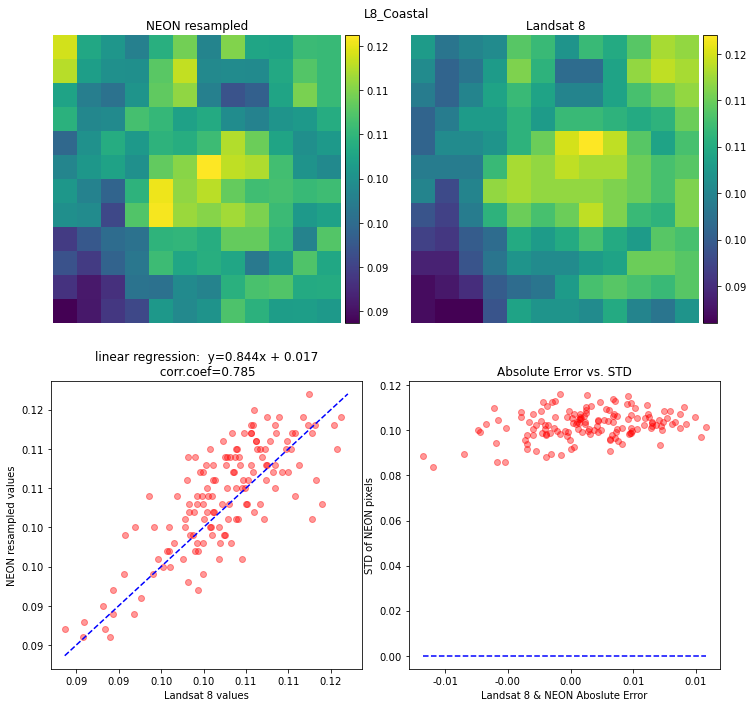

L8_Blue 2


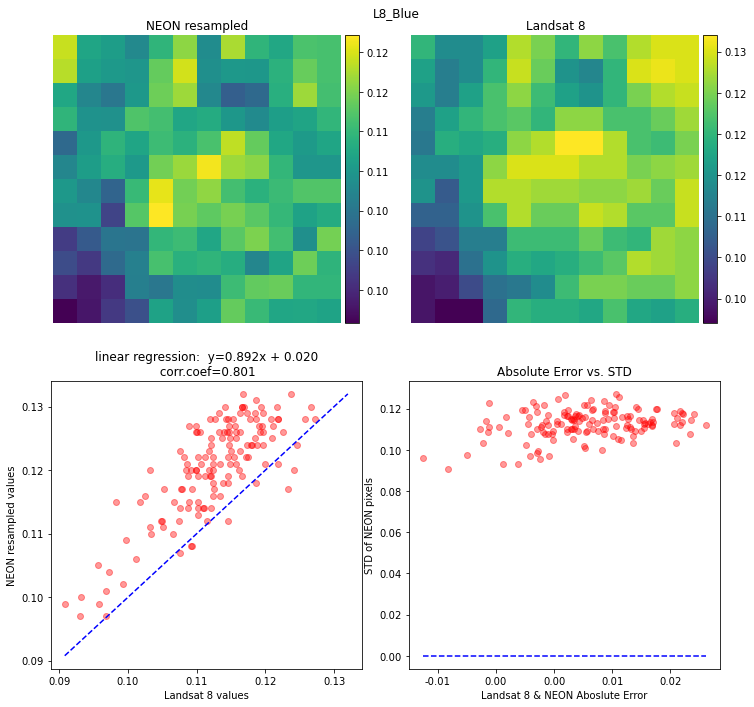

L8_Green 3


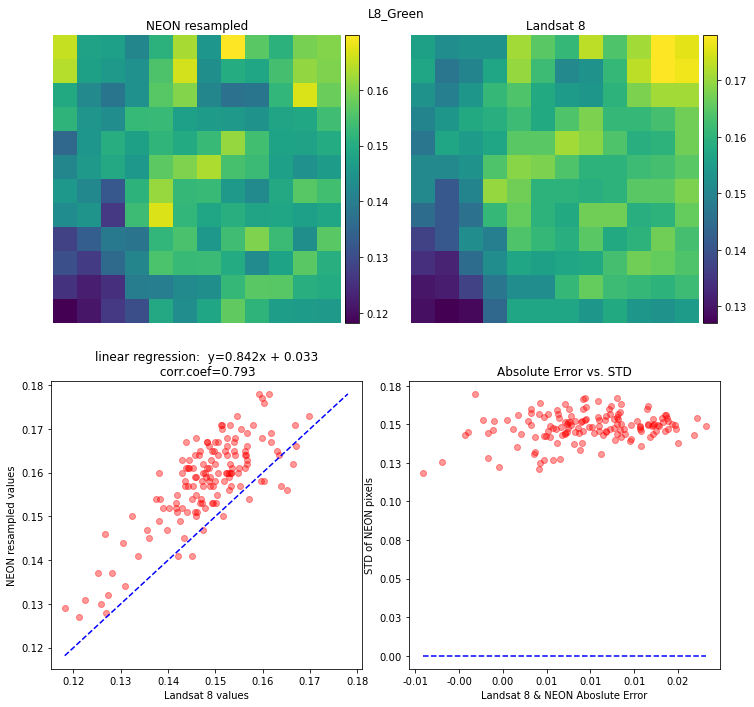

L8_Red 4


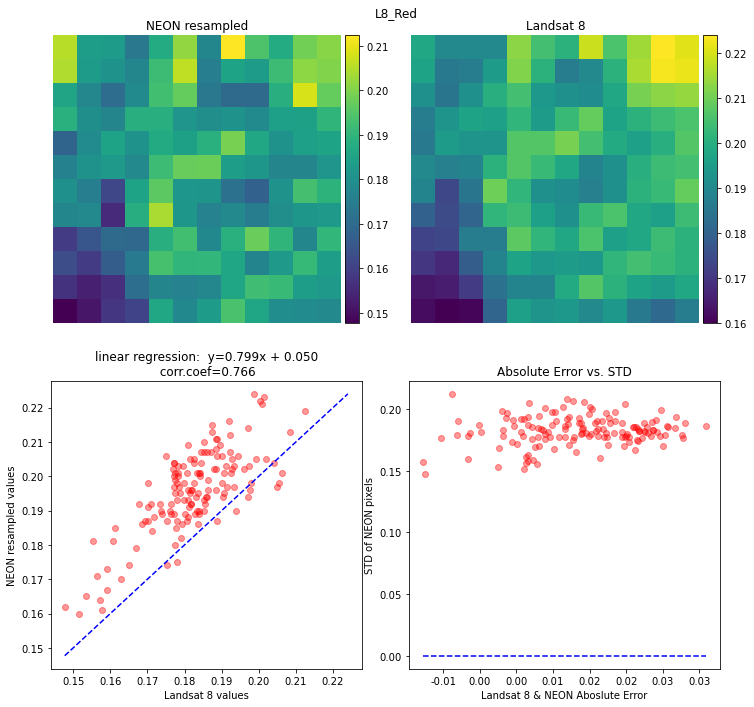

L8_NIR 5


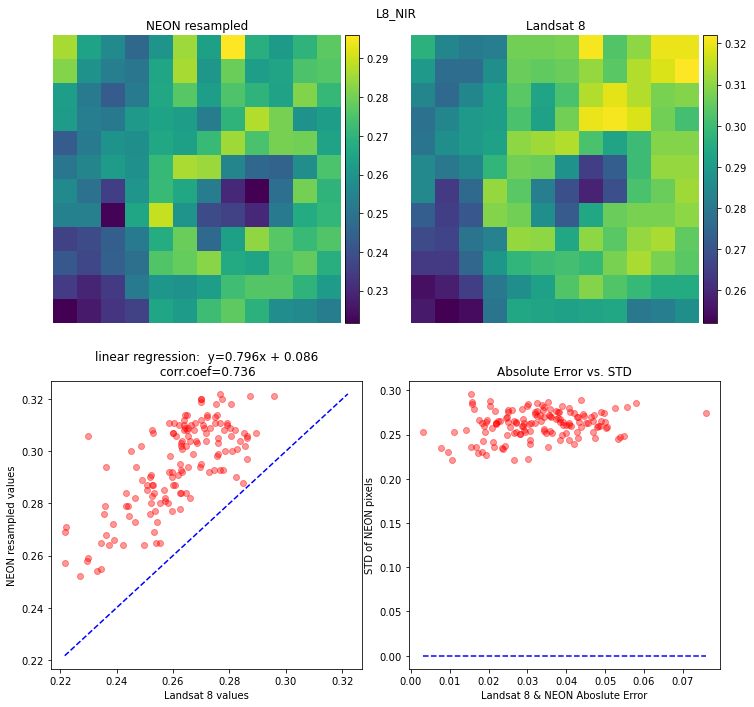

L8_SWIR1 6


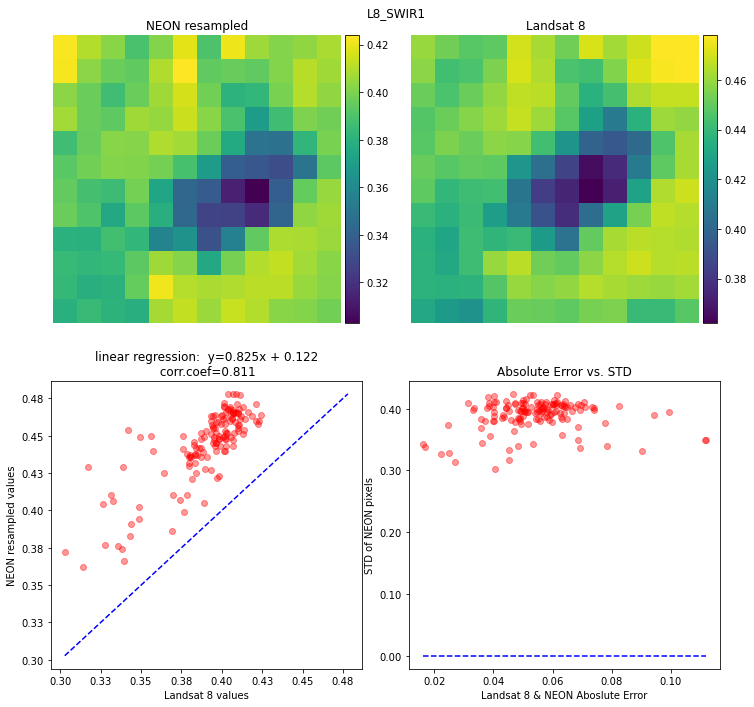

L8_SWIR2 7


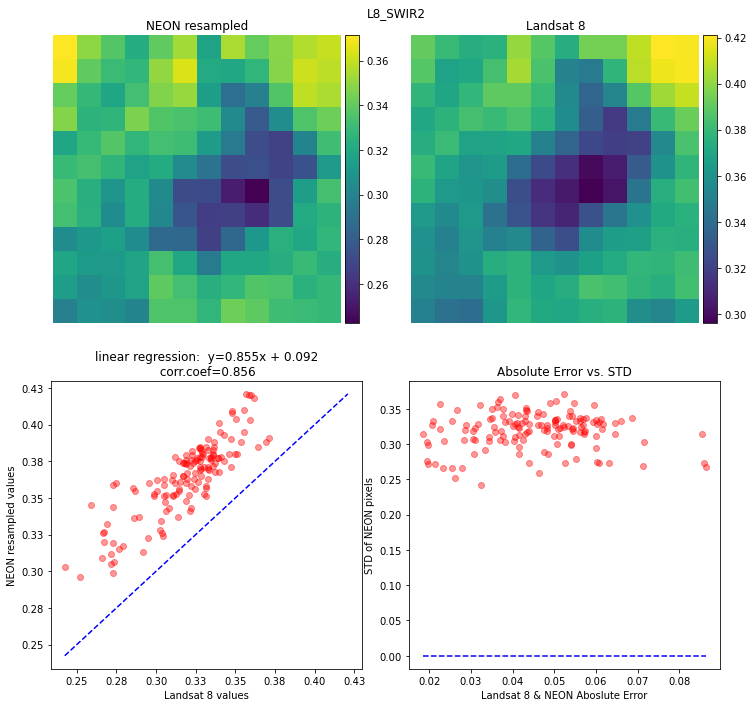

rectangular_patch_1
L8_Coastal 1


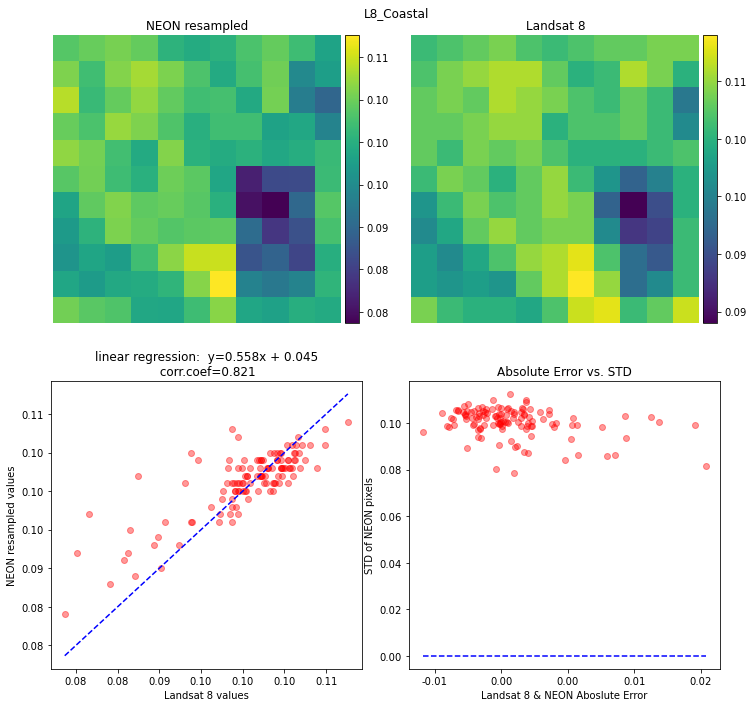

L8_Blue 2


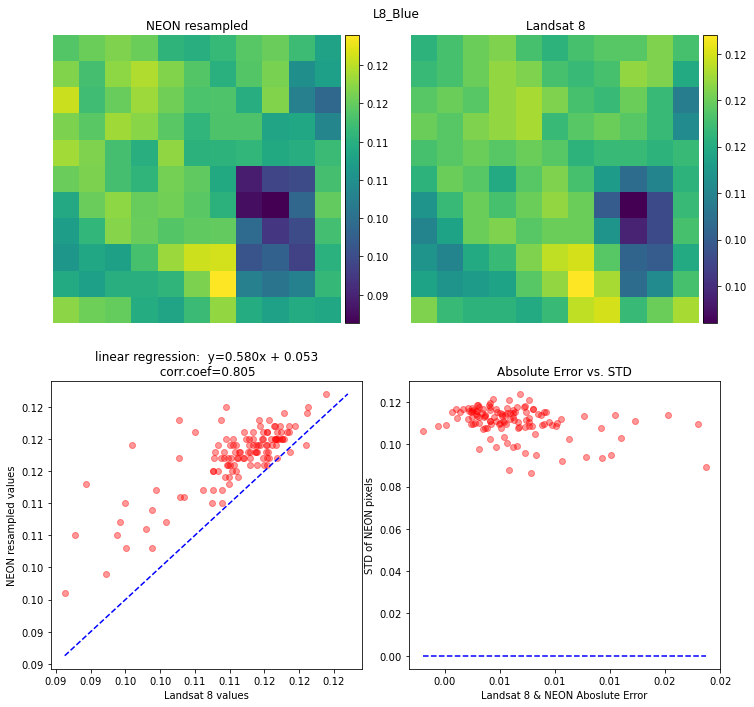

L8_Green 3


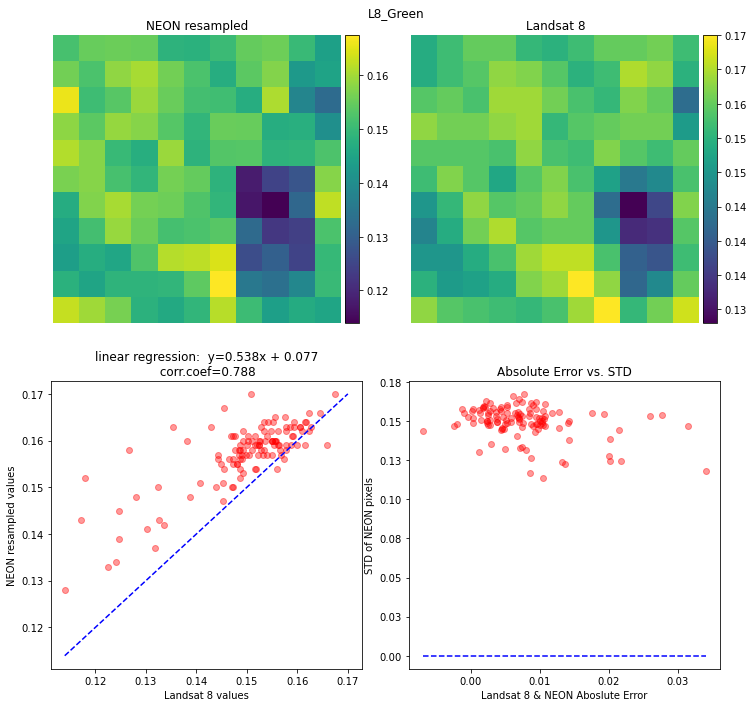

L8_Red 4


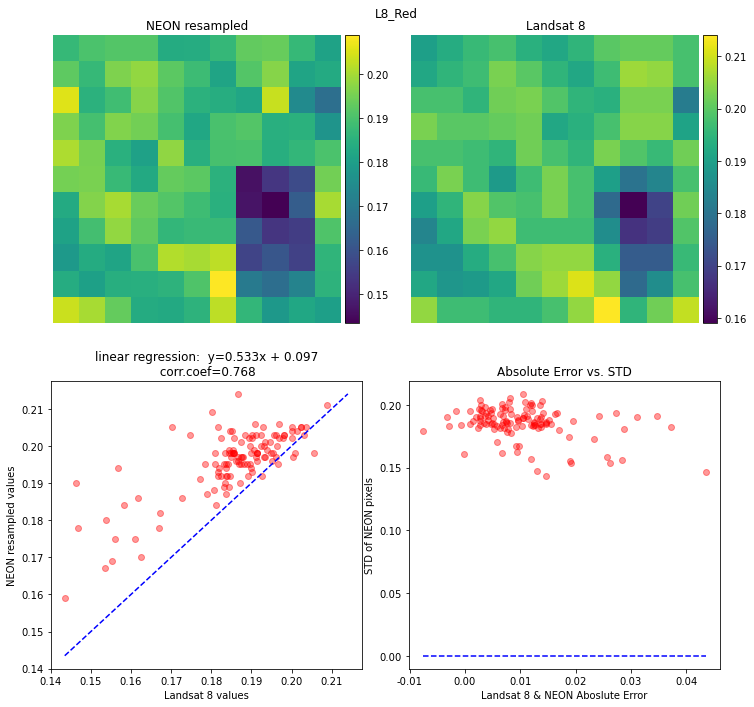

L8_NIR 5


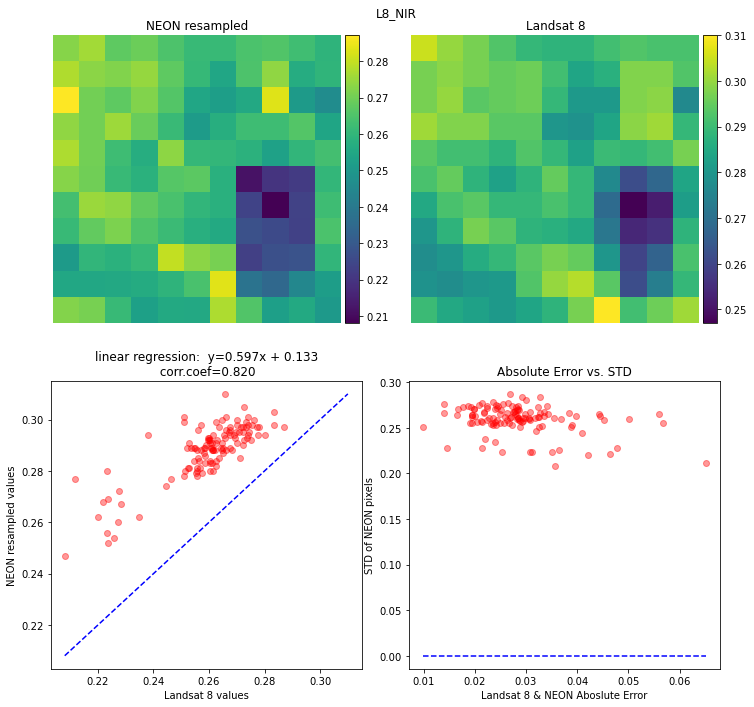

L8_SWIR1 6


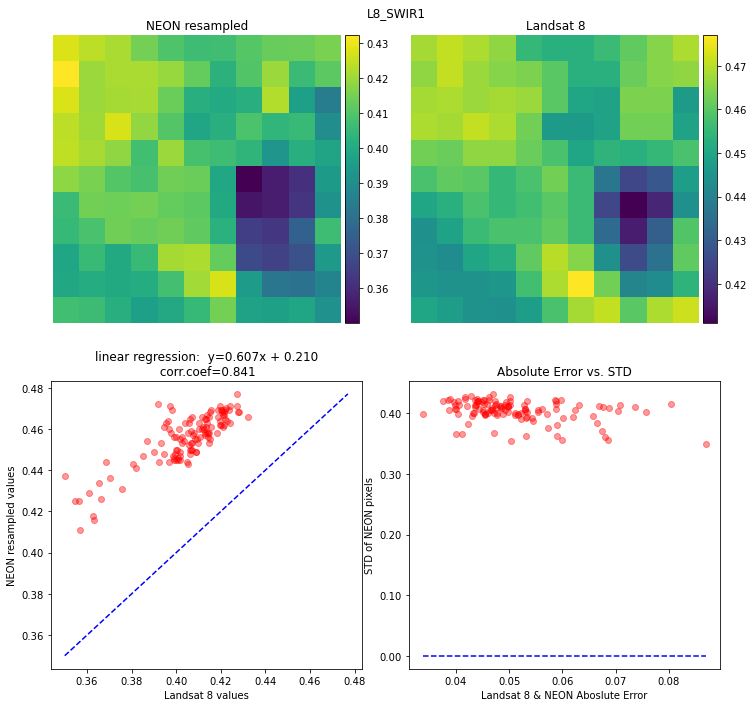

L8_SWIR2 7


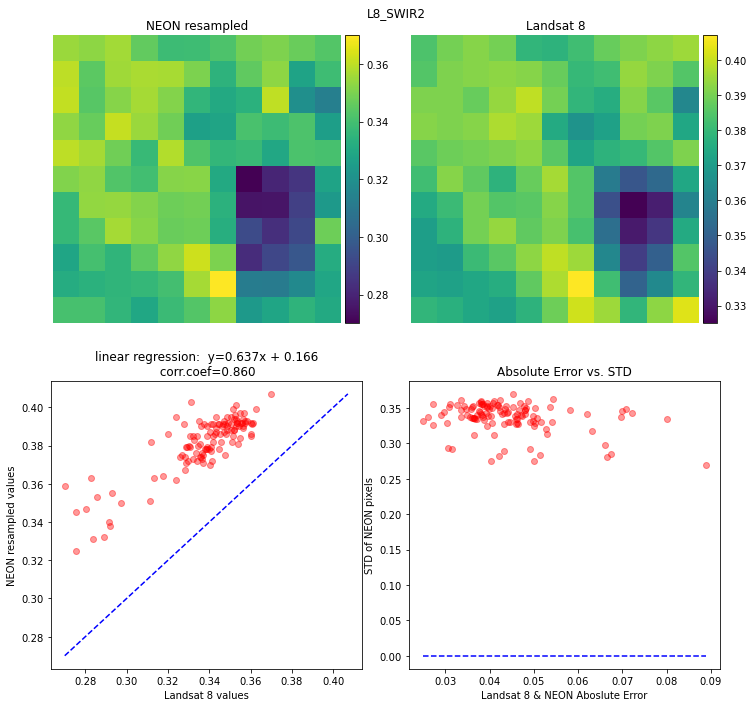

trees_1
L8_Coastal 1


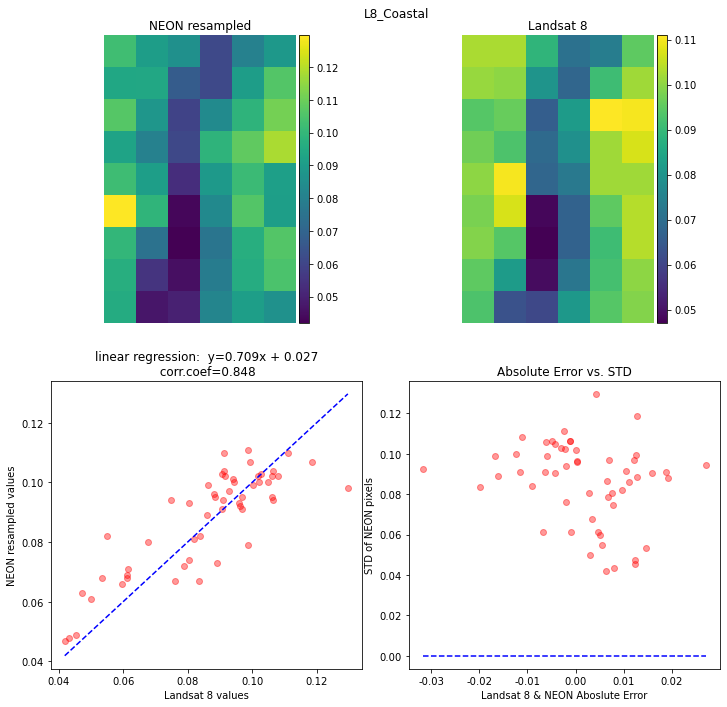

L8_Blue 2


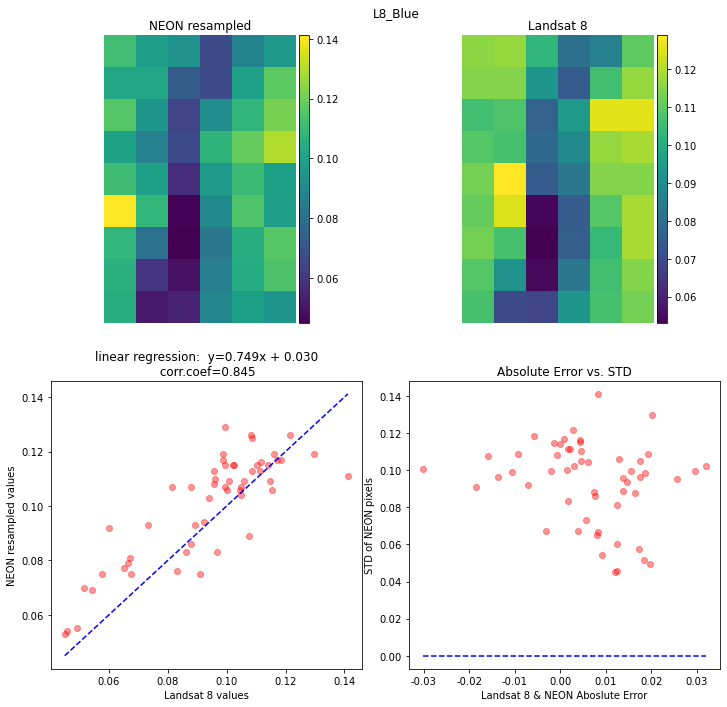

L8_Green 3


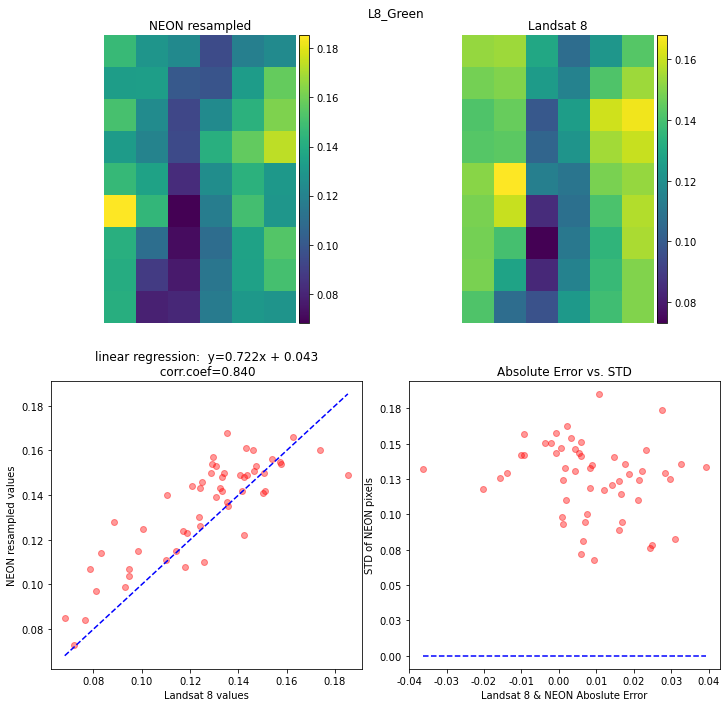

L8_Red 4


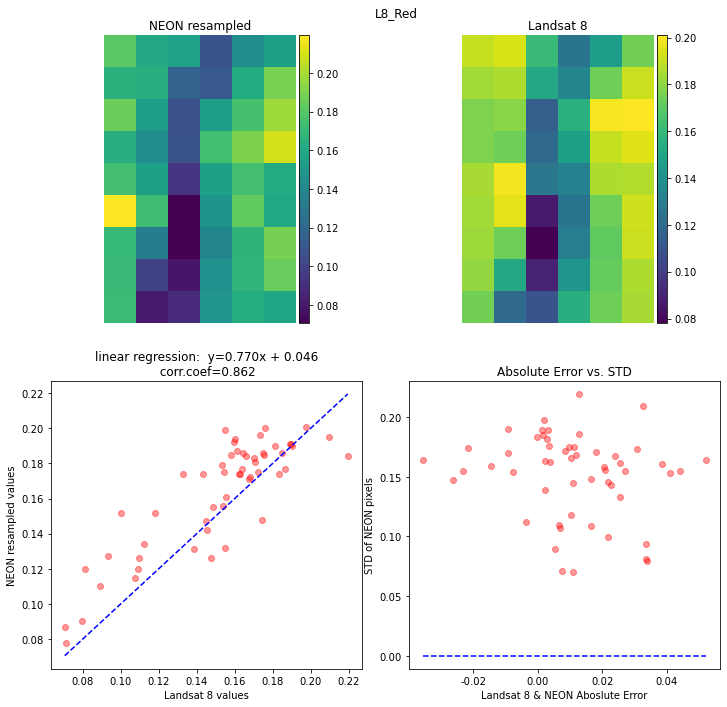

L8_NIR 5


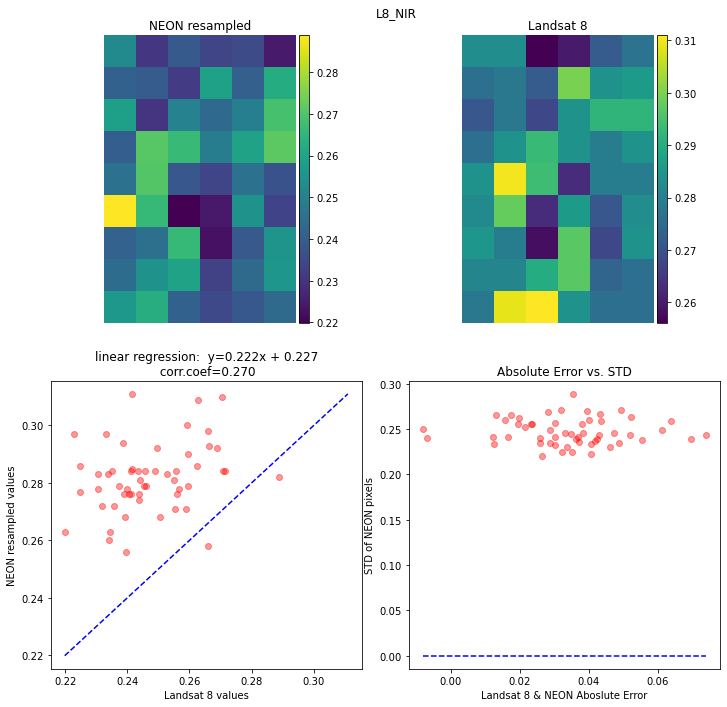

L8_SWIR1 6


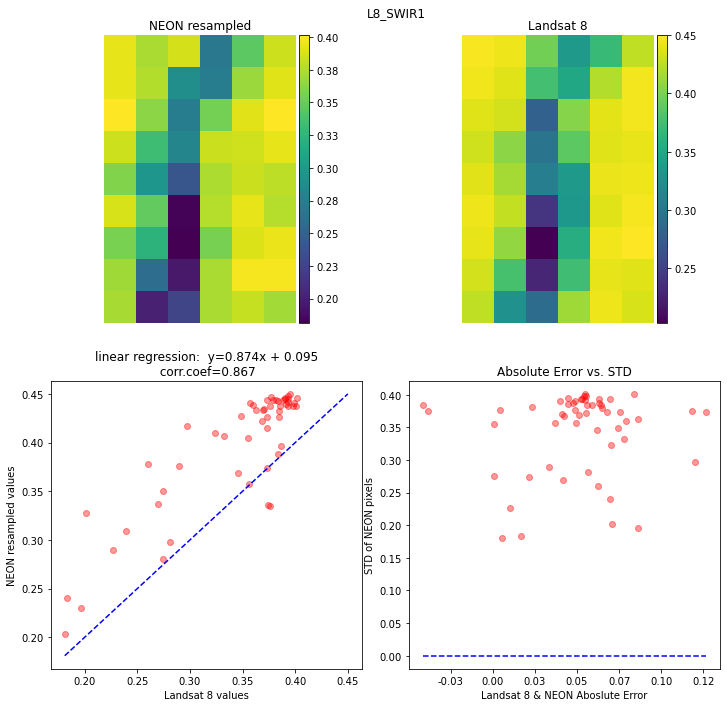

L8_SWIR2 7


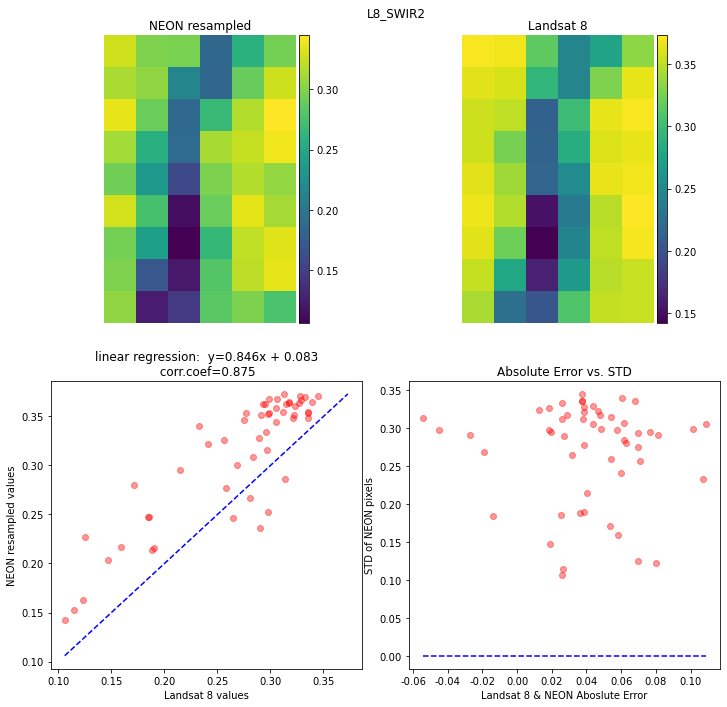

veg_1
L8_Coastal 1


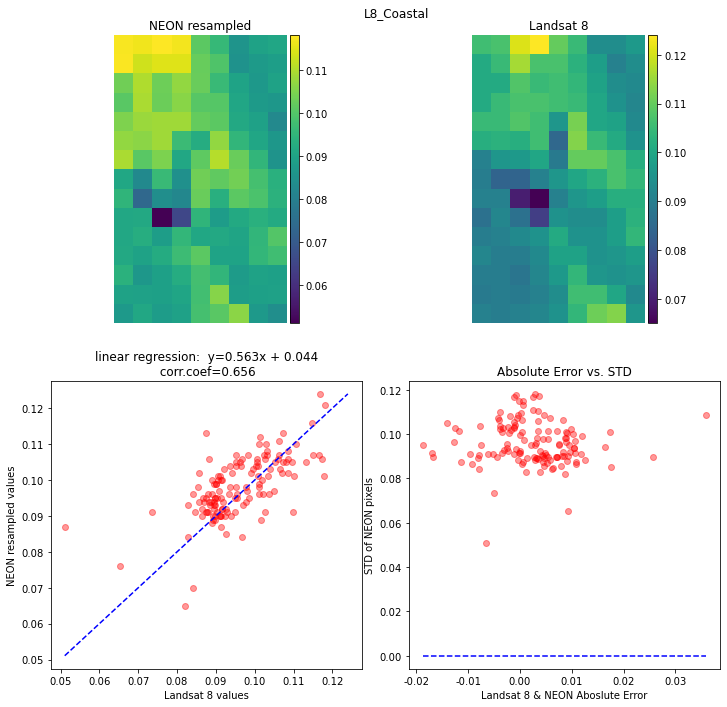

L8_Blue 2


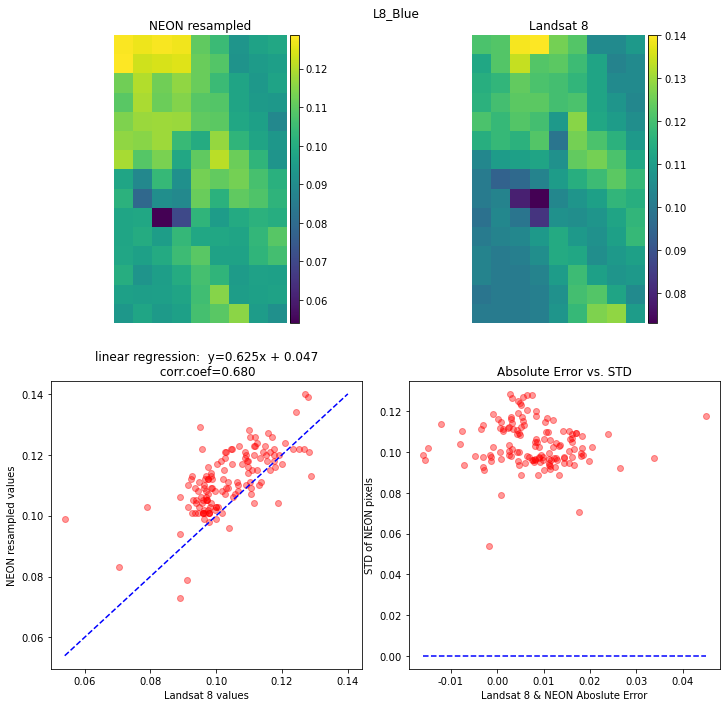

L8_Green 3


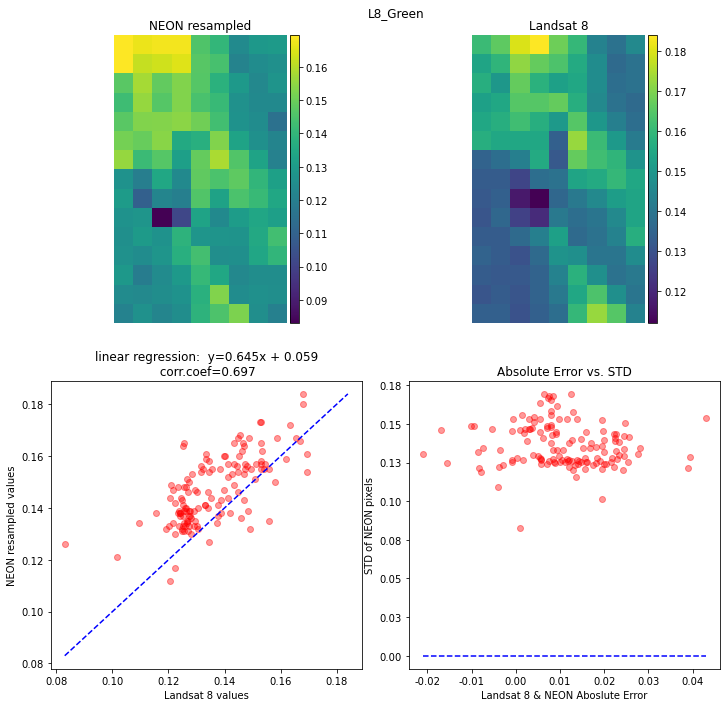

L8_Red 4


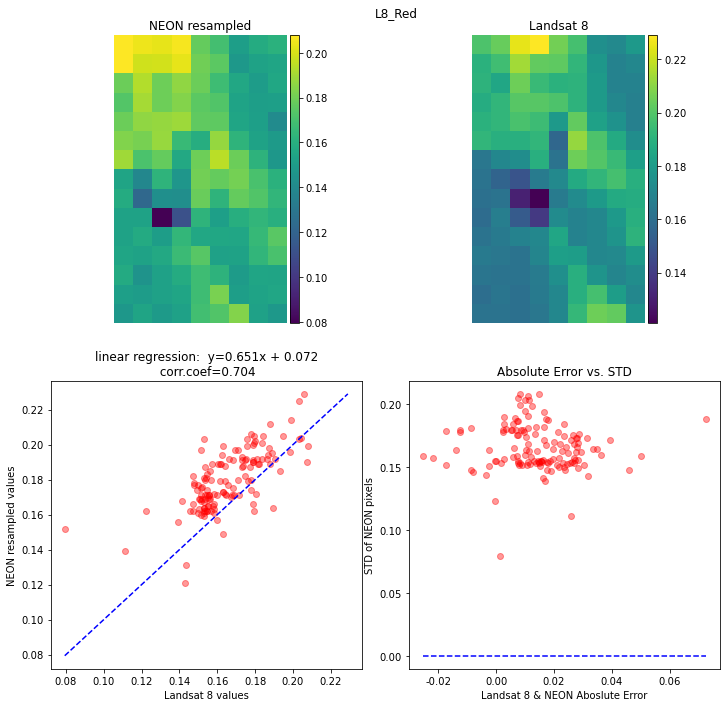

L8_NIR 5


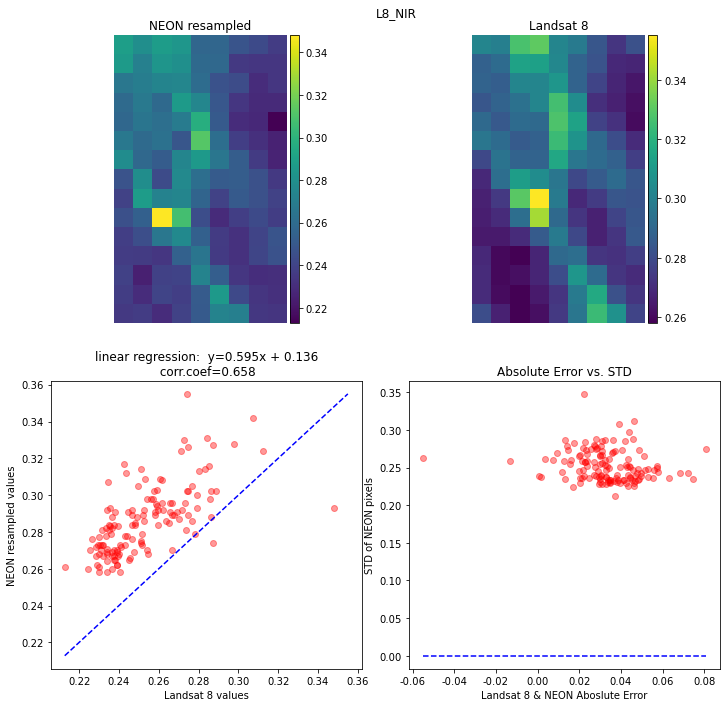

L8_SWIR1 6


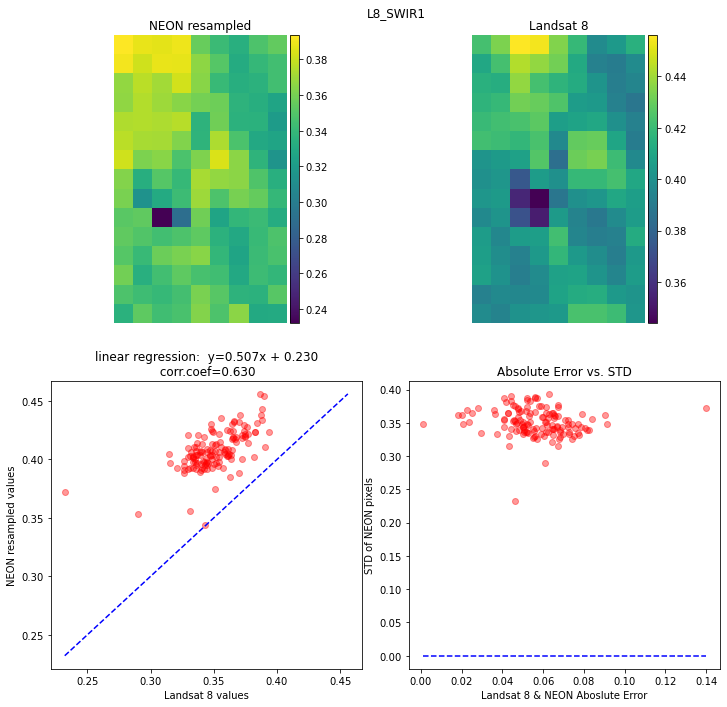

L8_SWIR2 7


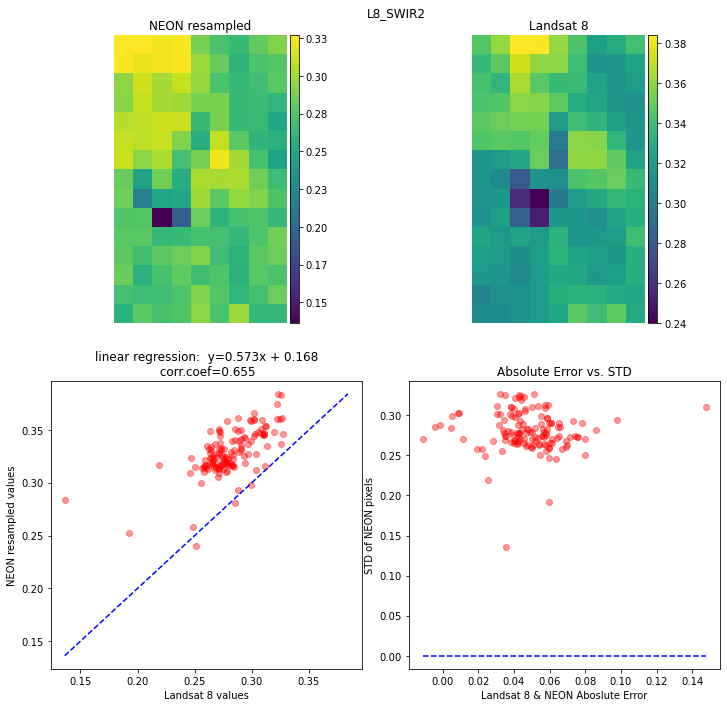

builtup_1
L8_Coastal 1


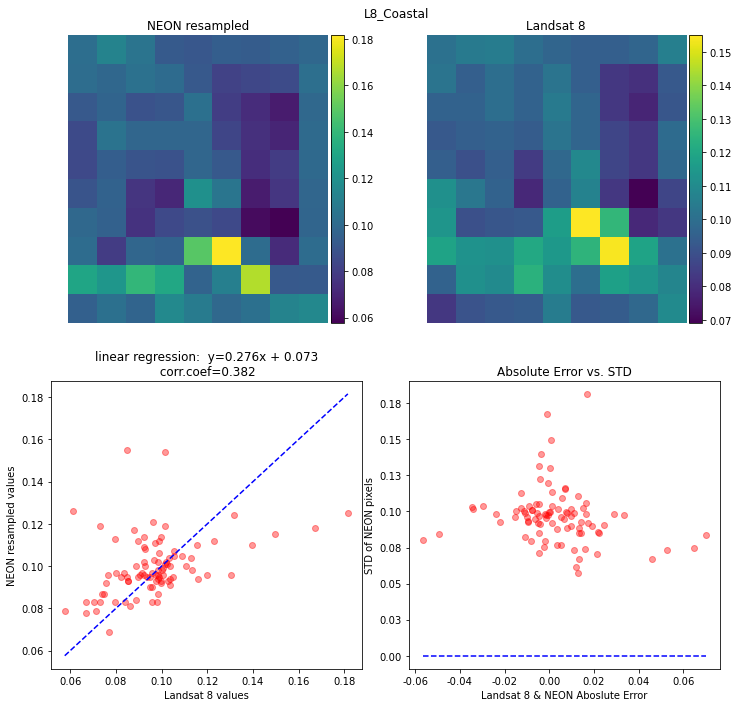

L8_Blue 2


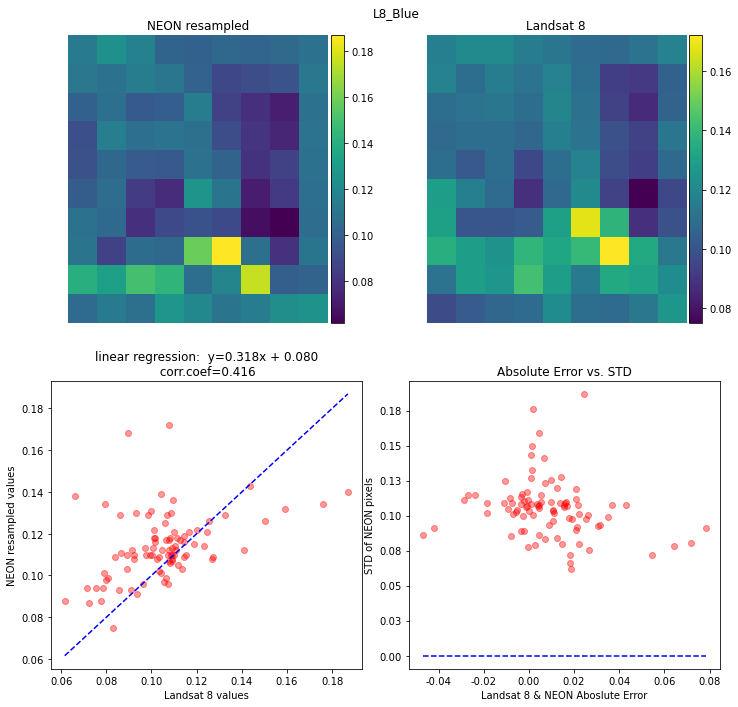

L8_Green 3


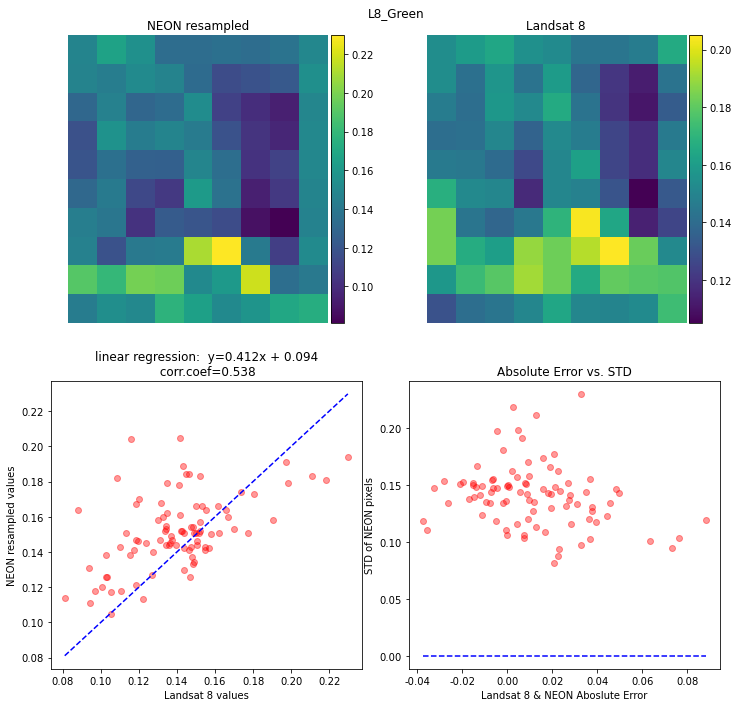

L8_Red 4


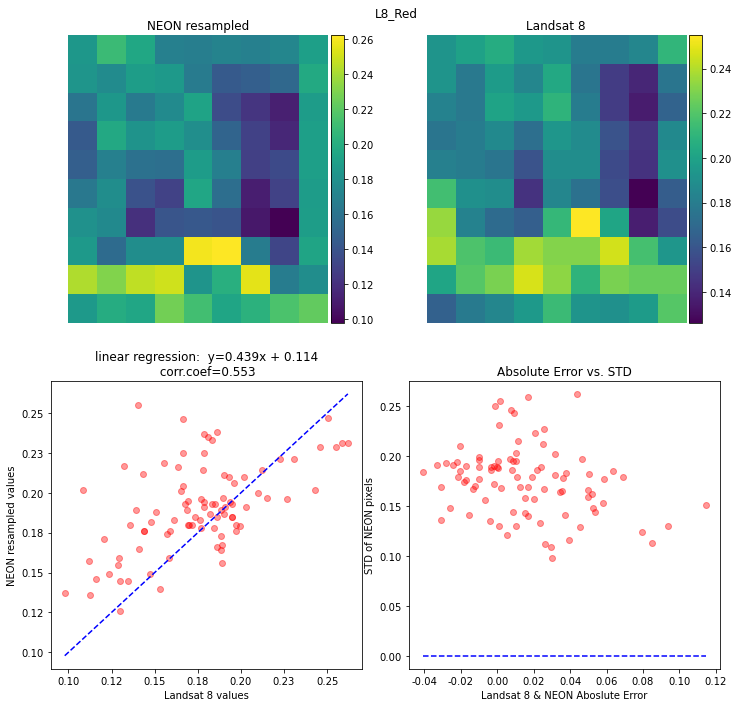

L8_NIR 5


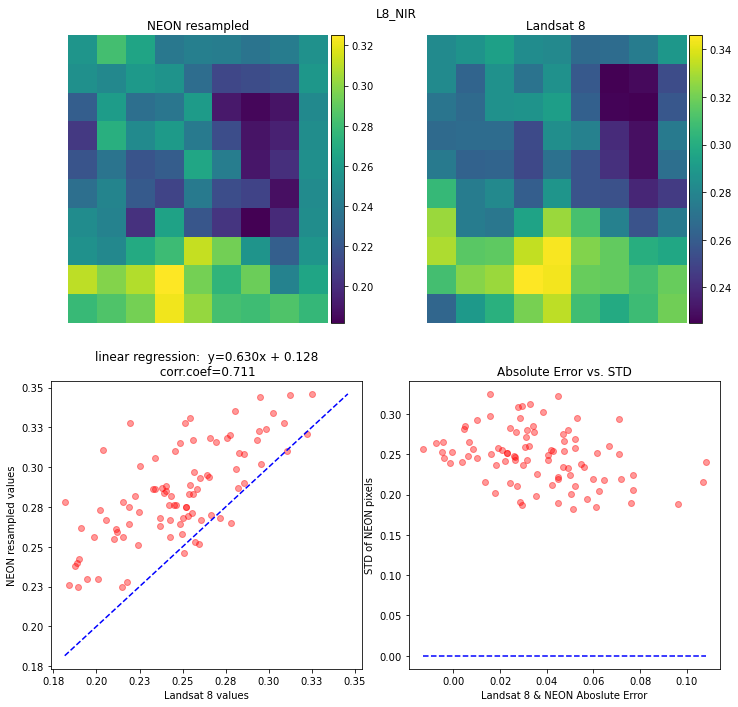

L8_SWIR1 6


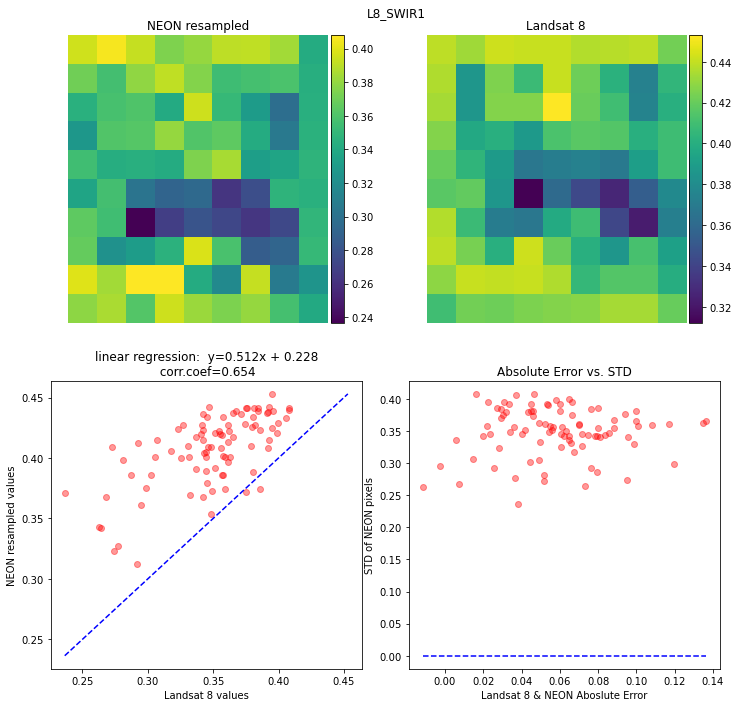

L8_SWIR2 7


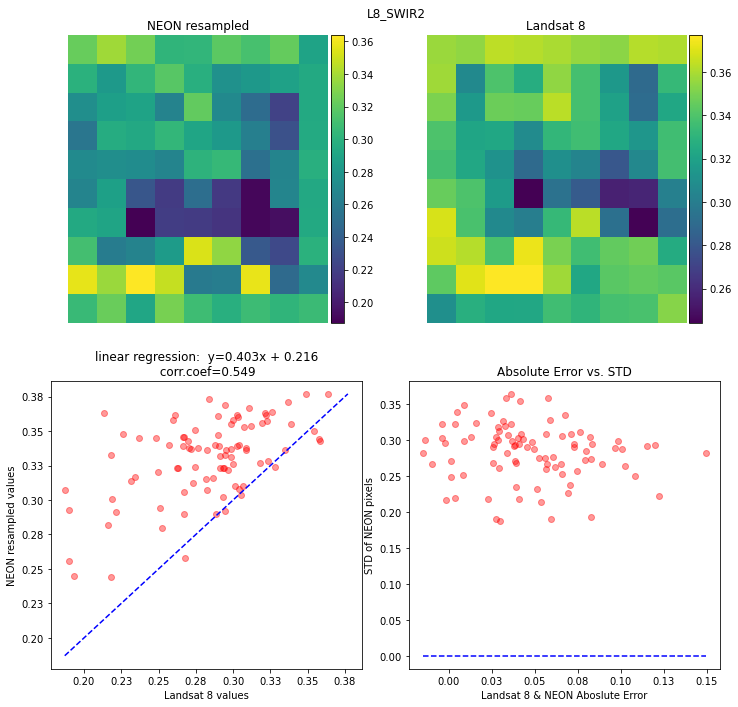

trees_2
L8_Coastal 1


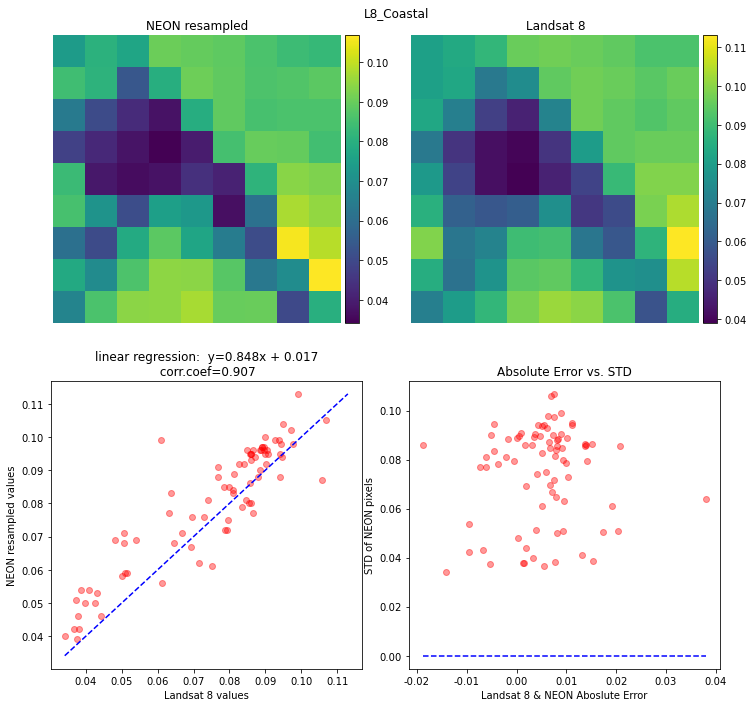

L8_Blue 2


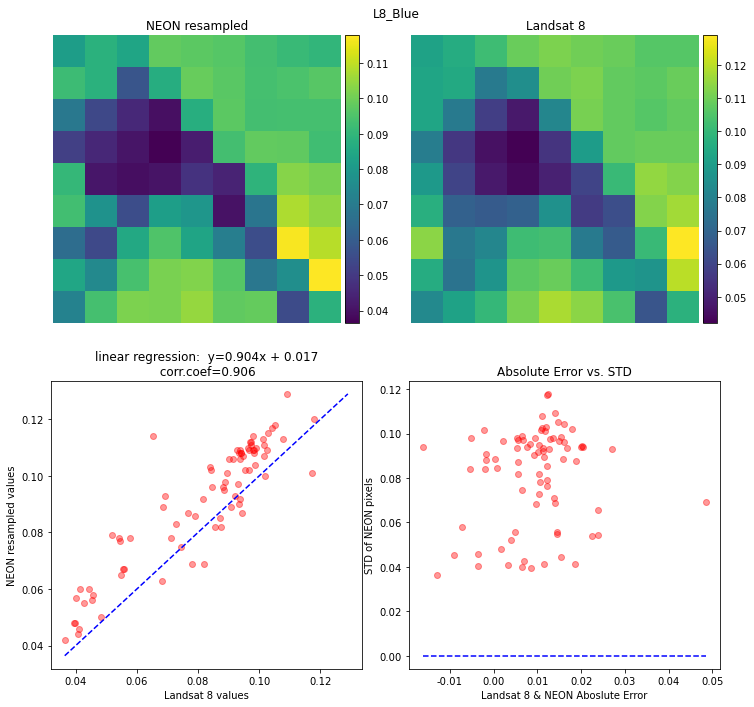

L8_Green 3


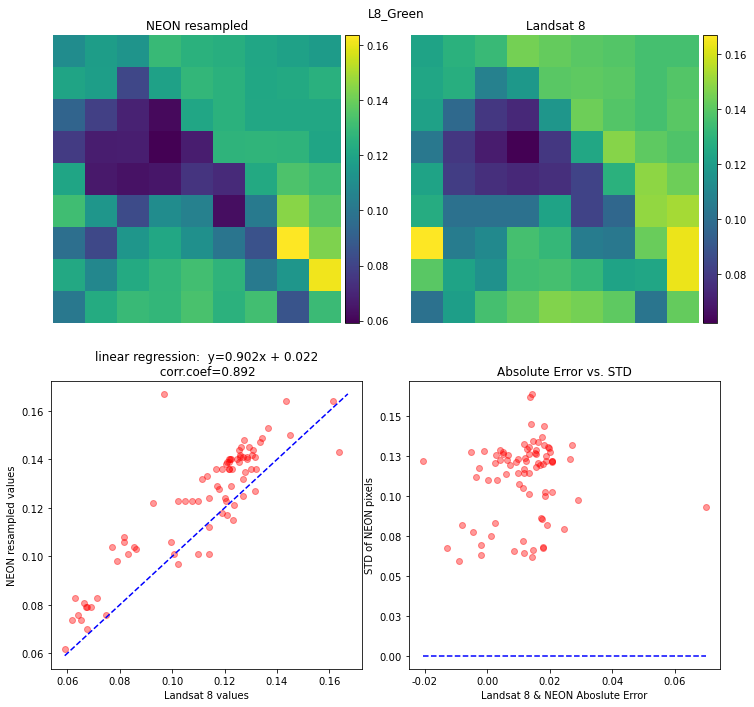

L8_Red 4


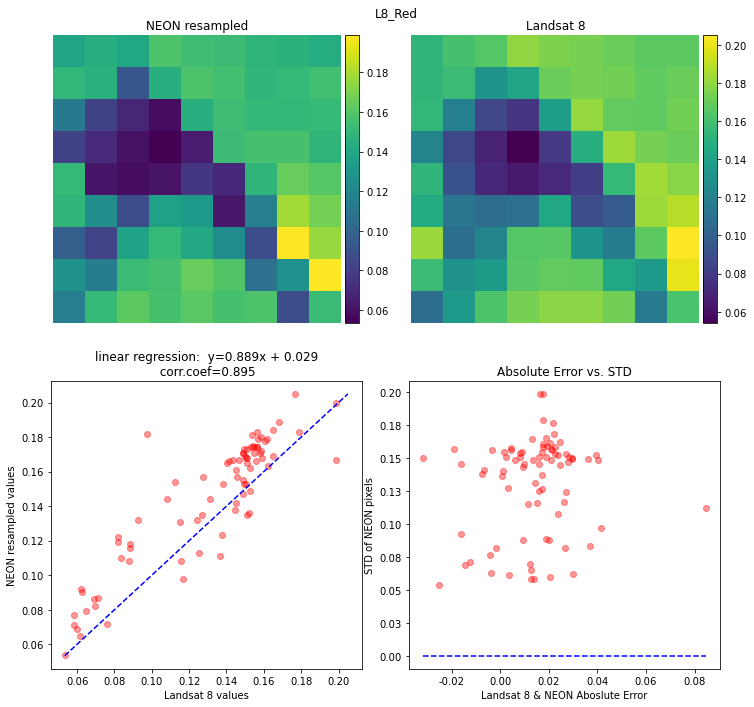

L8_NIR 5


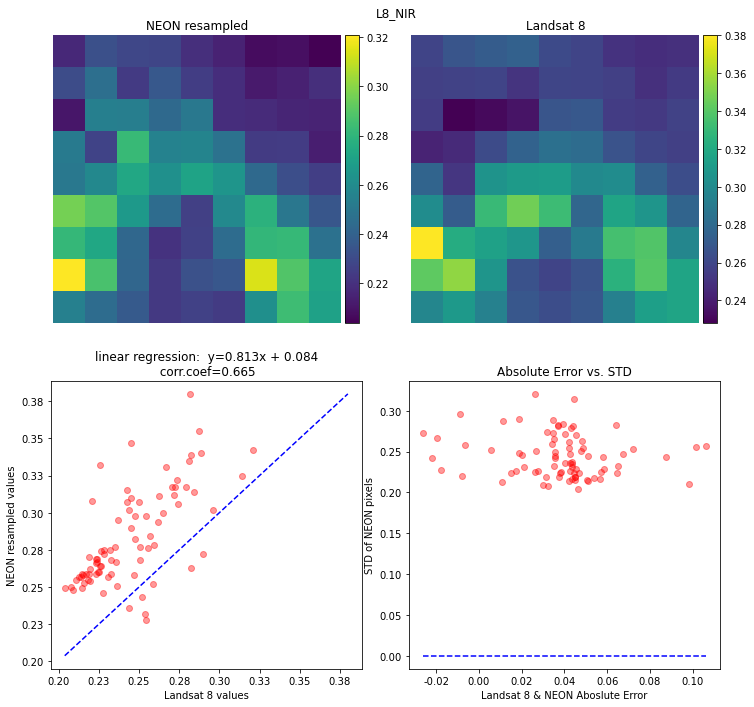

L8_SWIR1 6


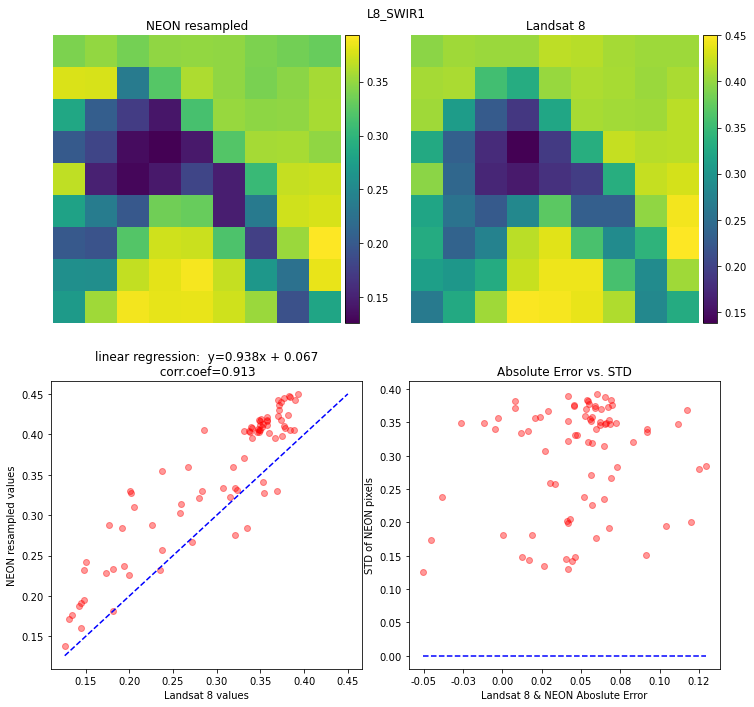

L8_SWIR2 7


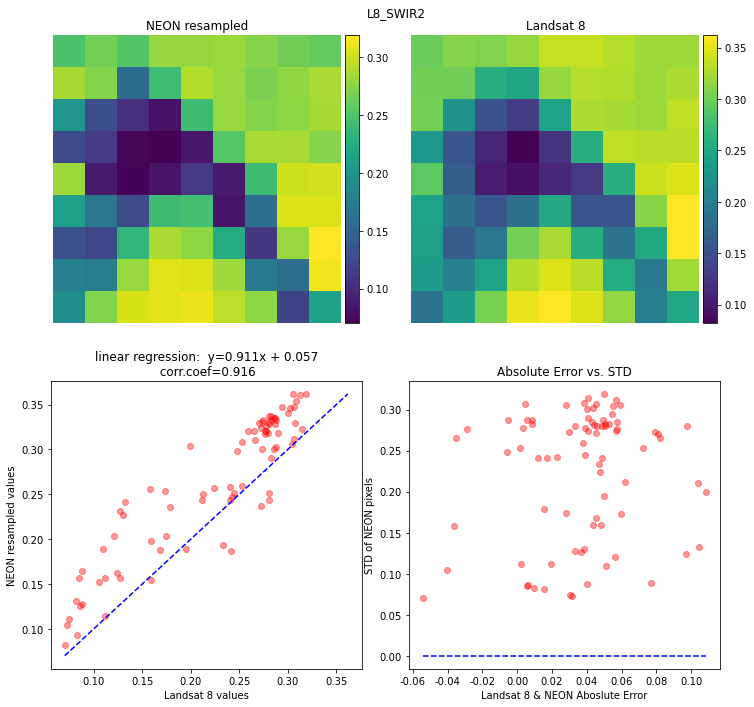

In [75]:
# plot Sentinel-2 8 ndvi for AOIs
for desc, neon_L8, og_L8, neon_L8_std in zip(aoi_gdf.dropna().desc.values, res_L8_means, L8_arrs, res_L8_stds):
    
    print(desc)
    if 'tarp' in desc:
        print('tarp is too small, skip it...')
        continue
        
    # iterate through the bands
    for nband, sband in zip(neon_L8.sat_band.values, og_L8.band.values):
        print(nband, sband)
        
        # select the bands from the data
        neon_band = neon_L8.sel(sat_band=nband)
        satl_band = og_L8.sel(band=sband).astype('float')/1000 #arcsi scale factor is 1000
        neon_std = neon_L8.sel(sat_band=nband)
        
        # extract values
        neon_band_vals = np.flipud(neon_band.values)
        satl_band_vals = satl_band.values
        neon_std_vals = neon_std.values
        
        # mask bad values
        neon_band_vals = np.ma.masked_greater(neon_band_vals, 1)
        satl_band_vals = np.ma.masked_greater(satl_band_vals, 1)
        
        # get shapes
        neon_shape = neon_band_vals.shape
        sat_shape = satl_band_vals.shape

        # if shape is too small, don't plot it
        if 1 in np.array([neon_shape] + [sat_shape]):
            print('array is too small for anything, continuing...')
            continue

        # slice if necessary
        if neon_shape[0] < sat_shape[0]:
            satl_band_vals = satl_band_vals[:neon_shape[0],:]

        if neon_shape[1] < sat_shape[1]:
            satl_band_vals = satl_band_vals[:, :neon_shape[1]]

        if neon_shape[0] > sat_shape[0]:
            neon_band_vals = neon_band_vals[:sat_shape[0],:]
            neon_std_vals = neon_std_vals[:sat_shape[0], :]

        if neon_shape[1] > sat_shape[1]:
            neon_band_vals = neon_band_vals[:, :sat_shape[1]]
            neon_std_vals = neon_std_vals[:, :sat_shape[1]]


        # linear regression piece
        x = np.ma.masked_invalid(neon_band_vals.flatten())
        y = np.ma.masked_invalid(satl_band_vals.flatten())
        slope, intercept, r, p, se = linregress(x, y)
        
        
        # get the correlation coefficient
        corr = np.ma.corrcoef(np.ma.masked_invalid(neon_band_vals.flatten()), 
                              np.ma.masked_invalid(satl_band_vals.flatten()))[0,1]
    
        ############### PLOTTING ##################
        # plot the images and scatter plots
        fig, ax = plt.subplots(2,2, figsize=(10,10))
        fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.15)

        ## NEON resampled band
        im = ax[0,0].imshow(neon_band_vals)
        
        divider = make_axes_locatable(ax[0,0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, format=FormatStrFormatter('%.2f'))
        
        #fig.colorbar(im, ax=ax[0,0])
        ax[0,0].set_title('NEON resampled')
        ax[0,0].axis('off')

        ## Satellite band
        im = ax[0,1].imshow(satl_band_vals)
        
        divider = make_axes_locatable(ax[0,1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, format=FormatStrFormatter('%.2f'))
        
        #fig.colorbar(im, ax=ax[0,1])
        ax[0,1].set_title('Landsat 8')
        ax[0,1].axis('off')

        ## Scatter plot of resampled NEON mean value and satellite band
        #im = ax[1,0].scatter(neon_band_vals.flatten(), satl_band_vals.flatten(), alpha=0.4, color='r')
        im = ax[1,0].scatter(x, y, alpha=0.4, color='r')
        ax[1,0].set_title('Landsat 8 vs. NEON means')
        ax[1,0].set_xlabel('Landsat 8 values')
        ax[1,0].set_ylabel('NEON resampled values')
        ax[1,0].set_title(f'linear regression:  y={slope:0.3f}x + {intercept:0.3f}\n corr.coef={corr:0.3f}')
        
        ## plot 1:1 line
        minval = min(x.min(), y.min())
        maxval = max(x.max(), y.max())
        ax[1,0].plot([minval, maxval], [minval, maxval], 'b--')
        
        ax[1,0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        ## Scatter plot of difference values vs. std for that pixel
        ax[1,1].scatter(satl_band_vals.flatten() - neon_band_vals.flatten(), neon_std_vals.flatten(), alpha=0.4, color='r')
        ax[1,1].set_xlabel('Landsat 8 & NEON Aboslute Error')
        ax[1,1].set_ylabel('STD of NEON pixels')
        ax[1,1].set_title(f'Absolute Error vs. STD')
        
        ## plot zero line line
        minval = (y-x).min()
        maxval = (y-x).max()
        ax[1,1].plot([minval, maxval], [0,0], 'b--')
        
        ax[1,1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax[1,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        
        fig.suptitle(nband)
        plt.show()


## Sentinel-2

In [81]:
n_s2_ids = neon_S2.sat_band.values[[1,2,3,4,5,6,7,8,11,12]]
n_s2_ids

array(['S2A_B2', 'S2A_B3', 'S2A_B4', 'S2A_B5', 'S2A_B6', 'S2A_B7',
       'S2A_B8', 'S2A_B8A', 'S2A_B11', 'S2A_B12'], dtype='<U7')

tarp_outline_1
tarp is too small, skip it...
tarp_outline_2
tarp is too small, skip it...
pond_1
S2A_B2 1


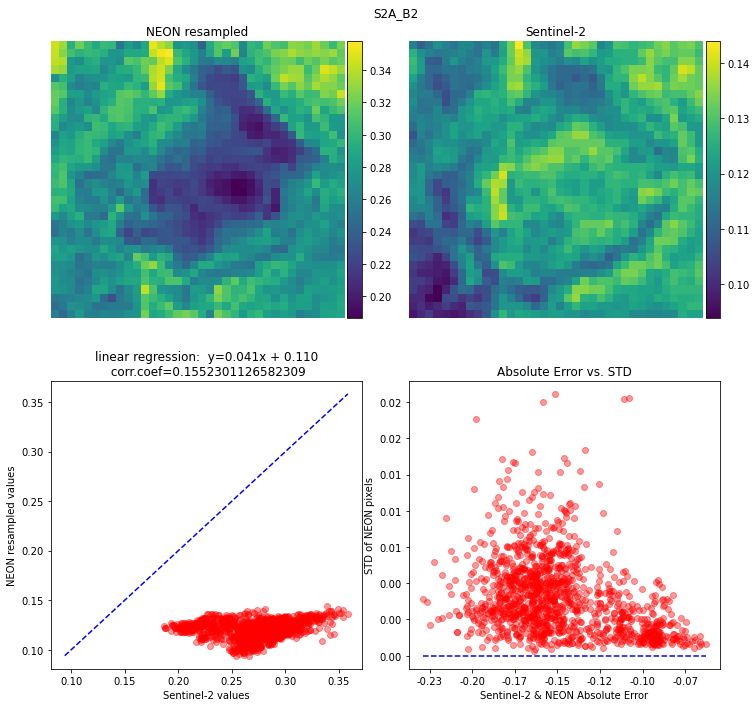

S2A_B3 2


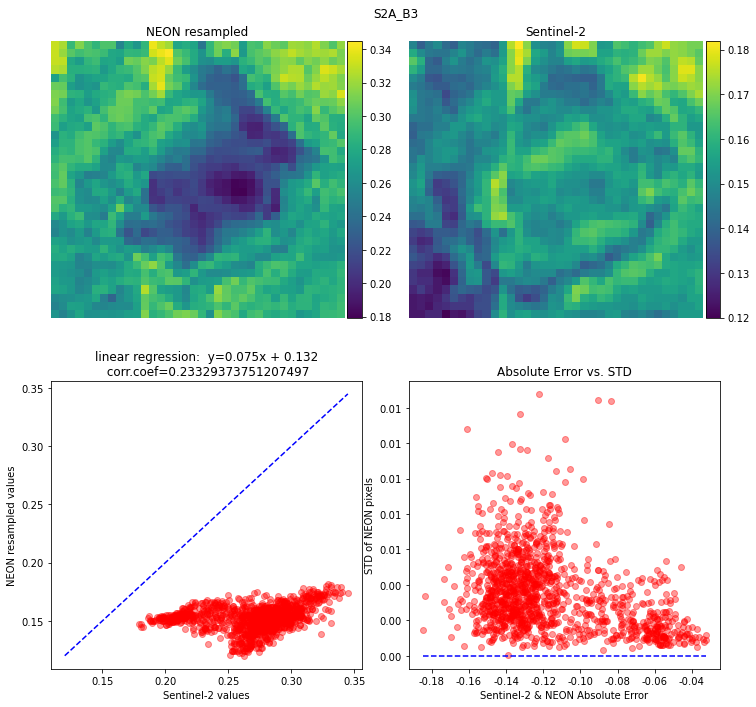

S2A_B4 3


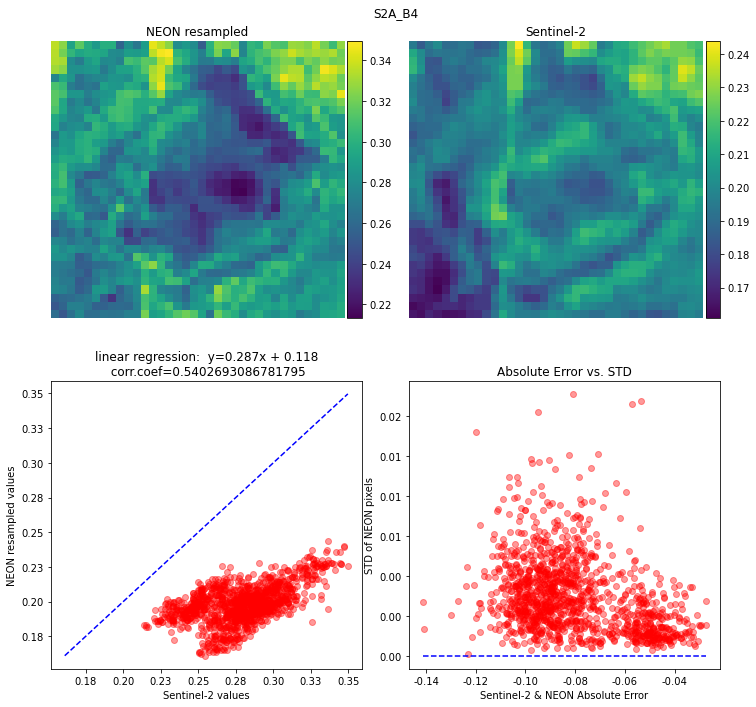

S2A_B5 4


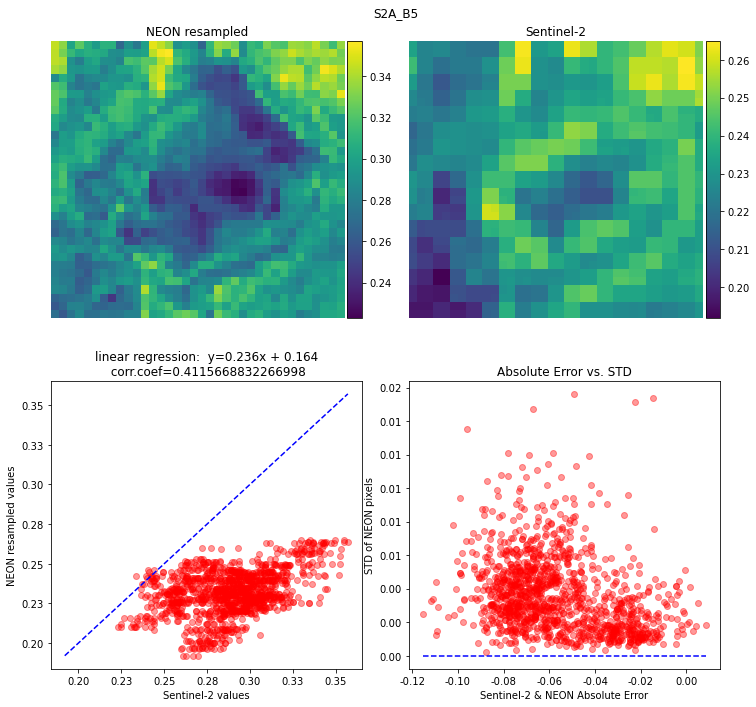

S2A_B6 5


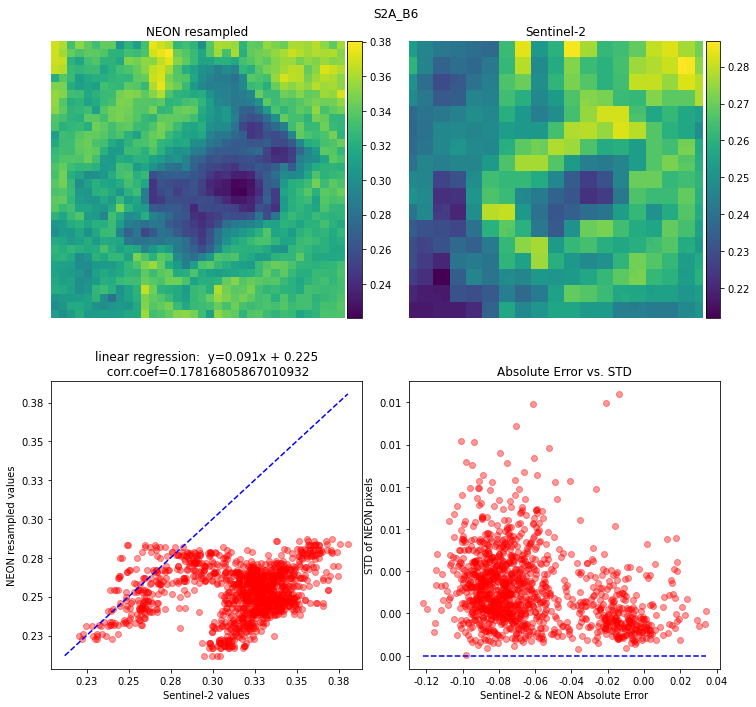

S2A_B7 6


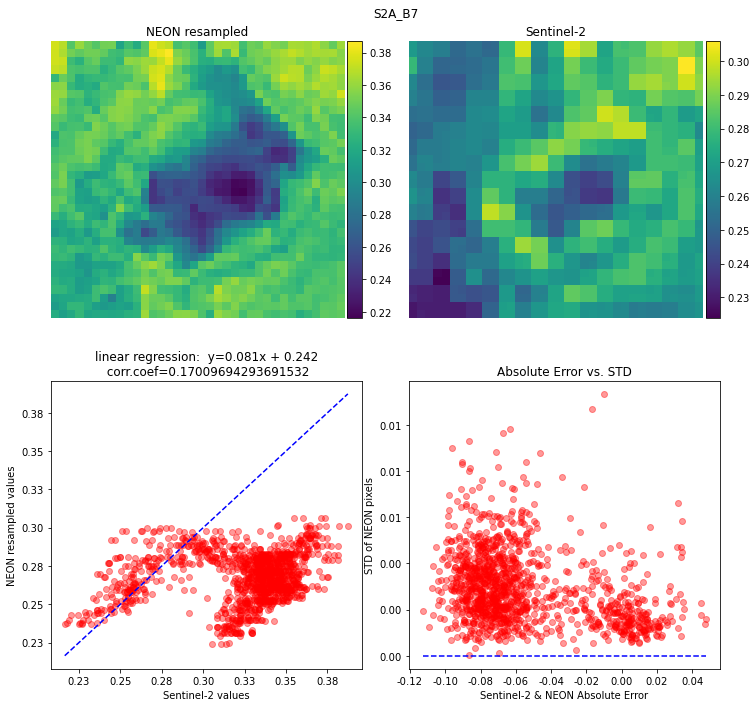

S2A_B8 7


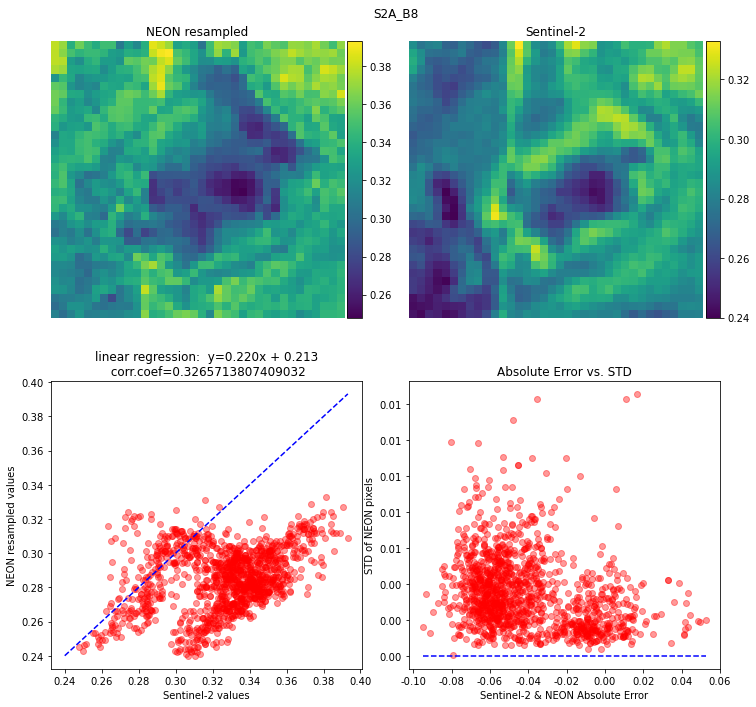

S2A_B8A 8


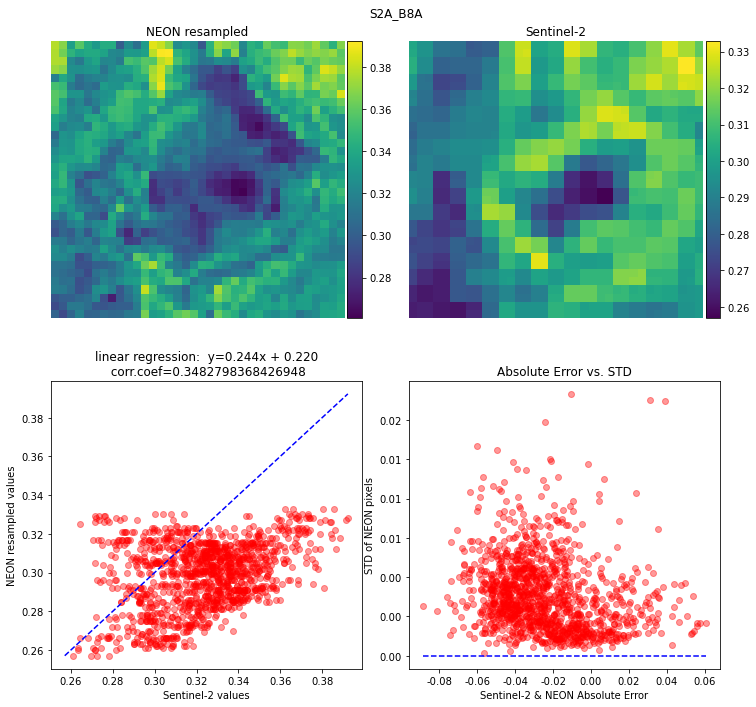

S2A_B11 9


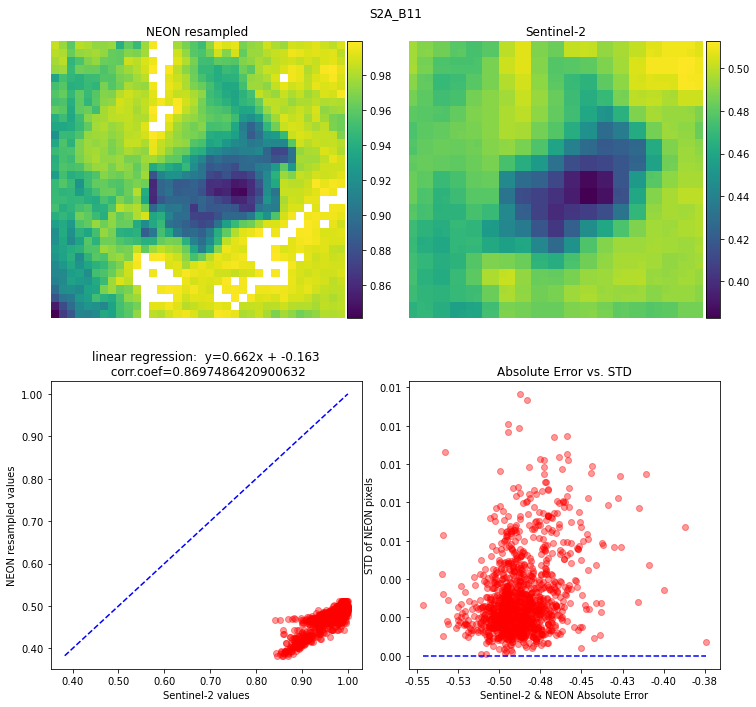

S2A_B12 10


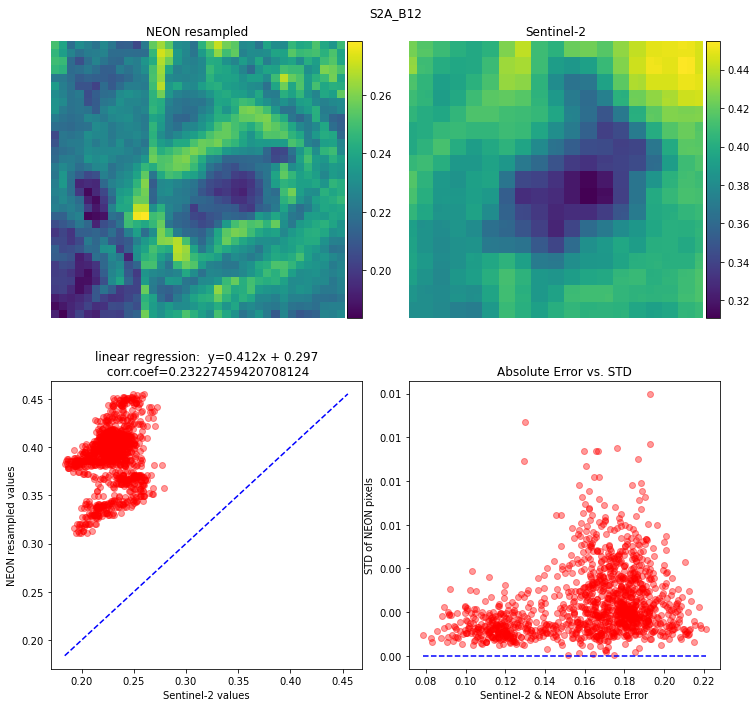

rectangular_patch_1
S2A_B2 1


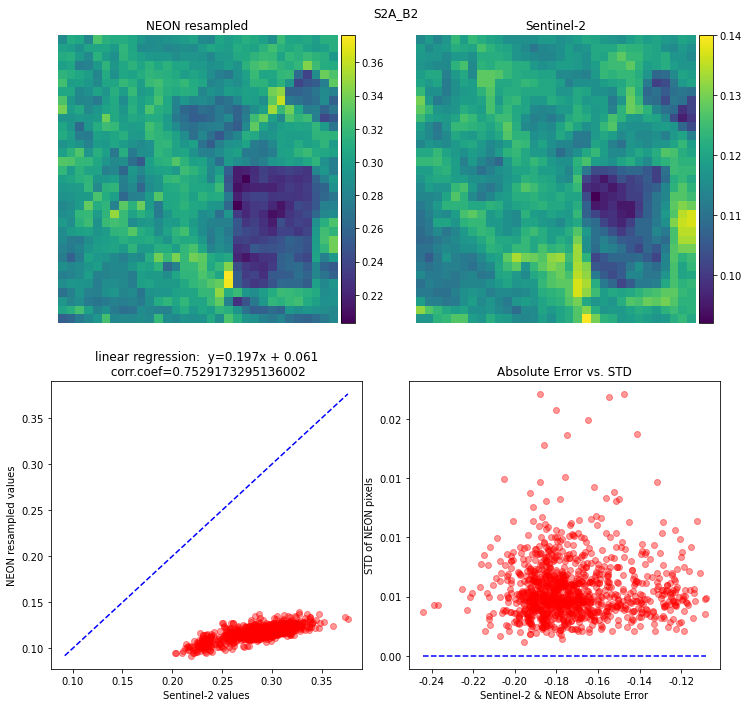

S2A_B3 2


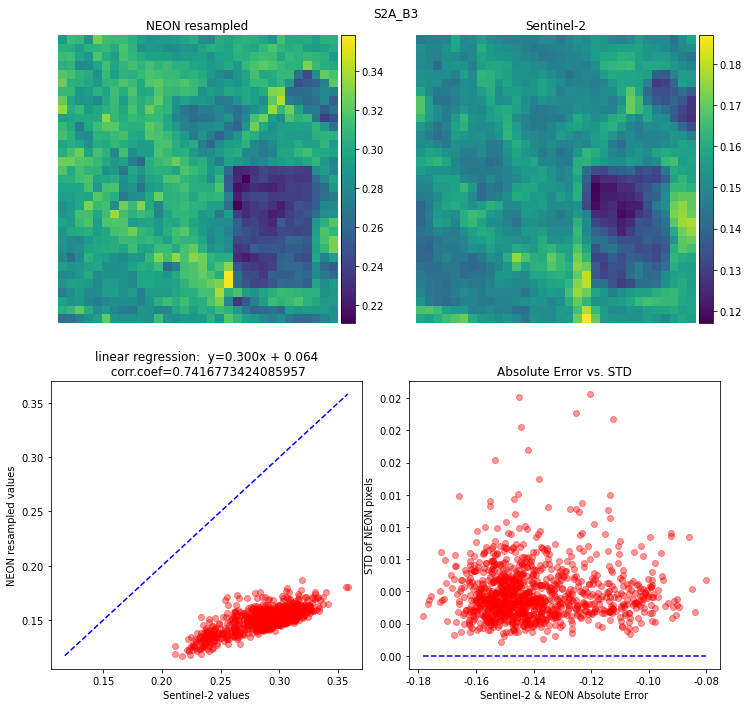

S2A_B4 3


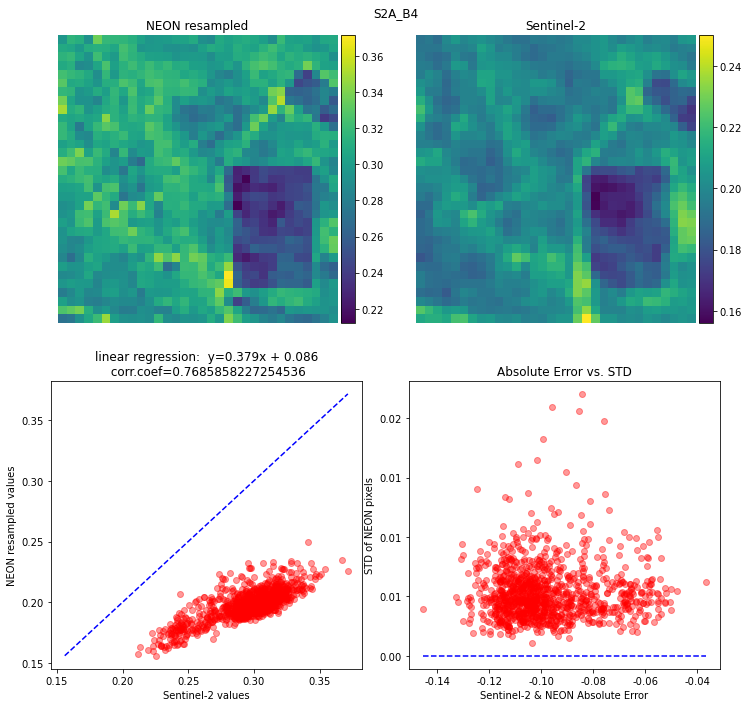

S2A_B5 4


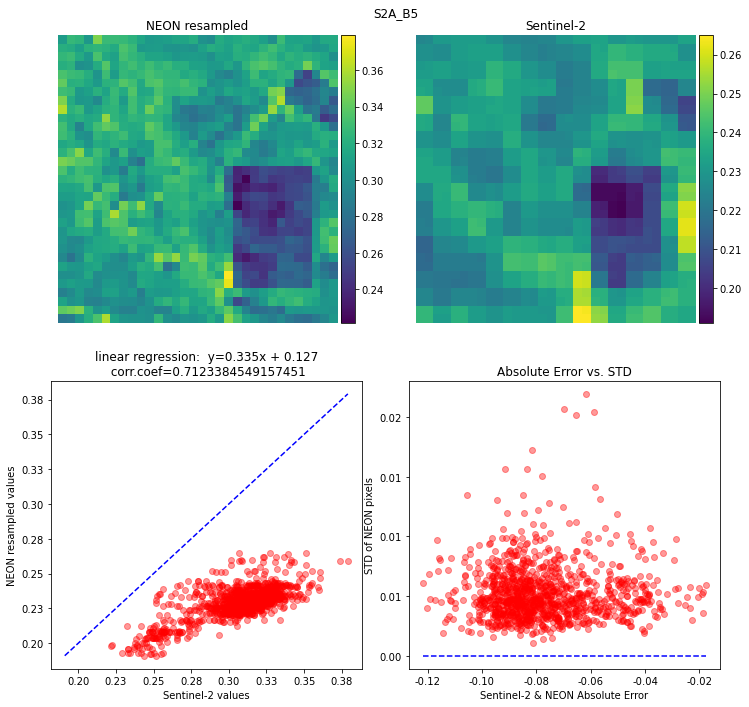

S2A_B6 5


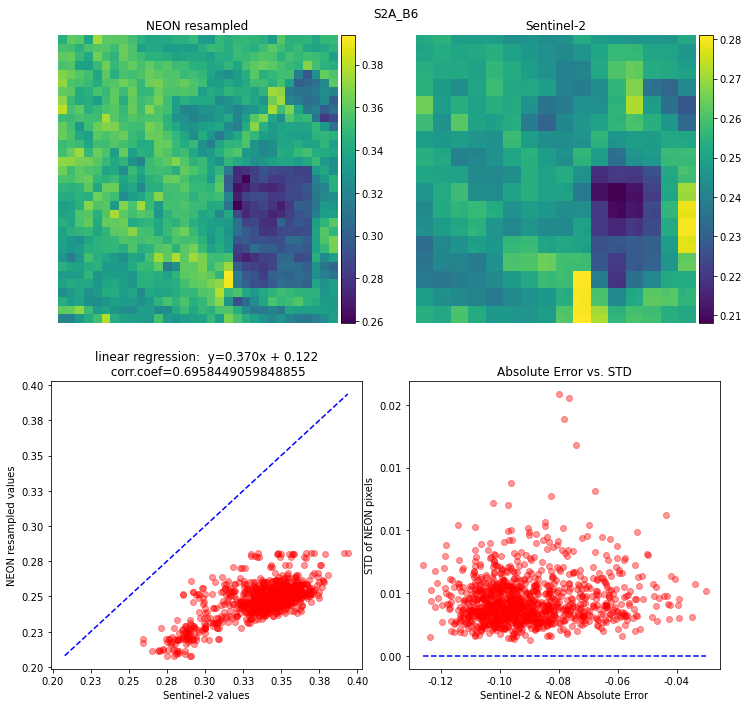

S2A_B7 6


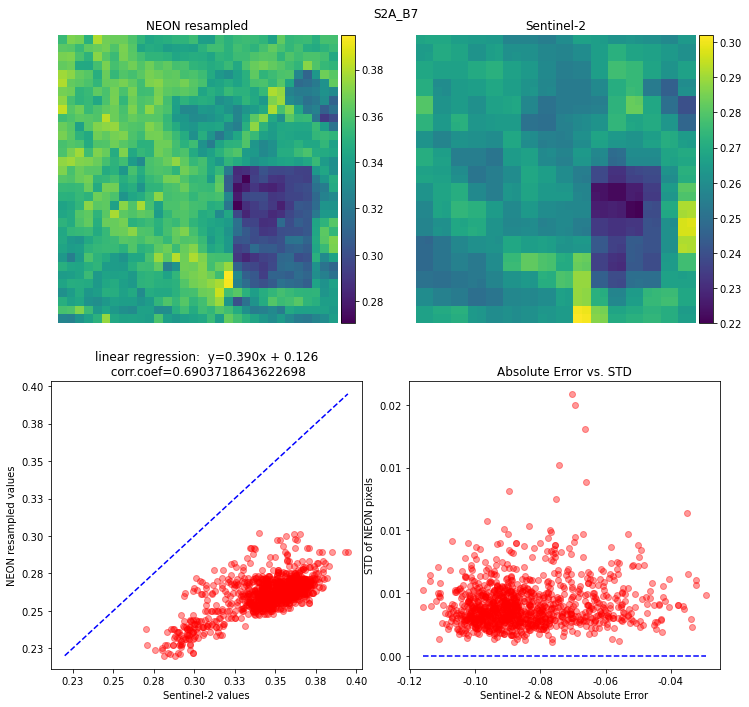

S2A_B8 7


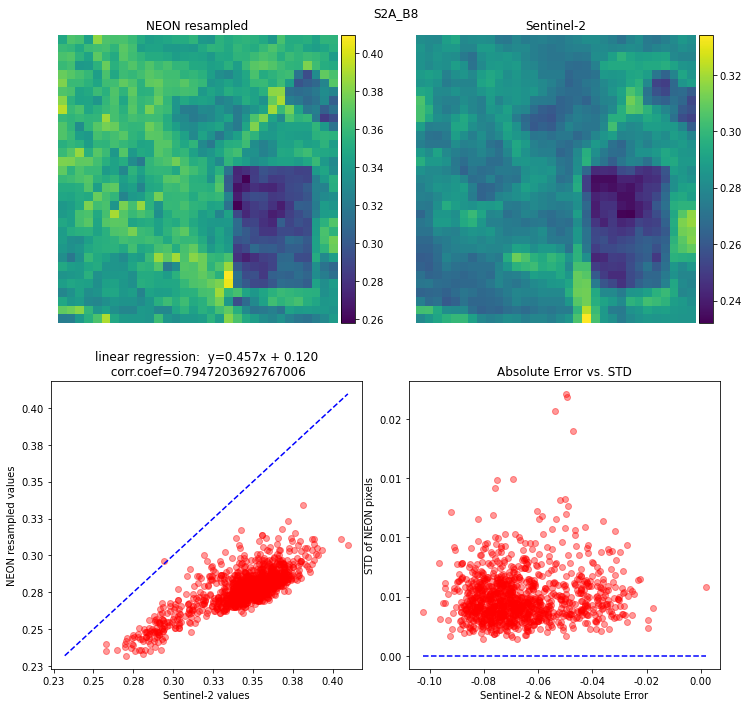

S2A_B8A 8


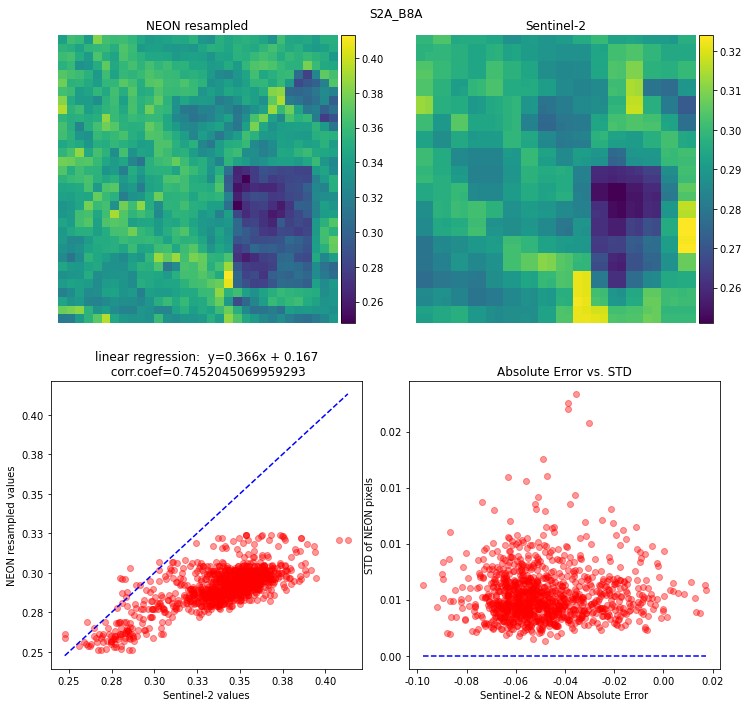

S2A_B11 9


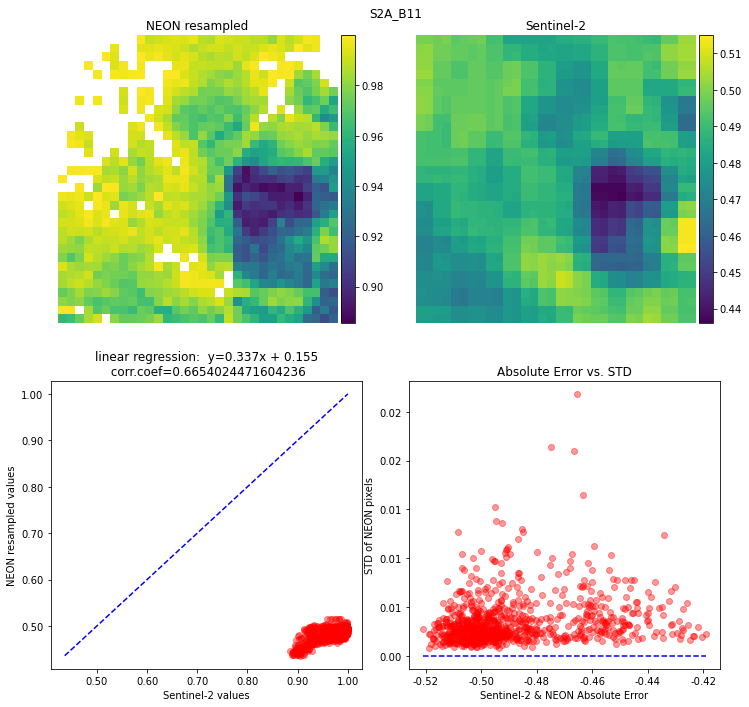

S2A_B12 10


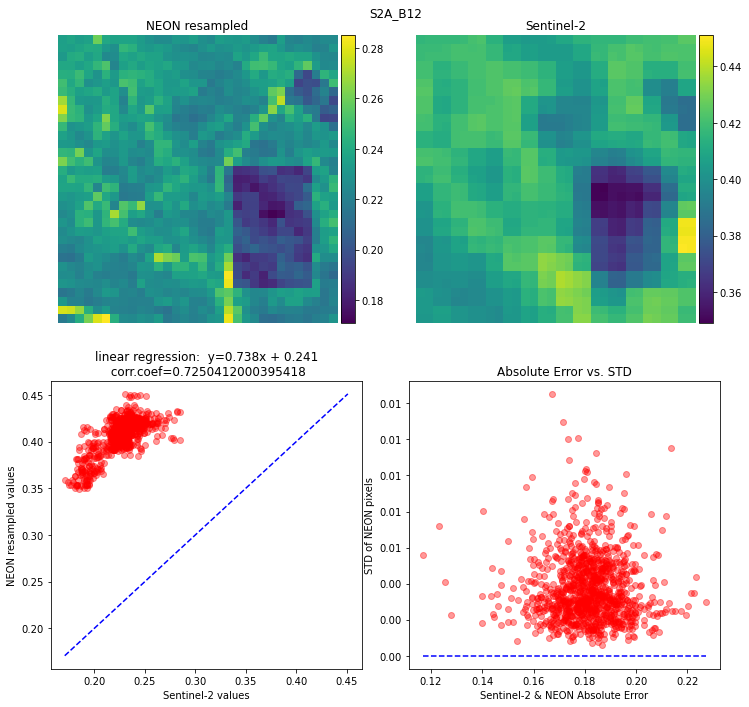

trees_1
S2A_B2 1


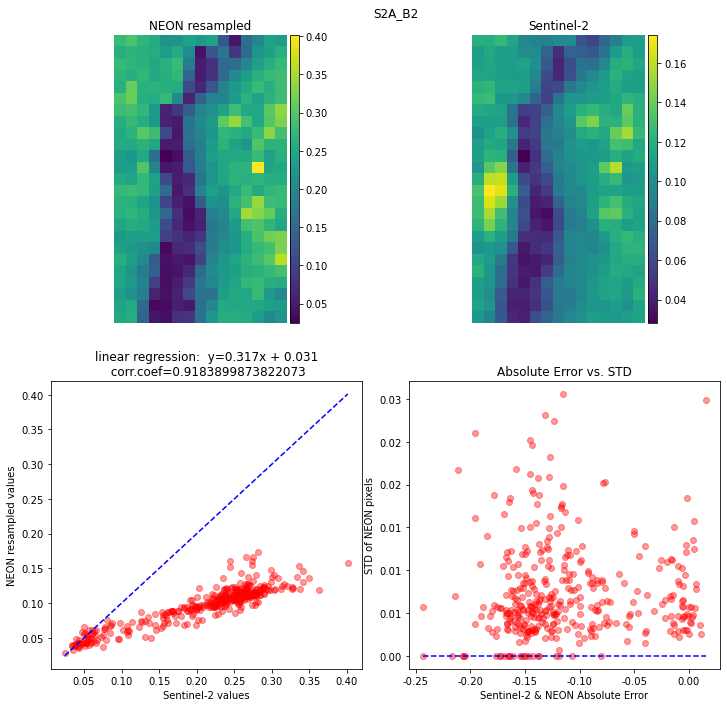

S2A_B3 2


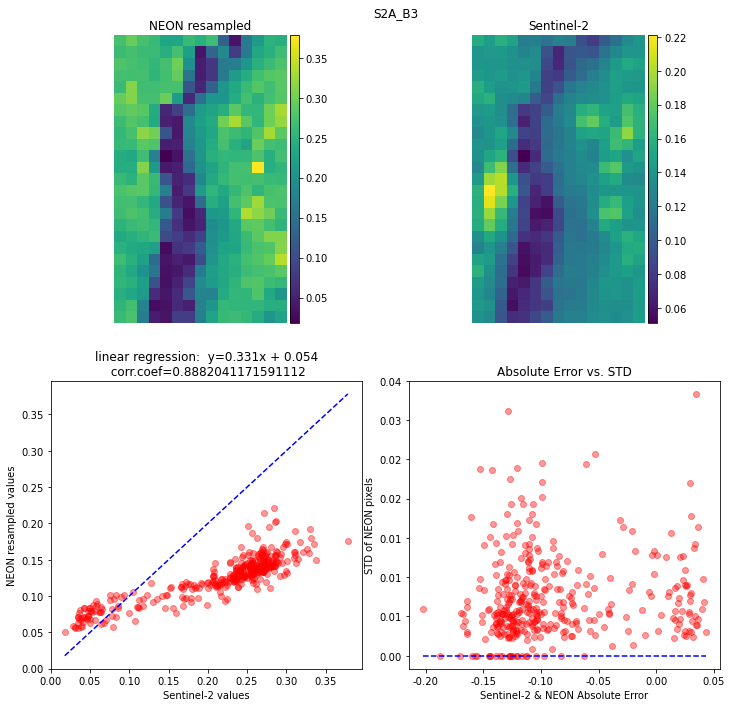

S2A_B4 3


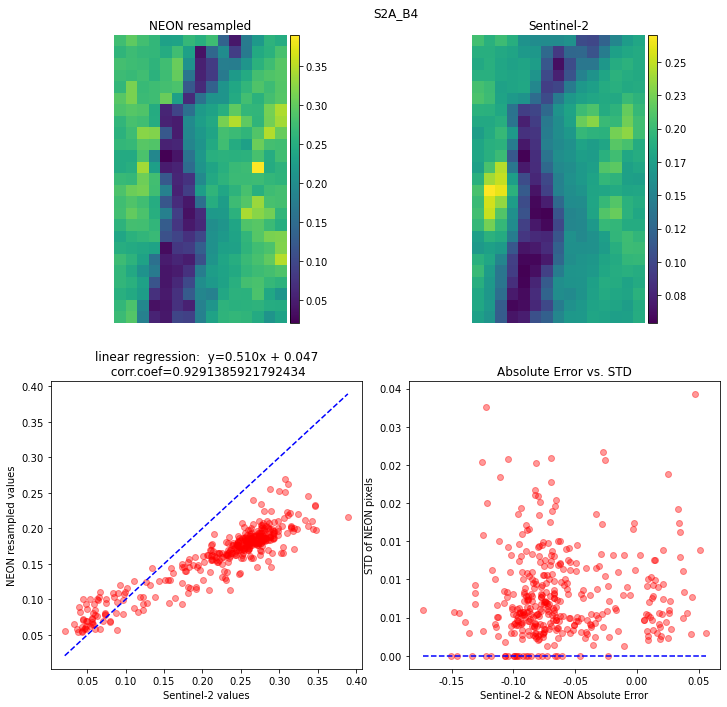

S2A_B5 4


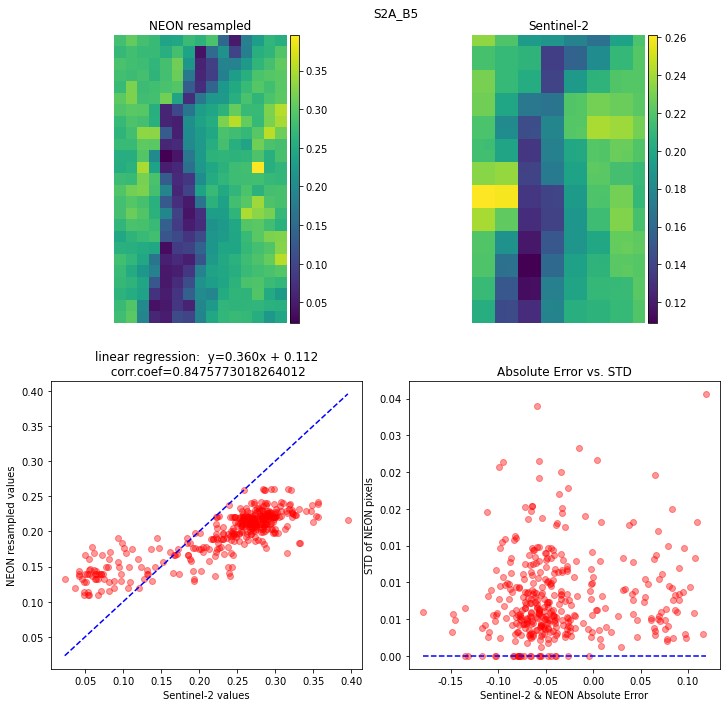

S2A_B6 5


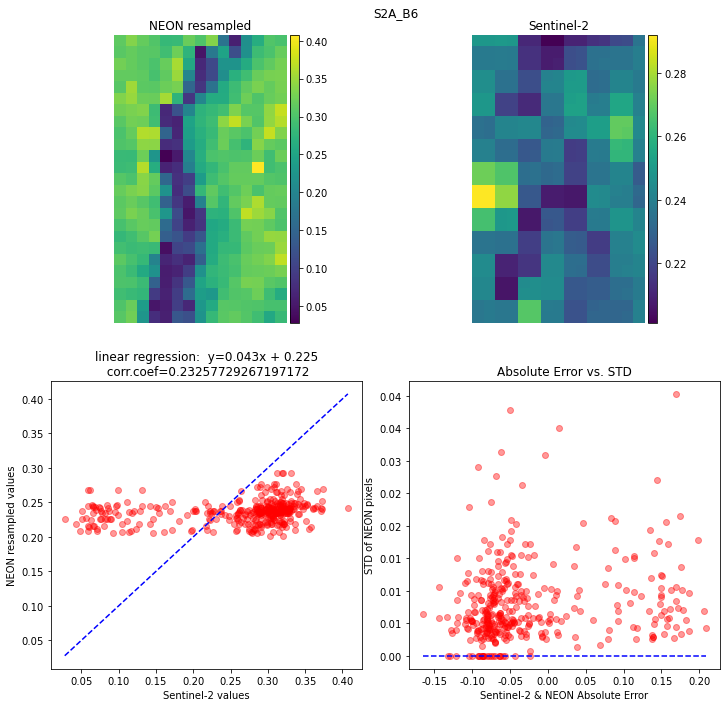

S2A_B7 6


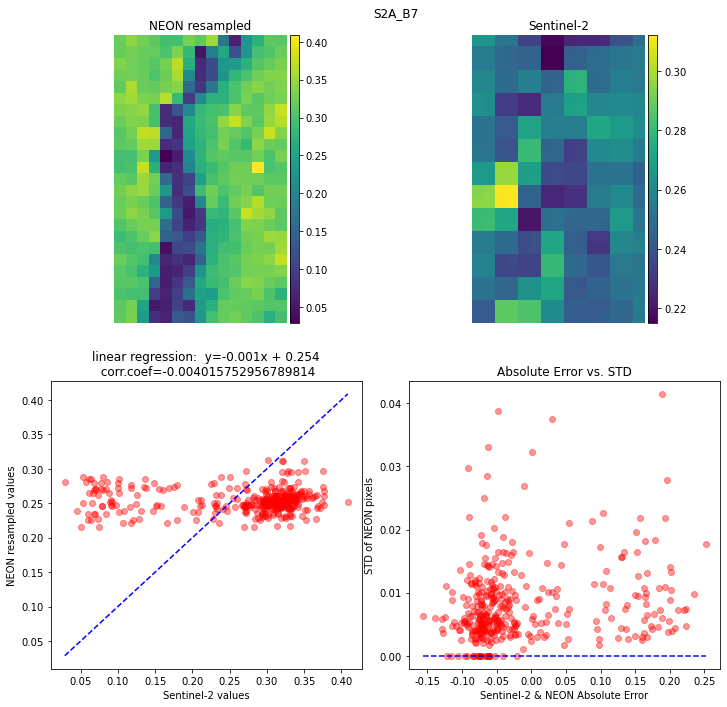

S2A_B8 7


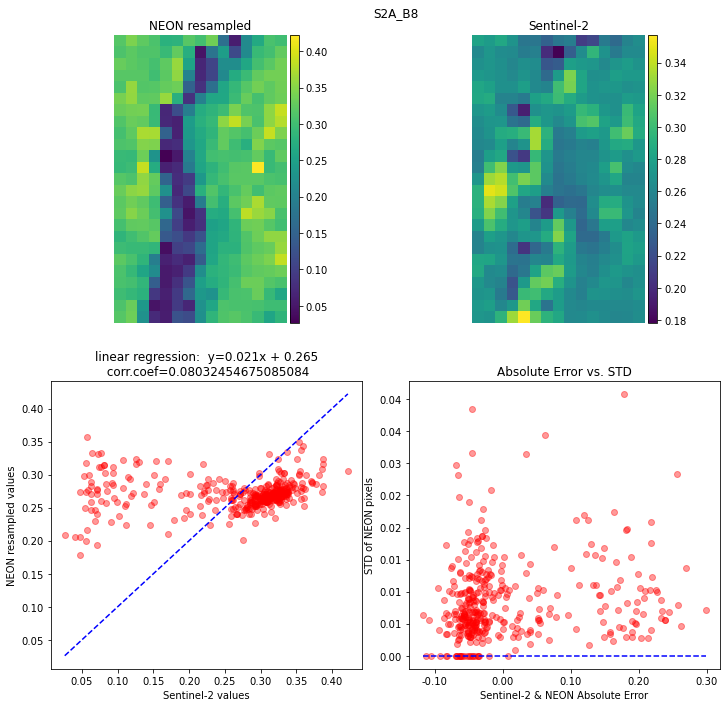

S2A_B8A 8


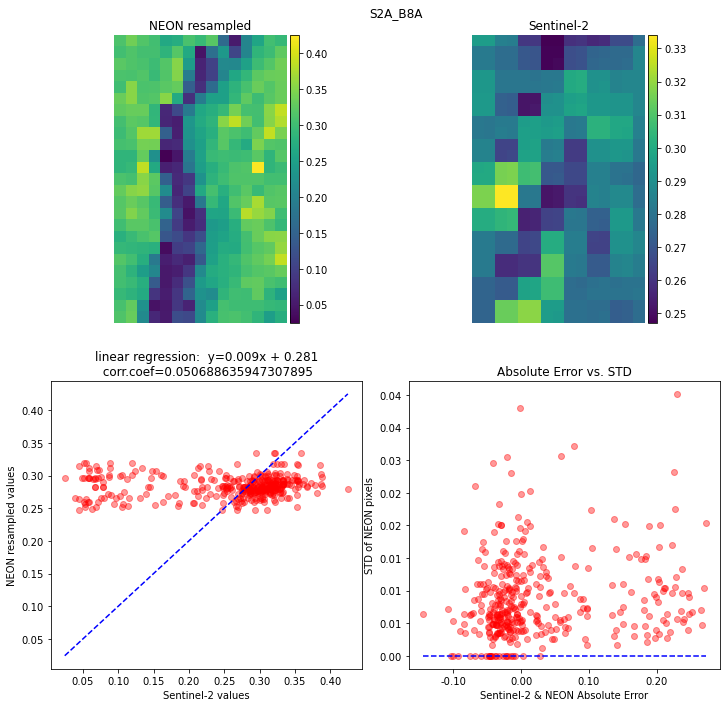

S2A_B11 9


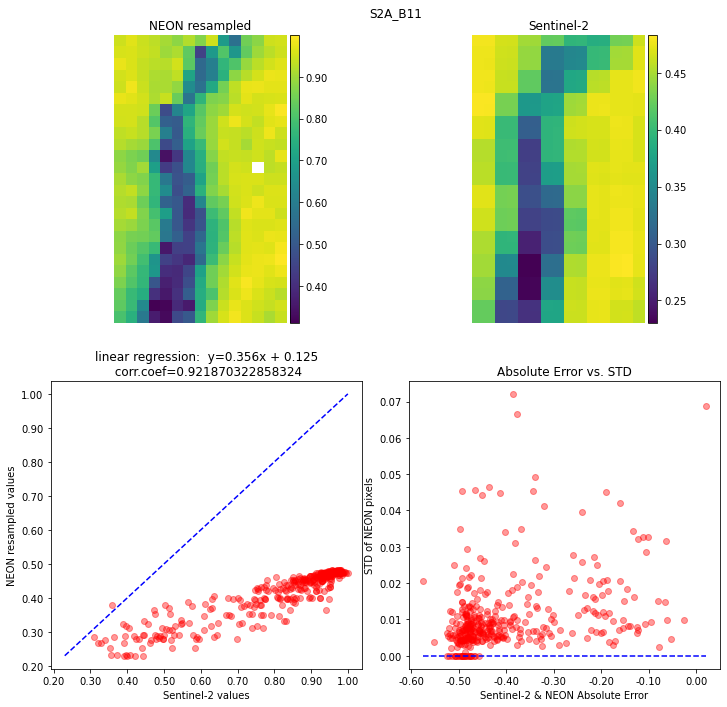

S2A_B12 10


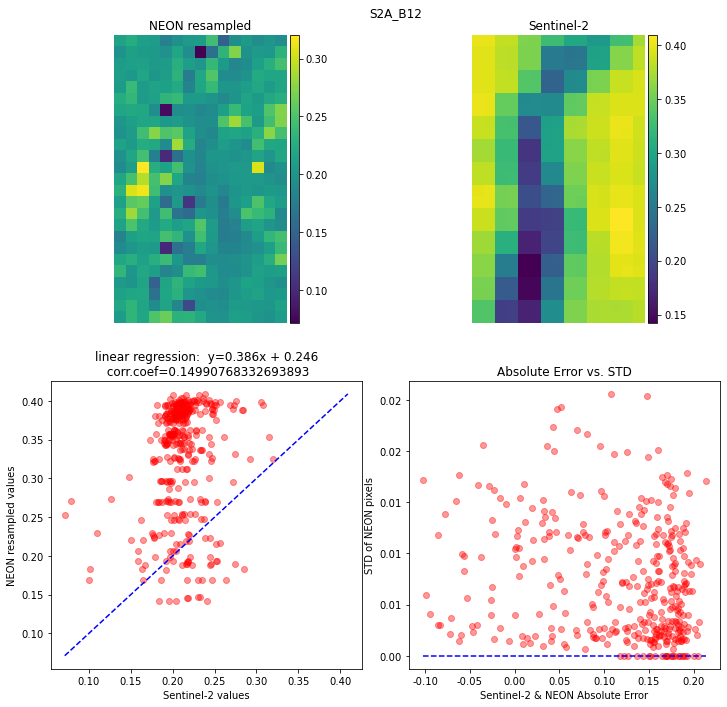

veg_1
S2A_B2 1


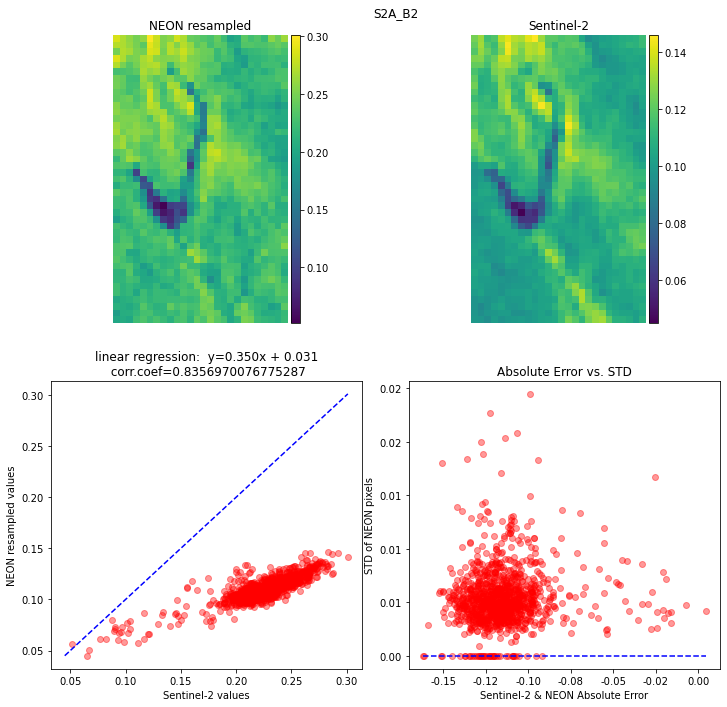

S2A_B3 2


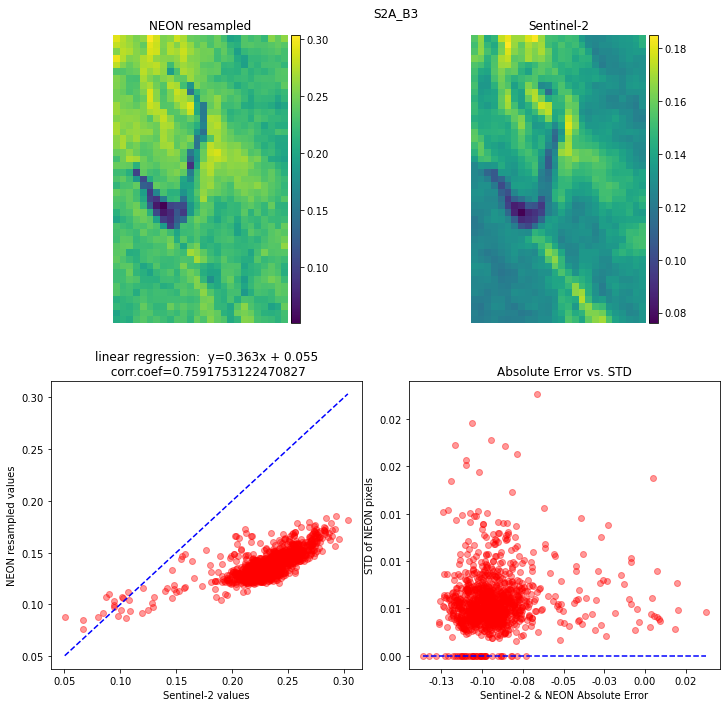

S2A_B4 3


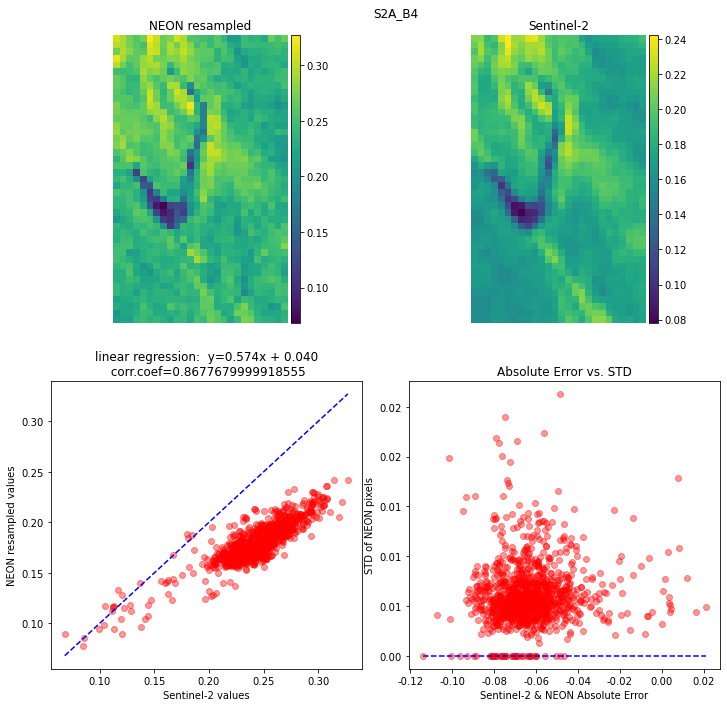

S2A_B5 4


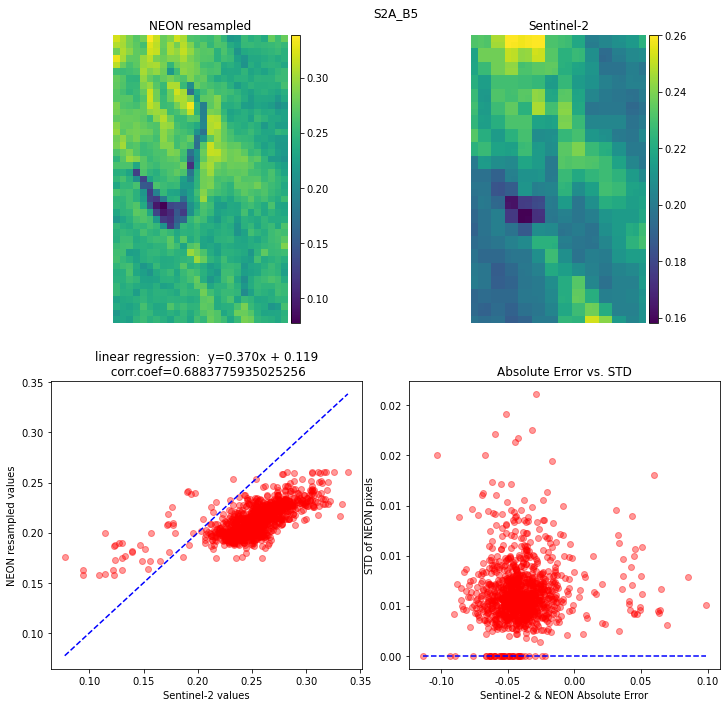

S2A_B6 5


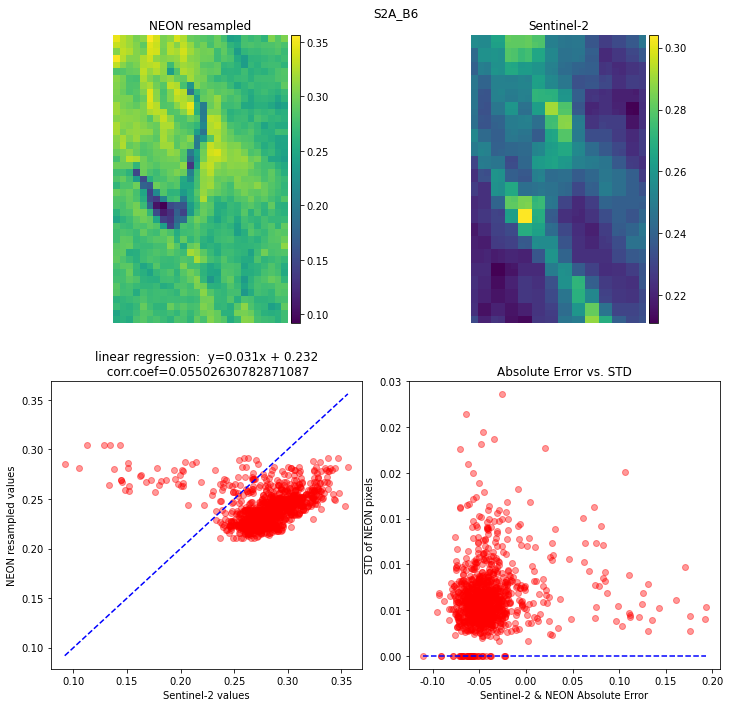

S2A_B7 6


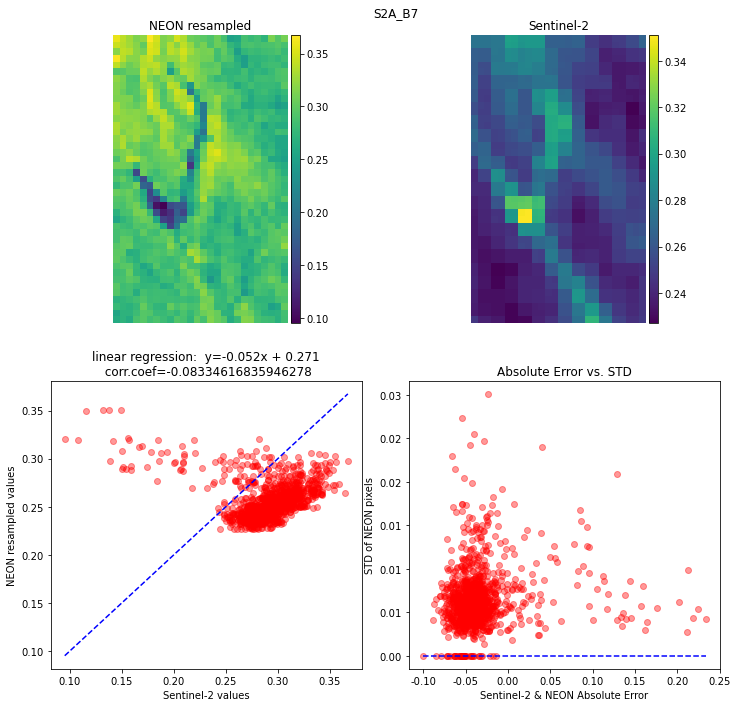

S2A_B8 7


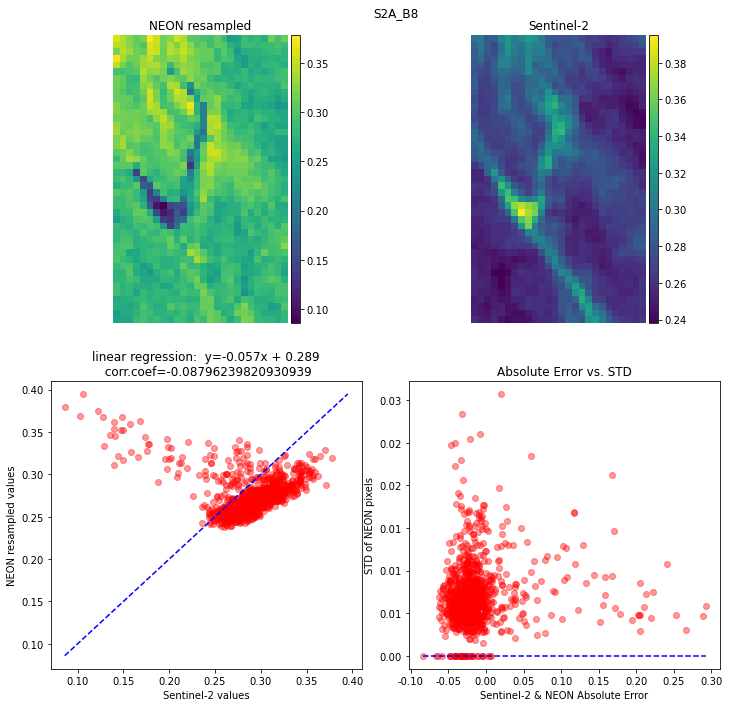

S2A_B8A 8


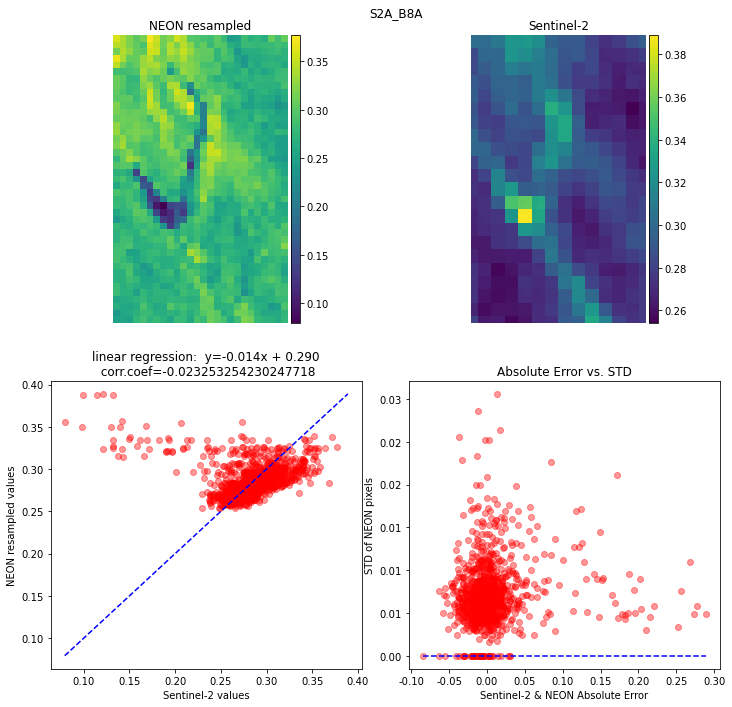

S2A_B11 9


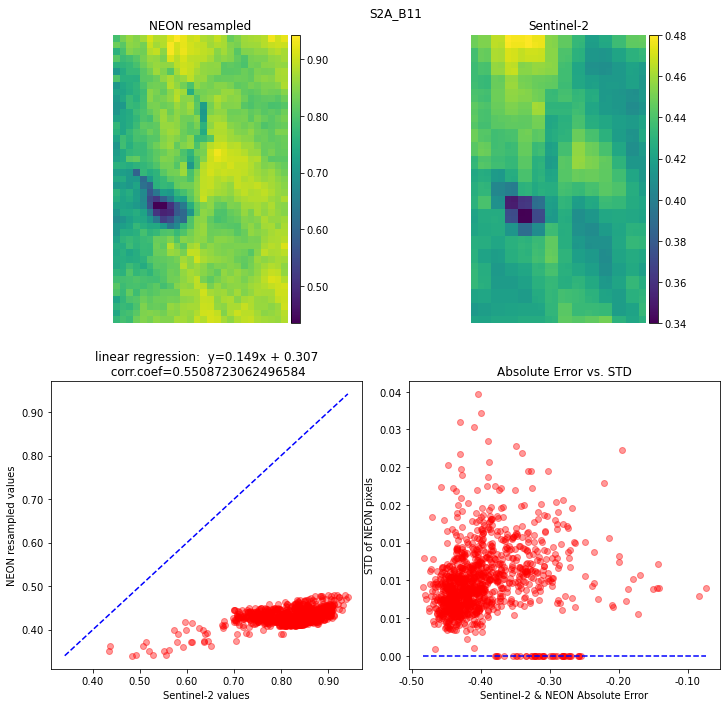

S2A_B12 10


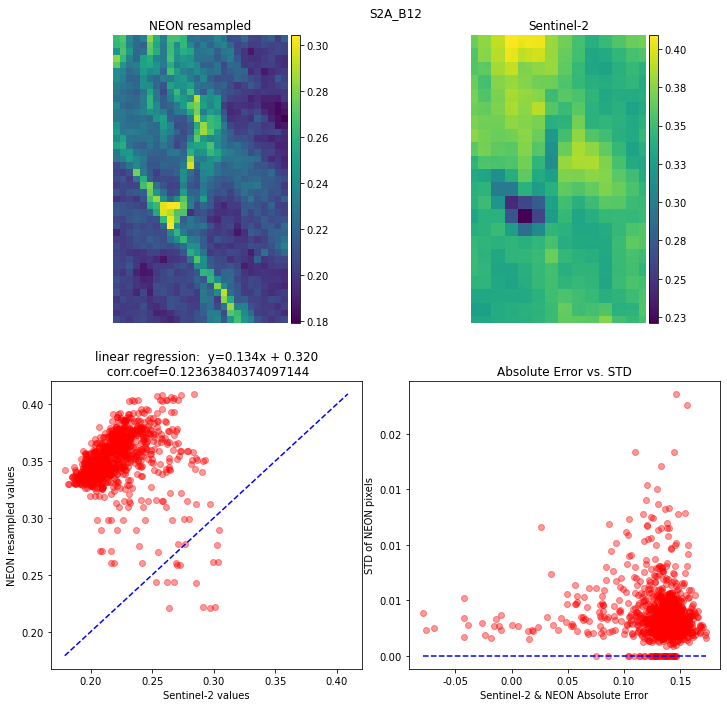

builtup_1
S2A_B2 1


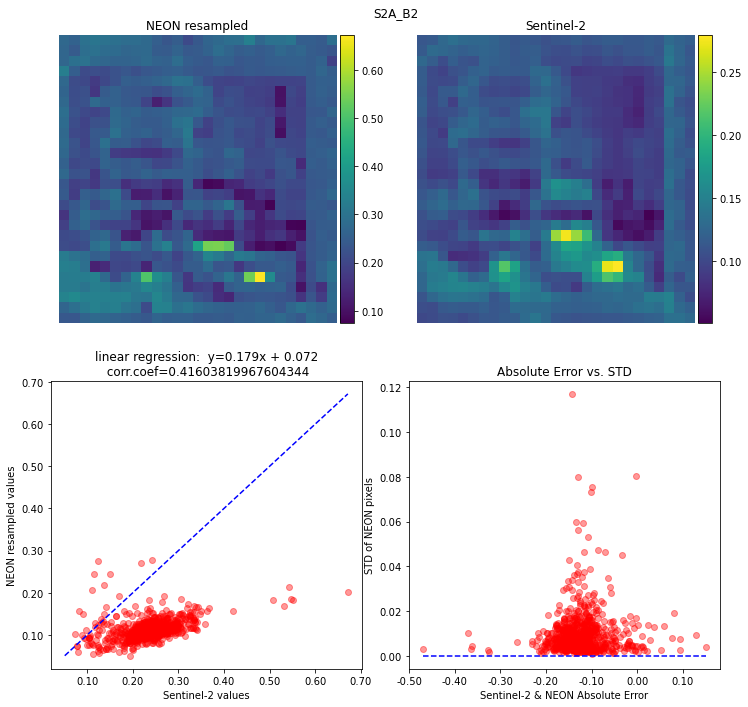

S2A_B3 2


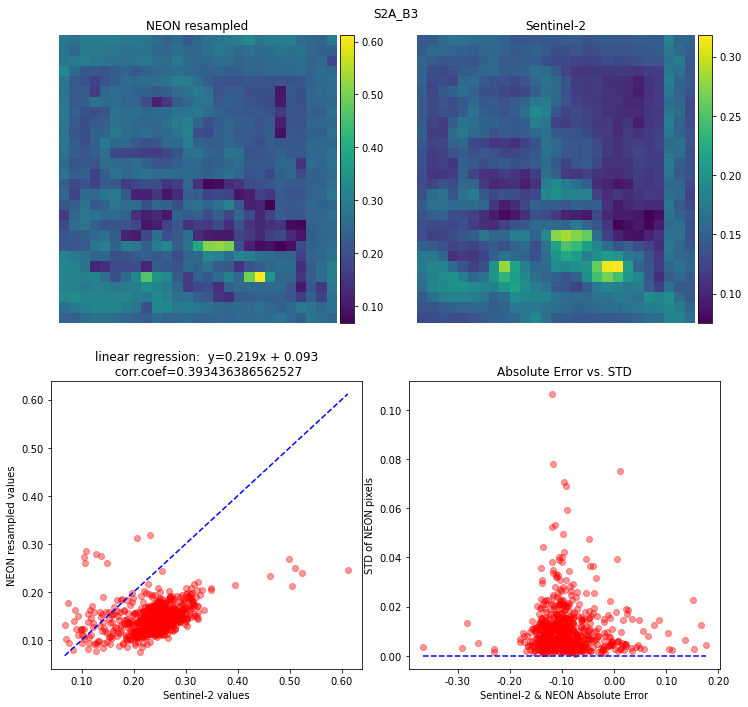

S2A_B4 3


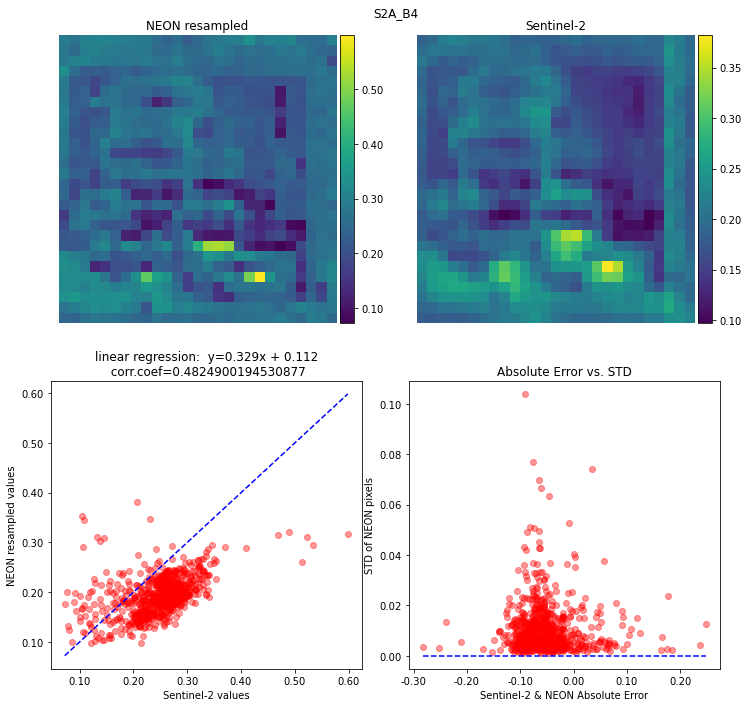

S2A_B5 4


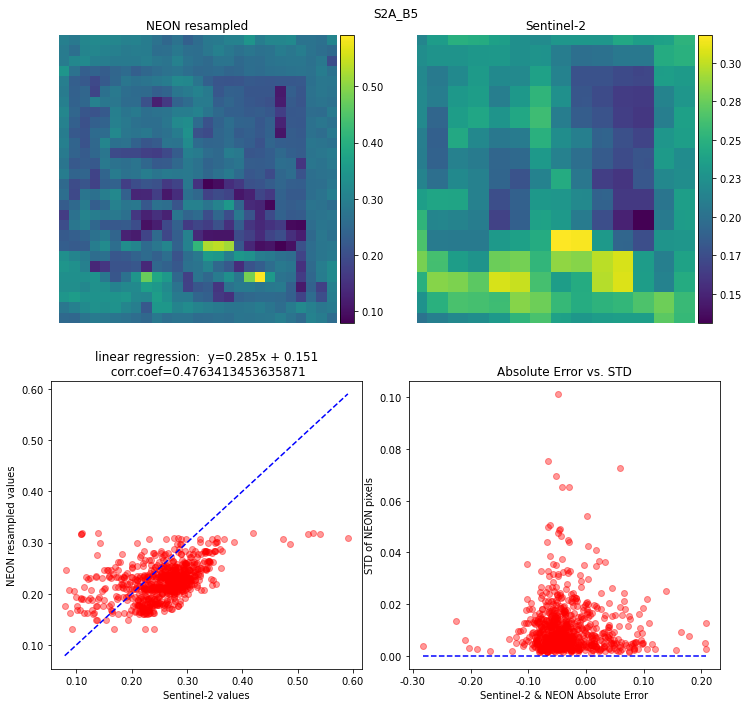

S2A_B6 5


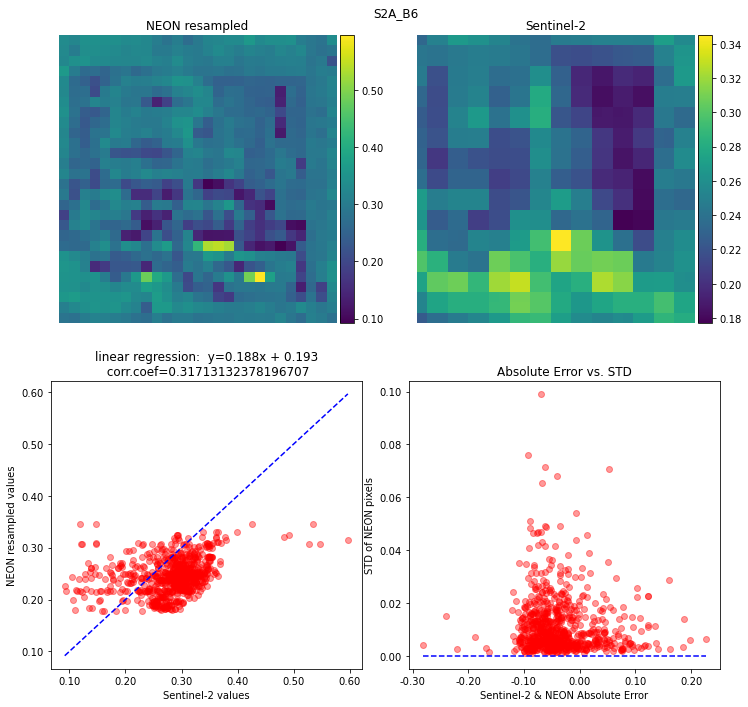

S2A_B7 6


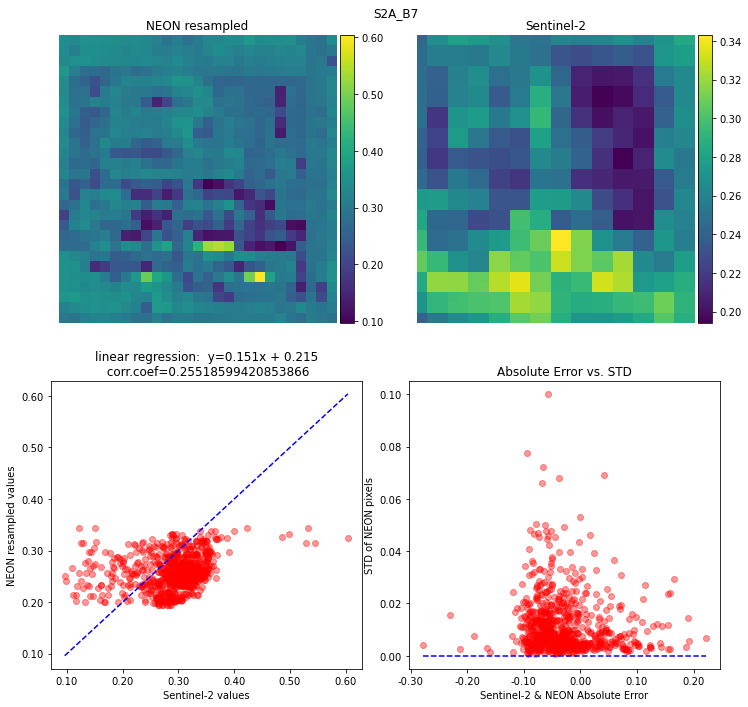

S2A_B8 7


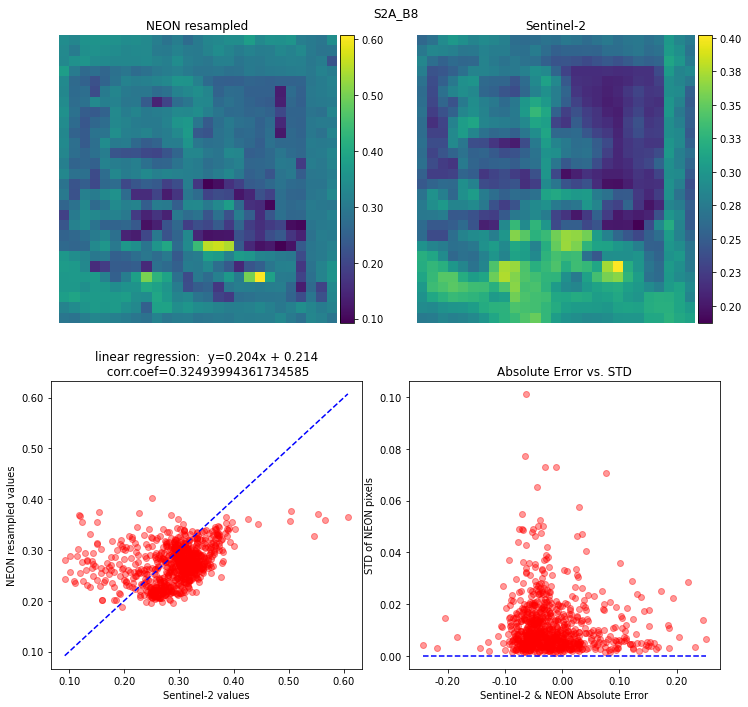

S2A_B8A 8


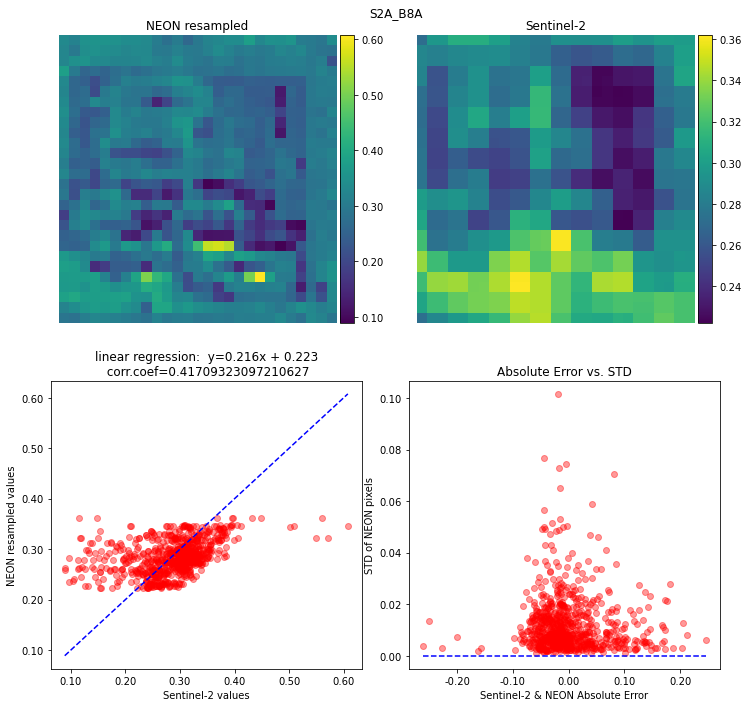

S2A_B11 9


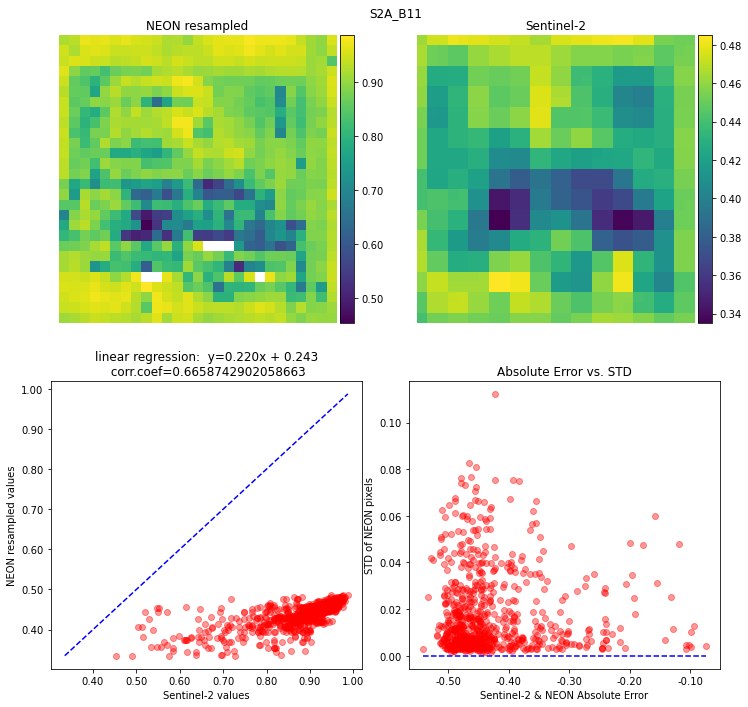

S2A_B12 10


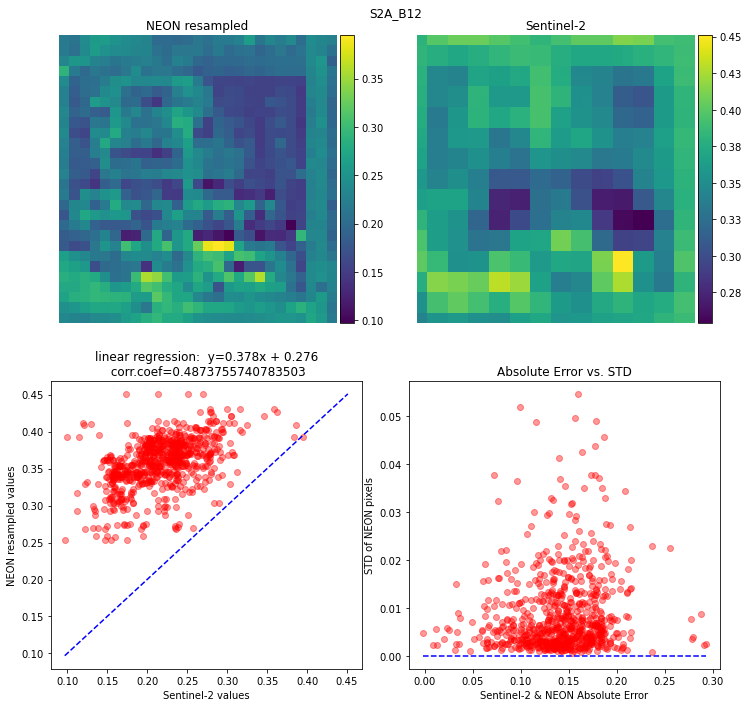

trees_2
S2A_B2 1


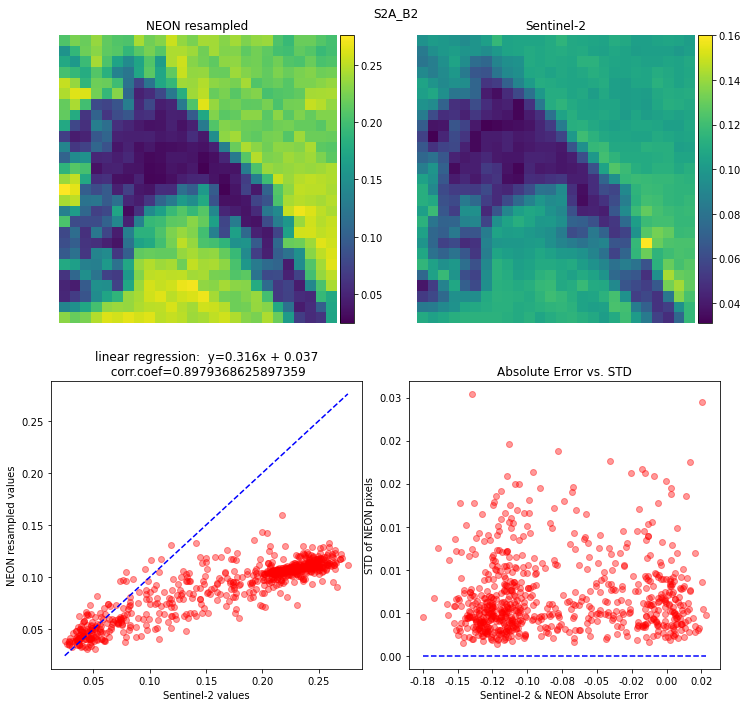

S2A_B3 2


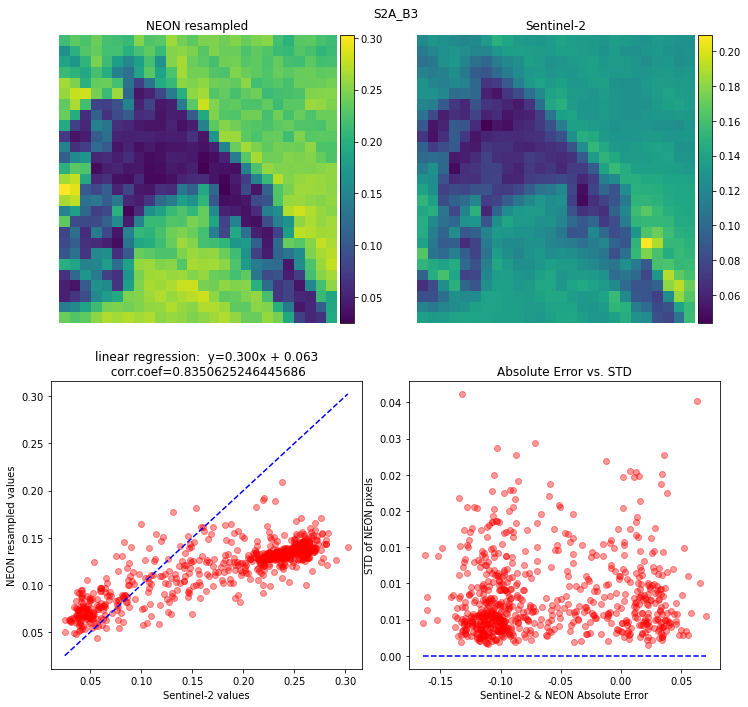

S2A_B4 3


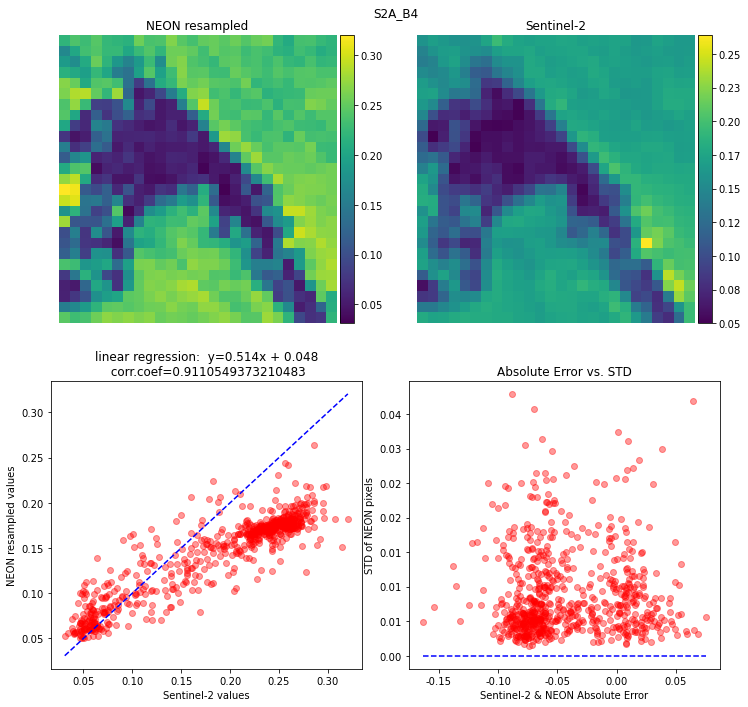

S2A_B5 4


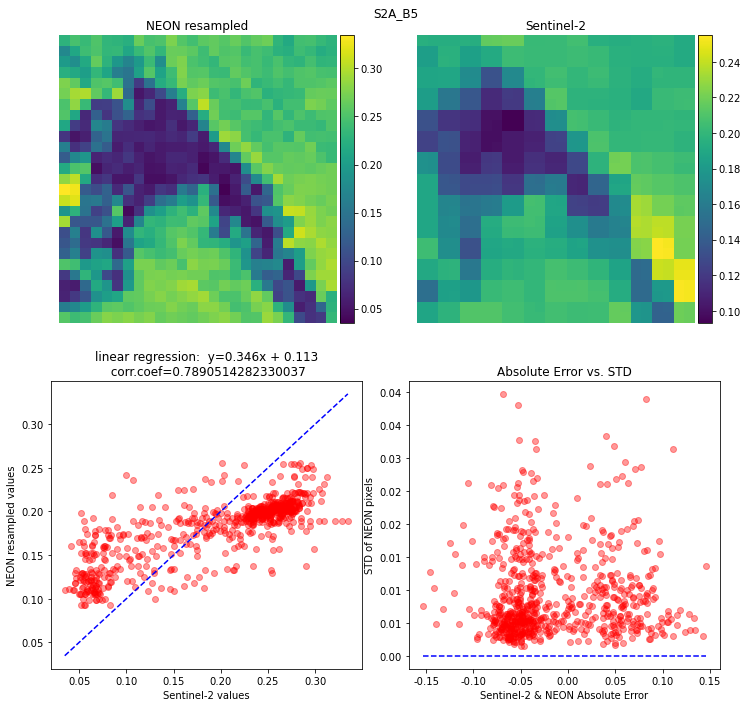

S2A_B6 5


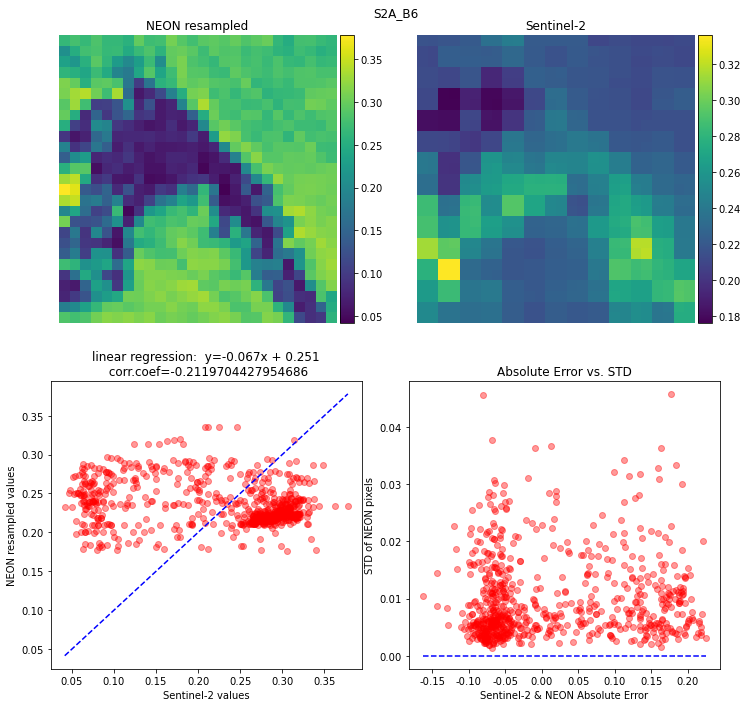

S2A_B7 6


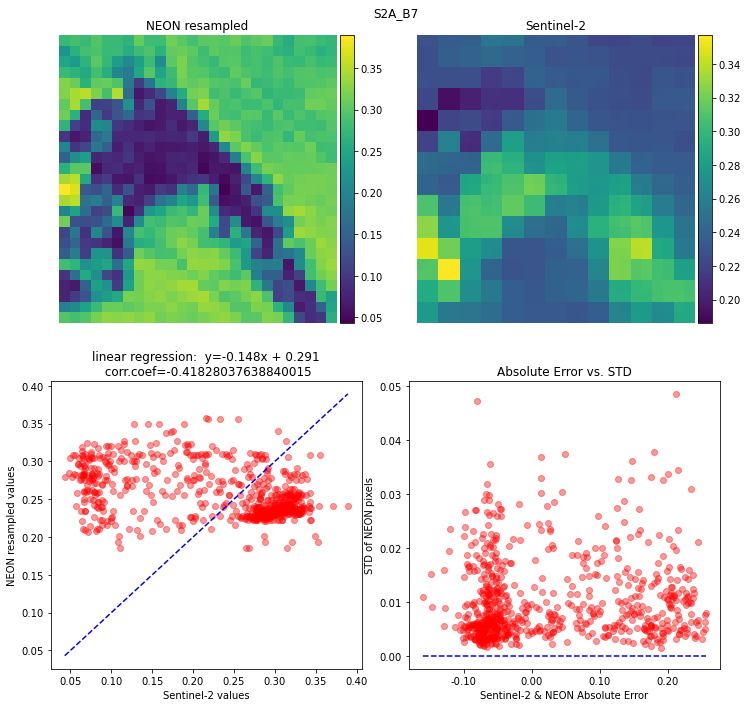

S2A_B8 7


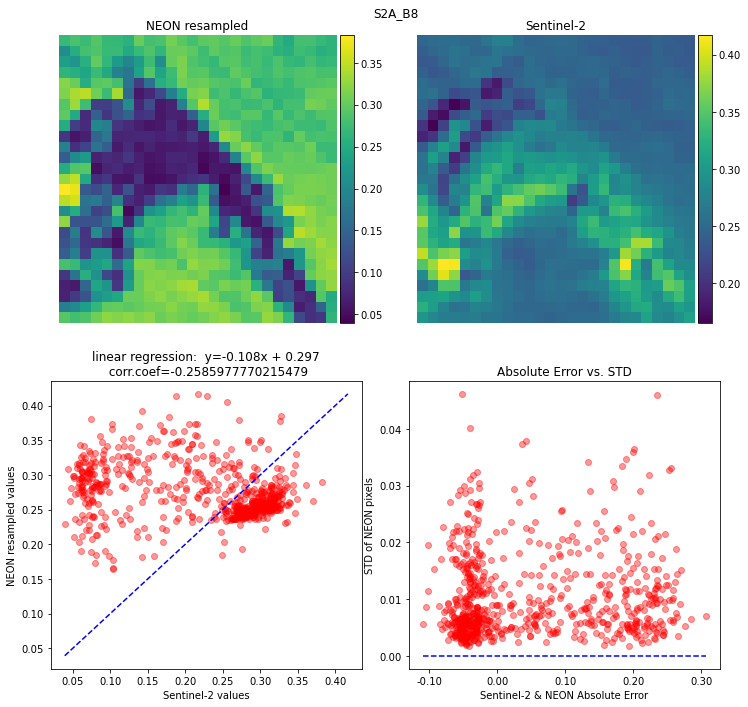

S2A_B8A 8


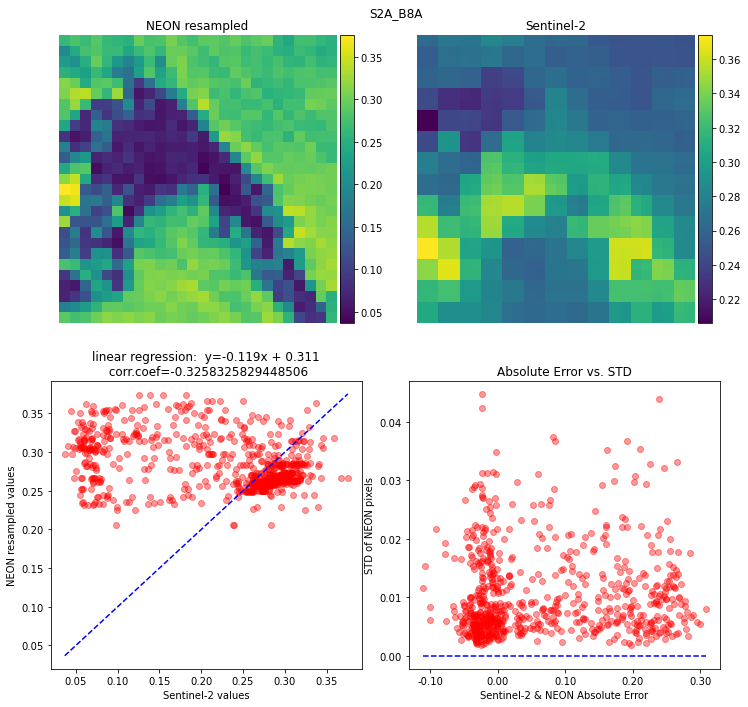

S2A_B11 9


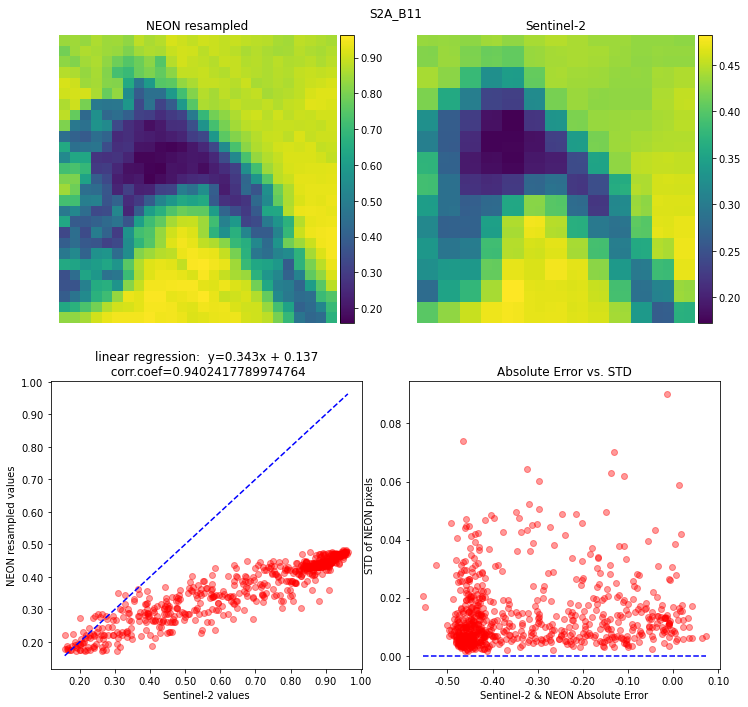

S2A_B12 10


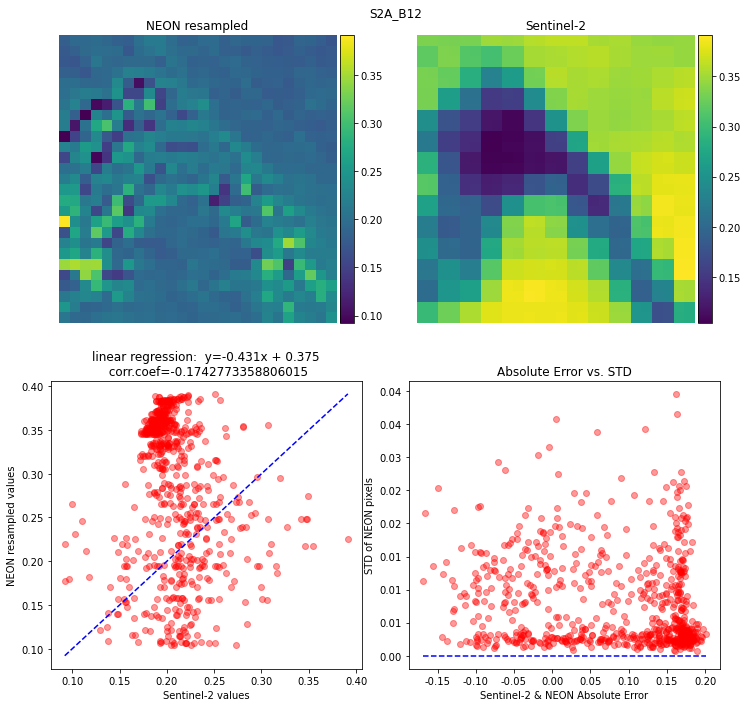

In [82]:
# plot Sentinel-2 8 ndvi for AOIs

# need to iterate through the correct bands for sentinel 2, as arcsi produces only 10m and 20m bands and omits the 60m
for desc, neon_S2, og_S2, neon_S2_std in zip(aoi_gdf.dropna().desc.values, res_S2_means, S2_arrs, res_S2_stds):
    
    print(desc)
    if 'tarp' in desc:
        print('tarp is too small, skip it...')
        continue
        
    # iterate through the bands
    n_s2_ids = neon_S2.sat_band.values[[1,2,3,4,5,6,7,8,11,12]]
    for nband, sband in zip(n_s2_ids, og_S2.band.values):
        print(nband, sband)
        
        # select the bands from the data
        neon_band = neon_S2.sel(sat_band=nband)
        satl_band = og_S2.sel(band=sband).astype('float')/1000 #arcsi scale factor is 1000
        neon_std = neon_S2_std.sel(sat_band=nband)
        
        # extract values
        neon_band_vals = np.flipud(neon_band.values)
        satl_band_vals = satl_band.values
        neon_std_vals = neon_std.values
        
        # mask bad values
        neon_band_vals = np.ma.masked_greater(neon_band_vals, 1)
        satl_band_vals = np.ma.masked_greater(satl_band_vals, 1)
        
        # get shapes
        neon_shape = neon_band_vals.shape
        sat_shape = satl_band_vals.shape

        # if shape is too small, don't plot it
        if 1 in np.array([neon_shape] + [sat_shape]):
            print('array is too small for anything, continuing...')
            continue

        # slice if necessary
        if neon_shape[0] < sat_shape[0]:
            satl_band_vals = satl_band_vals[:neon_shape[0],:]

        if neon_shape[1] < sat_shape[1]:
            satl_band_vals = satl_band_vals[:, :neon_shape[1]]

        if neon_shape[0] > sat_shape[0]:
            neon_band_vals = neon_band_vals[:sat_shape[0],:]
            neon_std_vals = neon_std_vals[:sat_shape[0], :]

        if neon_shape[1] > sat_shape[1]:
            neon_band_vals = neon_band_vals[:, :sat_shape[1]]
            neon_std_vals = neon_std_vals[:, :sat_shape[1]]


        # linear regression piece
        x = np.ma.masked_invalid(neon_band_vals.flatten())
        y = np.ma.masked_invalid(satl_band_vals.flatten())
        slope, intercept, r, p, se = linregress(x, y)
        
        
        # get the correlation coefficient
        corr = np.ma.corrcoef(np.ma.masked_invalid(neon_band_vals.flatten()), 
                              np.ma.masked_invalid(satl_band_vals.flatten()))[0,1]
    
        ############### PLOTTING ##################
        # plot the images and scatter plots
        fig, ax = plt.subplots(2,2, figsize=(10,10))
        fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.15)

        ## NEON resampled band
        im = ax[0,0].imshow(neon_band_vals)
        
        divider = make_axes_locatable(ax[0,0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, format=FormatStrFormatter('%.2f'))
        
        #fig.colorbar(im, ax=ax[0,0])
        ax[0,0].set_title('NEON resampled')
        ax[0,0].axis('off')

        ## Satellite band
        im = ax[0,1].imshow(satl_band_vals)
        
        divider = make_axes_locatable(ax[0,1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, format=FormatStrFormatter('%.2f'))
        
        #fig.colorbar(im, ax=ax[0,1])
        ax[0,1].set_title('Sentinel-2')
        ax[0,1].axis('off')

        ## Scatter plot of resampled NEON mean value and satellite band
        #im = ax[1,0].scatter(neon_band_vals.flatten(), satl_band_vals.flatten(), alpha=0.4, color='r')
        im = ax[1,0].scatter(x, y, alpha=0.4, color='r')
        ax[1,0].set_title('Sentinel-2 vs. NEON means')
        ax[1,0].set_xlabel('Sentinel-2 values')
        ax[1,0].set_ylabel('NEON resampled values')
        ax[1,0].set_title(f'linear regression:  y={slope:0.3f}x + {intercept:0.3f}\n corr.coef={corr}')
        
        ## plot 1:1 line
        minval = min(x.min(), y.min())
        maxval = max(x.max(), y.max())
        ax[1,0].plot([minval, maxval], [minval, maxval], 'b--')
        
        ax[1,0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        ## Scatter plot of difference values vs. std for that pixel
        ax[1,1].scatter(satl_band_vals.flatten() - neon_band_vals.flatten(), neon_std_vals.flatten(), alpha=0.4, color='r')
        ax[1,1].set_xlabel('Sentinel-2 & NEON Absolute Error')
        ax[1,1].set_ylabel('STD of NEON pixels')
        ax[1,1].set_title(f'Absolute Error vs. STD')
        
        ## plot zero line line
        minval = (y-x).min()
        maxval = (y-x).max()
        ax[1,1].plot([minval, maxval], [0,0], 'b--')
        
        ax[1,1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax[1,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        
        fig.suptitle(nband)
        plt.show()



In [78]:
neon_S2

<xarray.DataArray 'truediv-a96f571d0f779ca9e460db3aaeb0d9f7' (sat_band: 13, y: 27, x: 26)>
dask.array<transpose, shape=(13, 27, 26), dtype=float64, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.524e+06 4.524e+06
  * x            (x) float64 5.209e+05 5.209e+05 ... 5.212e+05 5.212e+05
  * sat_band     (sat_band) <U7 'S2A_B1' 'S2A_B2' ... 'S2A_B11' 'S2A_B12'
    spatial_ref  int32 0

In [79]:
og_S2

<xarray.DataArray (band: 10, y: 27, x: 26)>
array([[[ 97, 102, 100, ..., 107, 106, 103],
        [ 84,  95, 100, ..., 104, 101, 104],
        [ 81,  86,  96, ..., 107, 106, 109],
        ...,
        [ 53,  59,  75, ...,  82, 136, 123],
        [ 84,  85,  92, ...,  55,  96, 117],
        [110, 105, 108, ...,  48,  74, 117]],

       [[122, 130, 127, ..., 131, 129, 127],
        [112, 121, 127, ..., 129, 127, 128],
        [106, 110, 127, ..., 132, 126, 129],
        ...,
        [ 84,  84, 104, ..., 124, 183, 165],
        [118, 112, 119, ...,  85, 139, 155],
        [138, 134, 135, ...,  79, 107, 157]],

       [[160, 170, 164, ..., 170, 166, 166],
        [146, 160, 168, ..., 167, 165, 167],
        [141, 146, 166, ..., 170, 166, 169],
        ...,
...
        ...,
        [317, 318, 324, ..., 324, 335, 333],
        [308, 308, 290, ..., 301, 319, 317],
        [308, 308, 290, ..., 300, 318, 317]],

       [[434, 433, 434, ..., 432, 429, 429],
        [424, 423, 435, ..., 433, 433, 433],
        [424, 424, 435, ..., 432, 432, 432],
        ...,
        [281, 281, 352, ..., 312, 437, 434],
        [403, 403, 430, ..., 266, 370, 368],
        [403, 403, 430, ..., 265, 369, 368]],

       [[334, 334, 333, ..., 345, 346, 346],
        [320, 320, 335, ..., 350, 346, 346],
        [320, 320, 335, ..., 349, 346, 346],
        ...,
        [206, 206, 255, ..., 233, 355, 352],
        [299, 299, 328, ..., 175, 284, 282],
        [299, 299, 328, ..., 175, 283, 282]]], dtype=uint16)
Coordinates:
  * x            (x) float64 5.209e+05 5.209e+05 ... 5.212e+05 5.212e+05
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.524e+06 4.524e+06
  * band         (band) int32 1 2 3 4 5 6 7 8 9 10
    spatial_ref  int32 0
Attributes:
    ATTRIBUTETABLE_CHUNKSIZE:     1000
    LAYER_TYPE:                   athematic
    STATISTICS_EXCLUDEDVALUES:    0
    STATISTICS_HISTOBINFUNCTION:  linear
    STATISTICS_HISTOBINVALUES:    18297|10661|361530|775497|863068|937208|137...
    STATISTICS_HISTOMAX:          2350
    STATISTICS_HISTOMIN:          1
    STATISTICS_HISTONUMBINS:      256
    STATISTICS_MAXIMUM:           2350
    STATISTICS_MEAN:              97.8392543156085
    STATISTICS_MEDIAN:            92.7578125
    STATISTICS_MINIMUM:           1
    STATISTICS_MODE:              101.93359375
    STATISTICS_STDDEV:            23.740284032778938
    scale_factor:                 1.0
    add_offset:                   0.0
    long_name:                    ('Blue', 'Green', 'Red', 'RE_B5', 'RE_B6', ...
    grid_mapping:                 spatial_ref
    _FillValue:                   0